In [1]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
import warnings
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter1d

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, time_cell_plots

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [2]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [3]:
load_single_file = True

start_time = time()

# Load all time OLS result files.
filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'all_units_time',
                   'ols-time_bin-model_pairs-457units.pkl')
if load_single_file and op.exists(filename):
    ols_pairs = dio.open_pickle(filename)
else:
    ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))
    print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

    warnings.filterwarnings('ignore')
    bad_files = []
    ols_pairs = pd.DataFrame([])
    for filename in ols_pairs_files:
        try:
            ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
        except:
            bad_files.append(filename)
    ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
    warnings.resetwarnings()

    # Restrict dataframe rows to navigation periods.
    keep_cols = ['subj_sess', 'neuron', 'gameState', 'testvar', 'full', 'llf_full', 'lr', 'z_lr', 'emp_pval']
    # ols_pairs = ols_pairs.query("(gameState==['Encoding', 'Retrieval'])")[keep_cols].reset_index(drop=True)
    ols_pairs = ols_pairs[keep_cols].reset_index(drop=True)

    # Organize categorical columns.
    test_vars = ['time', 'place', 'head_direc', 'gold_in_view', 'base_in_view']
    test_var_cat = pd.CategoricalDtype(test_vars, ordered=True)
    ols_pairs['testvar'] = ols_pairs['testvar'].astype(test_var_cat)

    full_models = ['time', 'time_place', 'full']
    full_model_cat = pd.CategoricalDtype(full_models, ordered=True)
    ols_pairs['full'] = ols_pairs['full'].astype(full_model_cat)

    # Add new columns.
    roi_map = spike_preproc.roi_mapping(n=3)
    val_map = od([('hem', []),
                  ('roi', []),
                  ('roi_gen', []),
                  ('spike_mat'        , []),
                  ('mean_frs'         , []),
                  ('sem_frs'          , []),
                  ('fr_mean'          , []),
                  ('fr_max'           , []),
                  ('fr_max_ind'       , []),
                  ('sparsity'         , [])])
    for idx, row in ols_pairs.iterrows():
        if 'event_spikes' not in dir():
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        elif event_spikes.subj_sess != row['subj_sess']:
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
        hem = hemroi[0]
        roi = hemroi[1:]
        roi_gen = roi_map.get(roi, np.nan)
        spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
        mean_frs = time_bin_analysis.get_mean_frs(spike_mat) * 2
        sem_frs = time_bin_analysis.get_sem_frs(spike_mat) * 2
        fr_mean = np.mean(mean_frs.values)
        fr_max = np.max(mean_frs.values)
        fr_max_ind = np.argmax(mean_frs.values)
        sparsity = time_bin_analysis.get_sparsity(spike_mat)

        val_map['hem'].append(hem)
        val_map['roi'].append(roi)
        val_map['roi_gen'].append(roi_gen)
        val_map['spike_mat'].append(spike_mat.values.tolist())
        val_map['mean_frs'].append(mean_frs.tolist())
        val_map['sem_frs'].append(sem_frs.tolist())
        val_map['fr_mean'].append(fr_mean)
        val_map['fr_max'].append(fr_max)
        val_map['fr_max_ind'].append(fr_max_ind)
        val_map['sparsity'].append(sparsity)

    ols_pairs.insert(0, 'subj', ols_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
    ols_pairs.insert(2, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
    ols_pairs.insert(4, 'hem', val_map['hem'])
    ols_pairs.insert(5, 'roi', val_map['roi'])
    ols_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
    for col_name in val_map:
        if col_name not in ols_pairs:
            ols_pairs[col_name] = val_map[col_name]
    roi_gen_cat = ['Hippocampus', 'MTL', 'Cortex']
    ols_pairs['roi_gen'] = ols_pairs['roi_gen'].astype(pd.CategoricalDtype(roi_gen_cat, ordered=True))
    ols_pairs.insert(ols_pairs.columns.tolist().index('roi_gen')+1, 'roi_gen2', ols_pairs['roi_gen'].tolist())
    ols_pairs.loc[ols_pairs['roi_gen']=='Hippocampus', 'roi_gen2'] = 'MTL'
    ols_pairs['roi_gen2'] = ols_pairs['roi_gen2'].astype(pd.CategoricalDtype(['MTL', 'Cortex'], ordered=True))
    
    # Test significance.
    alpha = 0.05
    ols_pairs['sig'] = False
    ols_pairs.loc[((ols_pairs['emp_pval']<alpha)), 'sig'] = True
    ols_pairs['sig_holm'] = ols_pairs.groupby(['subj_sess_unit', 'gameState', 'full'])['emp_pval'].transform(lambda x: sm.stats.multipletests(x, alpha, method='holm')[0])

    print('{} bad files'.format(len(bad_files)))

    
def _fr_max_ind(spike_mat, bins=10):
    return np.argmax([v.sum() for v in np.split(np.sum(spike_mat, axis=0), bins)])

# icol = ols_pairs.columns.tolist().index('fr_max_ind') + 1
# ols_pairs.insert(icol, 'fr_max_ind10', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 10)))
# ols_pairs.insert(icol+2, 'fr_max_ind5', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 5)))

print('ols_pairs:', ols_pairs.shape)

print('Done in {:.1f}s'.format(time() - start_time))

ols_pairs: (5027, 35)
Done in 0.8s


In [16]:
# Remove null arrays from spike time files.
start_time = time()

spike_files = glob(op.join(proj_dir, 'analysis', 'spikes', '*-spikes.pkl'))

files_changed = 0
for fname in spike_files:
    spikes = dio.open_pickle(fname)    
    keep_keys = [k for k in spikes.keys() if 'null' not in k]
    if len(spikes) > len(keep_keys):
        spikes = spikes[keep_keys]
        dio.save_pickle(spikes, fname, verbose=False)
        files_changed += 1

print('{} files changed'.format(files_changed))
print('Done in {:.1f}s'.format(time() - start_time))

269 files changed
Done in 173.1s


In [3]:
# # Select subject.
# start_time = time()

# proj_dir = '/home1/dscho/projects/time_cells'
# sessions = np.array([op.basename(f).split('-')[0]
#                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
# sessions = ['U530_ses0']

# for subj_sess in sessions:
#     print(subj_sess, '{:.2f}s'.format(time() - start_time), end='\n\n')
#     subj, sess = subj_sess.split('_')

#     # Load events and event times.
#     events = events_preproc.format_events(subj_sess,
#                                           overwrite=False,
#                                           save_output=False,
#                                           verbose=True)
#     game_states = ['Prepare1', 'Delay1', 'Encoding', 'Prepare2', 'Delay2', 'Retrieval']
# #     trial_times = events_preproc.trial_intervals(events)
#     event_times = events_preproc.create_event_time_bins(subj_sess,
#                                                         events=events,
#                                                         game_states=game_states,
#                                                         overwrite=True,
#                                                         save_output=False,
#                                                         verbose=True)

#     # Load spikes.
#     lfp_timestamps, sr = spike_sorting.load_lfp_timestamps(subj_sess,
#                                                            verbose=False)
#     spikes = spike_preproc.format_spikes(subj_sess,
#                                          conv_factor='infer',
#                                          fr_thresh=0.1,
#                                          overwrite=True,
#                                          save_output=False,
#                                          verbose=True)
#     if subj_sess == 'U518_ses1':
#         exclude = [0, 2, 5, 6, 7, 
#                    8, 9, 11, 19, 20, 
#                    21, 22, 32, 33, 42, 
#                    44, 45, 46, 47, 48, 
#                    49, 50]
#         spikes = spikes.query("(index!={})".format(exclude)).reset_index(drop=True)

#     # Add spike time null distribution for each trial and trial phase.
#     n_perms = 1000
# #     spikes = spike_preproc.add_null_to_spikes(subj_sess,
# #                                               trial_times,
# #                                               spikes=spikes,
# #                                               output_col='spike_times_null_trial',
# #                                               n_perms=n_perms,
# #                                               save_output=False,
# #                                               split_files=False,
# #                                               verbose=True)
#     spikes = spike_preproc.add_null_to_spikes(subj_sess,
#                                               event_times,
#                                               spikes=spikes,
#                                               output_col='spike_times_null_trial_phase',
#                                               n_perms=n_perms,
#                                               save_output=True,
#                                               split_files=True,
#                                               verbose=True)

# print('Done in {:.2f} s'.format(time() - start_time))

In [4]:
# Calculate firing rates for each neuron within each trial and trial phase time bin.
# ---------------
# RUN IN PARALLEL
# ---------------
#     event_fr_parallel() in time_cells/parallel/parallel_in_python3.ipynb,
#     which calls spike_preproc.event_fr()

In [5]:
# Z-score trial phase time bins and calculate temporal info scores.
# ---------------
# RUN IN PARALLEL
# ---------------
#     calc_mean_fr_by_time_parallel() in time_cells/parallel/parallel_in_python3.ipynb,
#     which calls time_bin_analysis.calc_mean_fr_by_time()

In [6]:
# roi_mapping = {'A': 'AMY',
#                'AH': 'HPC',
#                'AI': 'Frontal',
#                'EC': 'EC',
#                'FOp': 'Frontal',
#                'MFG': 'Frontal',
#                'MH': 'HPC',
#                'O': 'Occipital',
#                'OF': 'Frontal',
#                'PHG': 'PHG',
#                'TO': 'Temporal',
#                'TPO': 'Parietal'}

In [7]:
# proj_dir = '/home1/dscho/projects/time_cells'

# # # Load FR files.
# # files = np.sort(glob(op.join(proj_dir, 'analysis', 'fr_by_time_bin', '*unit*.pkl')))
# # print('{} files'.format(len(files)))

# # fr_by_time = od([])
# # for f in files:
# #     k = '-'.join(op.basename(f).split('-')[:3]).replace('CSC', 'ch').replace('unit', '')
# #     fr_by_time[k] = dio.open_pickle(f)

# # Load mean FR files.
# files = glob(op.join(proj_dir, 'analysis', 'fr_by_time_bin', '*mean_fr_by_time.pkl'))
# print('{} files'.format(len(files)))
    
# mean_fr_by_time = pd.concat([dio.open_pickle(f) for f in files]).reset_index(drop=True)
# mean_fr_by_time['chan'] = mean_fr_by_time['chan'].apply(lambda x: x[1:] if (x[0]=='C') else x)
# mean_fr_by_time['unit'] = mean_fr_by_time['unit'].apply(lambda x: x[4:] if (x[0] == 'u') else x)
# mean_fr_by_time.insert(3, 'neuron', mean_fr_by_time.apply(lambda x: '{}-ch{}-{}'.format(x['subj_sess'], x['chan'], x['unit']), axis=1))

# # ADD ROI labels.
# if 'hemroi' not in mean_fr_by_time.columns:
#     mean_fr_by_time.insert(4, 'hemroi', mean_fr_by_time.apply(lambda x: spike_preproc.roi_lookup(x['subj_sess'], x['chan']), axis=1))
# mean_fr_by_time.insert(5, 'roi', mean_fr_by_time['hemroi'].apply(lambda x: roi_mapping[x[1:]]))

# # FDR correct across all neurons.
# alpha = 0.05
# mean_fr_by_time['sig_fdr'] = ''
# # for game_state in ['Prepare1_Prepare2', 'Delay1_Delay2', 'Encoding_Retrieval']:
# for game_state in mean_fr_by_time['gameState'].unique():
#     pvals = mean_fr_by_time.loc[mean_fr_by_time['gameState']==game_state, 'pval']
#     sig_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[0]
#     mean_fr_by_time.loc[mean_fr_by_time['gameState']==game_state, 'sig_fdr'] = sig_fdr
    
# # Make a list of significant neurons for each trial phase category.
# sig_cells = od([])
# for game_state in mean_fr_by_time['gameState'].unique():
#     sig_cells[game_state] = np.array(mean_fr_by_time.query("(sig_fdr==True) & (gameState=='{}')".format(game_state))
#                                                     .sort_values(['z_fr_max_ind', 'hemroi'])['neuron'].tolist())

In [8]:
# # How many time cells do we have in each trial phase?
# trial_phases = ['Delay1', 'Delay2', 'Encoding', 'Retrieval']
# (mean_fr_by_time.query("(gameState=={})".format(trial_phases))
#                 .groupby(['gameState'])  # 'subj_sess', 'hemroi'
#                 .agg({'unit': len,
#                       'sig_fdr': lambda x: '{} ({:.1%})'.format(np.sum(x), np.mean(x))})
#                 .rename(columns={'unit': 'n_neuron'}))

In [846]:
# # Table 1. Neurons.
# (mean_fr_by_time.query("(gameState=={})".format(trial_phases))
#                 .groupby('roi')
#                 .agg({'subj': lambda x: len(np.unique(x)),
#                       'neuron': lambda x: len(np.unique(x))}))

subj  neuron
roi                    
AMY           3      17
EC            3      16
Frontal       4      23
HPC           4      45
Occipital     1      12
PHG           1      19
Parietal      1      13
Temporal      1      23

In [13]:
# def f(x):
#     return '{:<4d}'.format(np.sum(x)) + '({:.0%})'.format(np.mean(x))

# # Time cells by trial phase.
# pd.pivot_table(mean_fr_by_time.query("(gameState=={})".format(trial_phases)),
#                values='sig_fdr', index='roi', columns='gameState', aggfunc=f, margins=True)

gameState     Delay1     Delay2    Encoding  Retrieval        All
roi                                                              
AMY        2   (12%)   0   (0%)   5   (29%)  9   (53%)  16  (24%)
EC         3   (19%)   1   (6%)   7   (44%)  7   (44%)  18  (28%)
Frontal     1   (4%)   2   (9%)   11  (48%)  8   (35%)  22  (24%)
HPC         3   (7%)   2   (4%)   13  (29%)  9   (20%)  27  (15%)
Occipital  6   (50%)  6   (50%)  12  (100%)  11  (92%)  35  (73%)
PHG         0   (0%)   0   (0%)   8   (42%)  8   (42%)  16  (21%)
Parietal   2   (15%)  2   (15%)   5   (38%)  11  (85%)  20  (38%)
Temporal    2   (9%)  4   (17%)   8   (35%)  8   (35%)  22  (24%)
All        19  (11%)  17  (10%)   69  (41%)  71  (42%)  176 (26%)

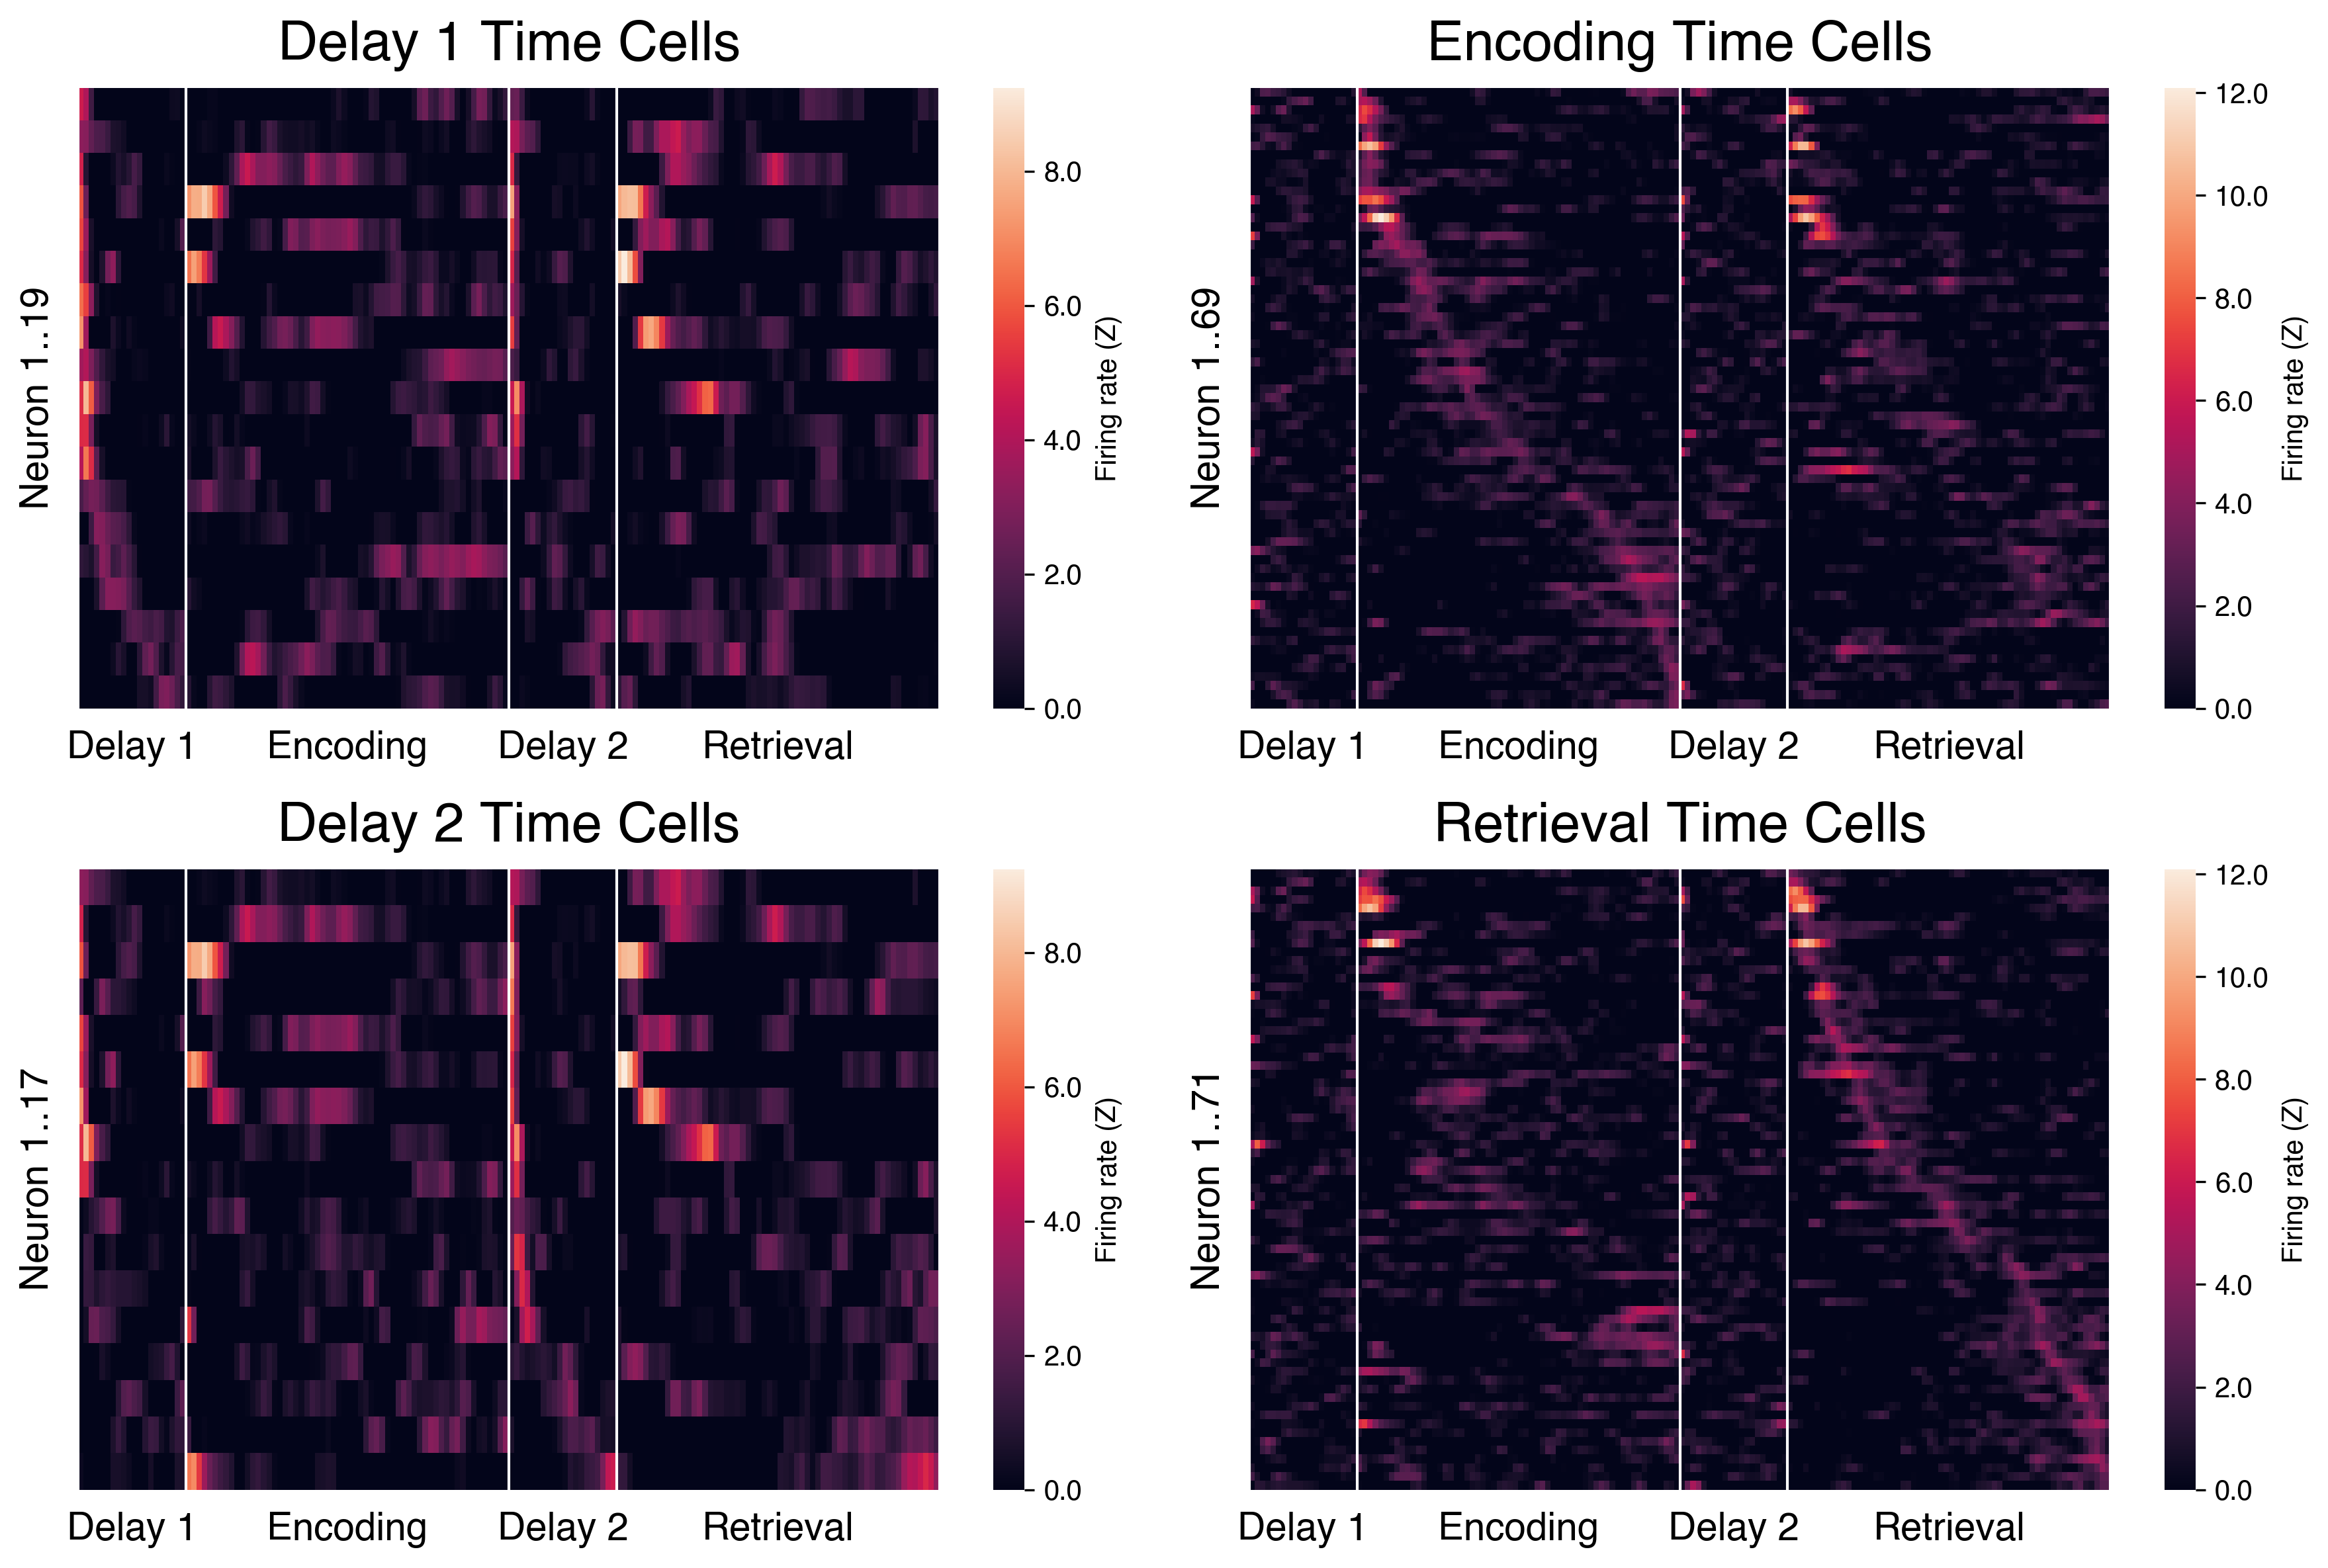

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), dpi=300)
ax = np.ravel(ax)

fontsize = od([('tick', 10),
               ('label', 14),
               ('annot', 12),
               ('fig', 20)])

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Delay1': 'Delay 1 Time Cells',
             'Delay2': 'Delay 2 Time Cells',
             'Encoding': 'Encoding Time Cells',
             'Retrieval': 'Retrieval Time Cells',
             'Delay1_Delay2': 'Delay Time Cells',
             'Encoding_Retrieval': 'Navigation Time Cells'}

# The trial phases we want to examine significant time cells for.
trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
n_neurons = []
for i, trial_phase in enumerate(trial_phases):
    neurons = list(sig_cells[trial_phase])
    n_neurons.append(len(neurons))
    if len(neurons) == 0:
        continue
    
    # Concat firing rates across trial phases, for each neuron.
    z_fr = []
    for neuron in neurons:
        df = mean_fr_by_time.query("(neuron=='{}')".format(neuron))
        # The trial phases we want to plot in the heatmap.
        game_states = [x for x in ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
                       if x in df['gameState'].tolist()]
        z_fr_ = []
        v_lines = [0]
        for game_state in game_states:
            z_fr_ += df.loc[df['gameState']==game_state, 'z_fr'].iloc[0].tolist()
            v_lines.append(len(z_fr_))
        z_fr.append(z_fr_)
    z_fr = np.array(z_fr)
    
    # Plot the firing rate heatmap.
#     vmax = np.max(mean_fr_by_time.query("(neuron=={}) & (gameState=='{}')".format(neurons, trial_phase))['z_fr'].tolist())
    vmax = np.max(z_fr)
    vmin = 0
    ax[i] = sns.heatmap(z_fr, ax=ax[i], vmin=vmin, vmax=vmax, cmap='rocket')
    for x in v_lines:
        ax[i].axvline(x=x, color='w', linewidth=1, alpha=1)
#     for iRoi in range(len(rois)):
#         ax.axhline(y=np.array(list(rois.values()))[:, 1][iRoi], color='w', linewidth=1.5, alpha=1)
    ax[i].tick_params(axis='both', which='both', length=0, pad=8)
    ax[i].set_xticks(v_lines[:-1] + (np.diff(v_lines) / 2))
    ax[i].set_xticklabels([ax_labels[x] for x in game_states], 
                          fontsize=fontsize['label'], rotation=0)
    ax[i].set_yticks([])
    ax[i].set_ylabel('Neuron 1..{}'.format(len(neurons)), fontsize=fontsize['label'], labelpad=8)
    ax[i].set_title(ax_titles[trial_phase], pad=10, fontsize=fontsize['fig'])
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize['tick'])
    cbar.set_ticks(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_ticklabels(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_label('Firing rate (Z)', fontsize=fontsize['tick'], labelpad=5)
    
fig.tight_layout(w_pad=1.25, h_pad=1.25)

if False:
    fstr = '-'.join(['{}{}'.format(n_neurons[ii], trial_phases[ii]) for ii in range(len(trial_phases))])
    fig.savefig(op.join(proj_dir, 'figs', 'all_time_cell_FRs_over_time-{}.png'.format(fstr)),
                format='png', dpi=300, bbox_inches='tight')

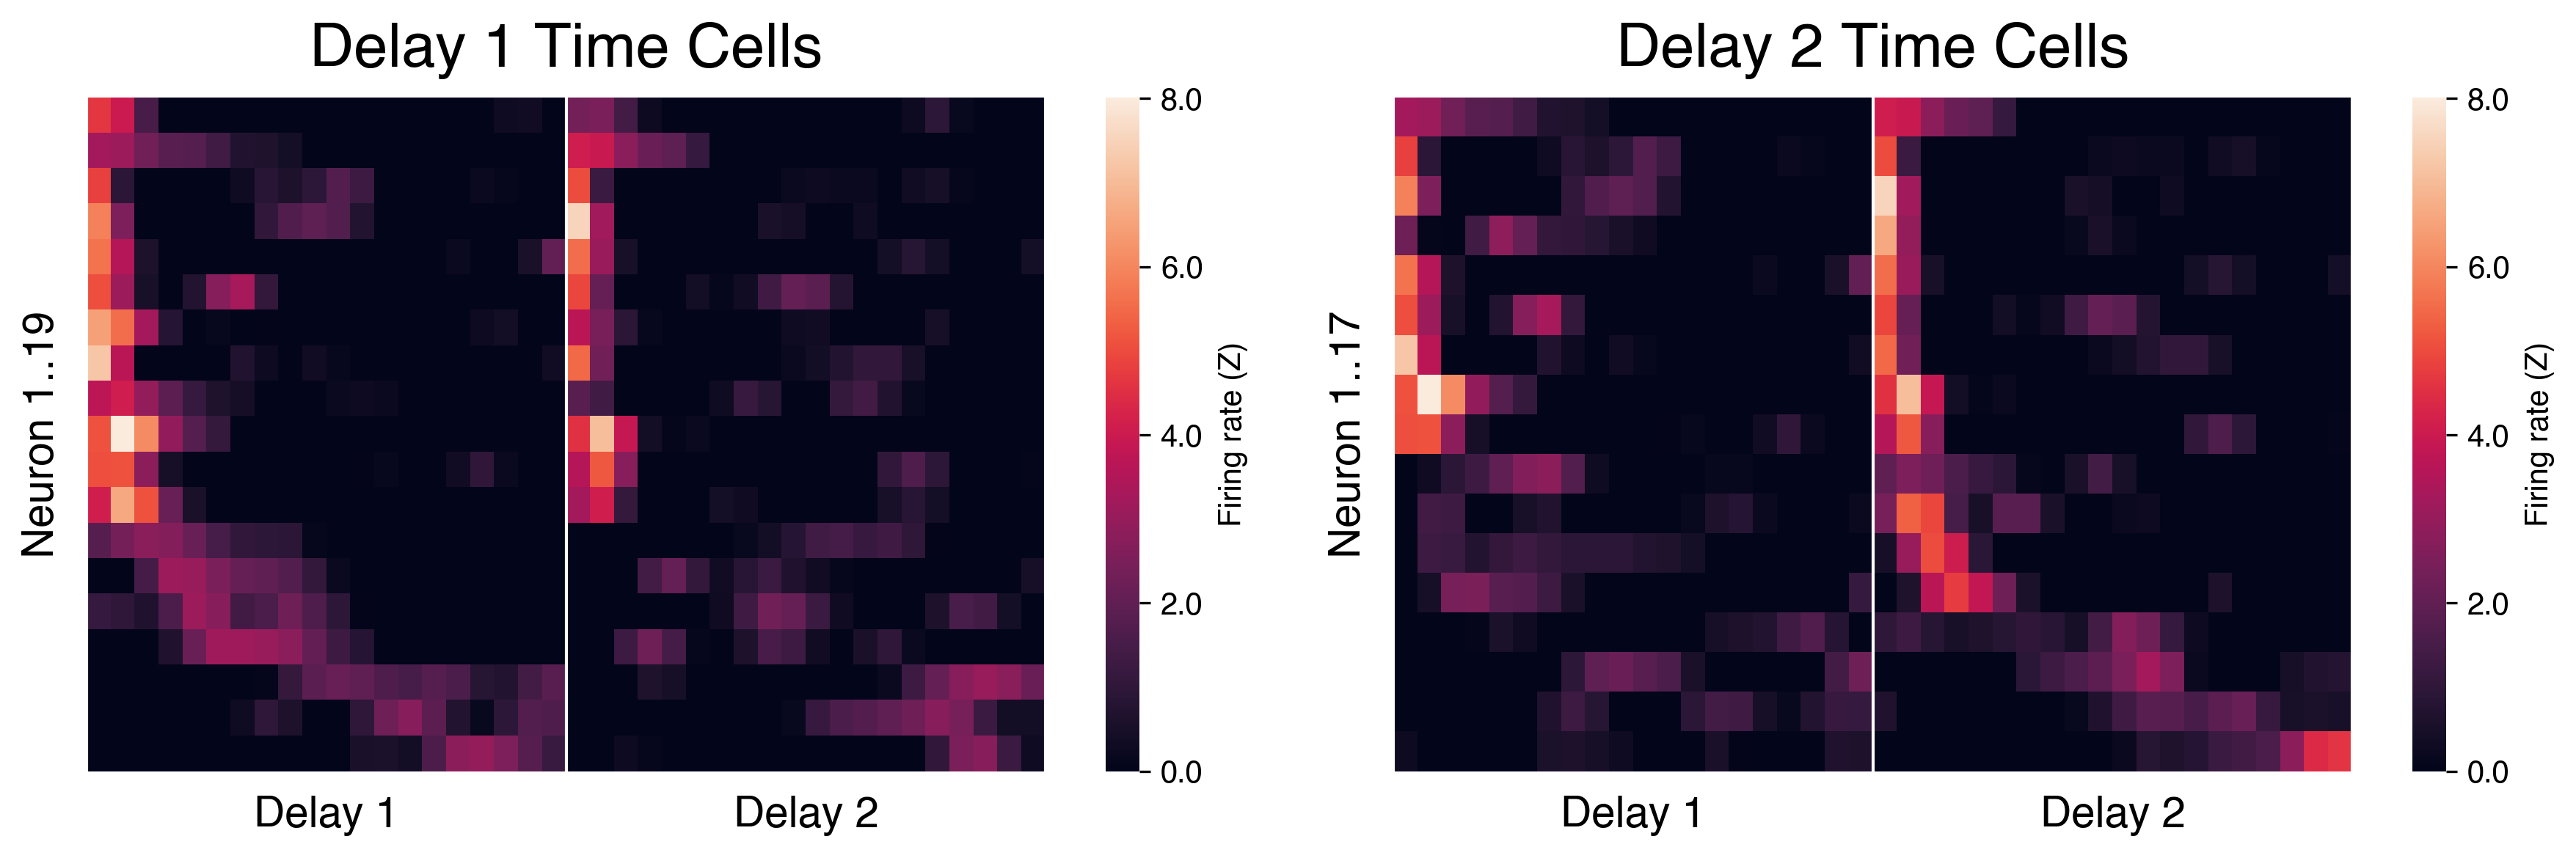

In [535]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

fontsize = od([('tick', 10),
               ('label', 14),
               ('annot', 12),
               ('fig', 20)])

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Delay1': 'Delay 1 Time Cells',
             'Delay2': 'Delay 2 Time Cells',
             'Encoding': 'Encoding Time Cells',
             'Retrieval': 'Retrieval Time Cells',
             'Delay1_Delay2': 'Delay Time Cells',
             'Encoding_Retrieval': 'Navigation Time Cells'}

# The trial phases we want to examine significant time cells for.
trial_phases = ['Delay1', 'Delay2']
n_neurons = []
neurons = list(np.unique([neuron for trial_phase in trial_phases for neuron in sig_cells[trial_phase]]))
vmax = np.max(mean_fr_by_time.query("(neuron=={}) & (gameState=={})".format(neurons, trial_phases))['z_fr'].tolist())
# vmin = np.min(mean_fr_by_time.query("(neuron=={}) & (gameState==['Delay1', 'Delay2'])".format(neurons))['z_fr'].tolist())
vmin = 0
for i, trial_phase in enumerate(trial_phases):
    neurons = list(sig_cells[trial_phase])
    n_neurons.append(len(neurons))
    if len(neurons) == 0:
        continue
    
    # Concat firing rates across trial phases, for each neuron.
    z_fr = []
    for neuron in neurons:
        df = mean_fr_by_time.query("(neuron=='{}')".format(neuron))
        # The trial phases we want to plot in the heatmap.
        game_states = ['Delay1', 'Delay2']
        z_fr_ = []
        v_lines = [0]
        for game_state in game_states:
            z_fr_ += df.loc[df['gameState']==game_state, 'z_fr'].iloc[0].tolist()
            v_lines.append(len(z_fr_))
        z_fr.append(z_fr_)
    z_fr = np.array(z_fr)
    
    # Plot the firing rate heatmap.
    ax[i] = sns.heatmap(z_fr, ax=ax[i], vmin=vmin, vmax=vmax, cmap='rocket')
    for x in v_lines:
        ax[i].axvline(x=x, color='w', linewidth=1, alpha=1)
    ax[i].tick_params(axis='both', which='both', length=0, pad=8)
    ax[i].set_xticks(v_lines[:-1] + (np.diff(v_lines) / 2))
    ax[i].set_xticklabels([ax_labels[x] for x in game_states], 
                          fontsize=fontsize['label'], rotation=0)
    ax[i].set_yticks([])
    ax[i].set_ylabel('Neuron 1..{}'.format(len(neurons)), fontsize=fontsize['label'], labelpad=8)
    ax[i].set_title(ax_titles[trial_phase], pad=10, fontsize=fontsize['fig'])
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize['tick'])
    cbar.set_ticks(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_ticklabels(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_label('Firing rate (Z)', fontsize=fontsize['tick'], labelpad=5)
    
fig.tight_layout(w_pad=1.25, h_pad=1.25)

if True:
    fstr = '-'.join(['{}{}'.format(n_neurons[ii], trial_phases[ii]) for ii in range(len(trial_phases))])
    fig.savefig(op.join(proj_dir, 'figs', 'all_time_cell_FRs_over_time-{}.png'.format(fstr)),
                format='png', dpi=300, bbox_inches='tight')

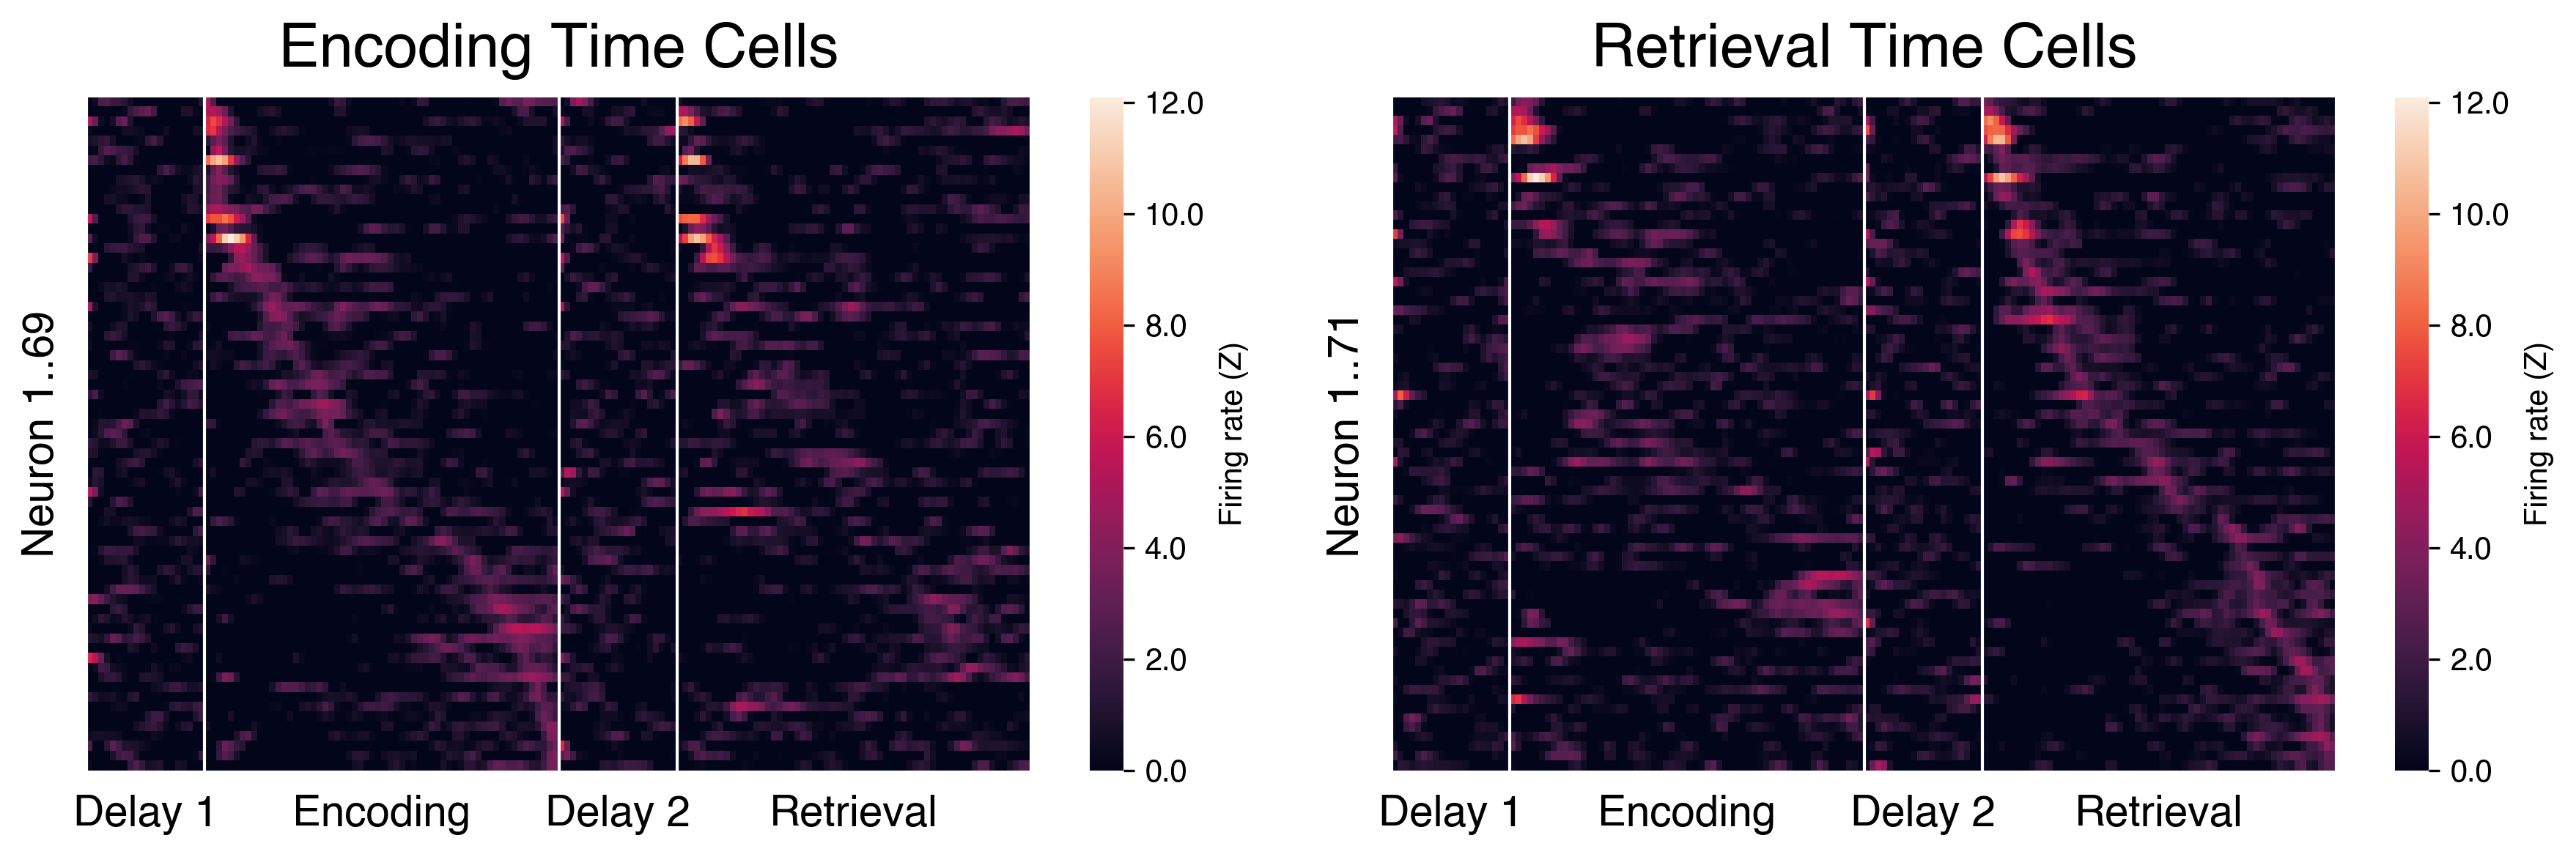

In [536]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

fontsize = od([('tick', 10),
               ('label', 14),
               ('annot', 12),
               ('fig', 20)])

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Delay1': 'Delay 1 Time Cells',
             'Delay2': 'Delay 2 Time Cells',
             'Encoding': 'Encoding Time Cells',
             'Retrieval': 'Retrieval Time Cells',
             'Delay1_Delay2': 'Delay Time Cells',
             'Encoding_Retrieval': 'Navigation Time Cells'}

# The trial phases we want to examine significant time cells for.
trial_phases = ['Encoding', 'Retrieval']
n_neurons = []
neurons = list(np.unique([neuron for trial_phase in trial_phases for neuron in sig_cells[trial_phase]]))
vmax = np.max(mean_fr_by_time.query("(neuron=={}) & (gameState=={})".format(neurons, trial_phases))['z_fr'].tolist())
# vmin = np.min(mean_fr_by_time.query("(neuron=={}) & (gameState==['Delay1', 'Delay2'])".format(neurons))['z_fr'].tolist())
vmin = 0
for i, trial_phase in enumerate(trial_phases):
    neurons = sig_cells[trial_phase]
    n_neurons.append(len(neurons))
    if len(neurons) == 0:
        continue
    
    # Concat firing rates across trial phases, for each neuron.
    z_fr = []
    for neuron in neurons:
        df = mean_fr_by_time.query("(neuron=='{}')".format(neuron))
        # The trial phases we want to plot in the heatmap.
        game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
        z_fr_ = []
        v_lines = [0]
        for game_state in game_states:
            z_fr_ += df.loc[df['gameState']==game_state, 'z_fr'].iloc[0].tolist()
            v_lines.append(len(z_fr_))
        z_fr.append(z_fr_)
    z_fr = np.array(z_fr)
    
    # Plot the firing rate heatmap.
    ax[i] = sns.heatmap(z_fr, ax=ax[i], vmin=vmin, vmax=vmax, cmap='rocket')
    for x in v_lines:
        ax[i].axvline(x=x, color='w', linewidth=1, alpha=1)
    ax[i].tick_params(axis='both', which='both', length=0, pad=8)
    ax[i].set_xticks(v_lines[:-1] + (np.diff(v_lines) / 2))
    ax[i].set_xticklabels([ax_labels[x] for x in game_states], 
                          fontsize=fontsize['label'], rotation=0)
    ax[i].set_yticks([])
    ax[i].set_ylabel('Neuron 1..{}'.format(len(neurons)), fontsize=fontsize['label'], labelpad=8)
    ax[i].set_title(ax_titles[trial_phase], pad=10, fontsize=fontsize['fig'])
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize['tick'])
    cbar.set_ticks(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_ticklabels(np.round(np.arange(vmin, vmax+1, 2), 2))
    cbar.set_label('Firing rate (Z)', fontsize=fontsize['tick'], labelpad=5)
    
fig.tight_layout(w_pad=1.25, h_pad=1.25)

if True:
    fstr = '-'.join(['{}{}'.format(n_neurons[ii], trial_phases[ii]) for ii in range(len(trial_phases))])
    fig.savefig(op.join(proj_dir, 'figs', 'all_time_cell_FRs_over_time-{}.png'.format(fstr)),
                format='png', dpi=300, bbox_inches='tight')

In [531]:
# # How correlated are the maximum firing times, across significant neurons,
# # between Delay 1 and Delay 2 and between Encoding and Retrieval?
# union = True

# if union:
#     delay_cells = np.array(list(np.unique([neuron for trial_phase in ['Delay1', 'Delay2'] 
#                                            for neuron in sig_cells[trial_phase]])))
#     nav_cells = np.array(list(np.unique([neuron for trial_phase in ['Encoding', 'Retrieval'] 
#                                          for neuron in sig_cells[trial_phase]])))
    
# else:  # intersection
#     delay_cells = np.array([cell for cell in list(sig_cells['Delay1']) 
#                             if cell in list(sig_cells['Delay2'])])
#     nav_cells = np.array([cell for cell in list(sig_cells['Encoding']) 
#                           if cell in list(sig_cells['Retrieval'])])

# print('Delay cells (n={})'.format(len(delay_cells)), 
#       stats.linregress([mean_fr_by_time.query("(gameState=='Delay1') & (neuron=='{}')".format(neuron))['z_fr_max_ind'].iloc[0] for neuron in delay_cells],
#                        [mean_fr_by_time.query("(gameState=='Delay2') & (neuron=='{}')".format(neuron))['z_fr_max_ind'].iloc[0] for neuron in delay_cells]),
#       sep='\n', end='\n\n')

# print('Navigation cells (n={})'.format(len(nav_cells)), 
#       stats.linregress([mean_fr_by_time.query("(gameState=='Encoding') & (neuron=='{}')".format(neuron))['z_fr_max_ind'].iloc[0] for neuron in nav_cells],
#                        [mean_fr_by_time.query("(gameState=='Retrieval') & (neuron=='{}')".format(neuron))['z_fr_max_ind'].iloc[0] for neuron in nav_cells]),
#       sep='\n', end='\n\n')

Delay cells (n=28)
LinregressResult(slope=0.870888998845456, intercept=0.5879597558964216, rvalue=0.852849645822917, pvalue=8.252411233424374e-09, stderr=0.10456934853891905)

Navigation cells (n=98)
LinregressResult(slope=0.24553570155113646, intercept=21.156022566227676, rvalue=0.24253484891936733, pvalue=0.016119004380269, stderr=0.1002398712228589)



In [ ]:
# Plot mean +/- SEM firing rates over time (average across trials)
# for each significant time cell. Save these plots as a single pdf.
plot_z_fr = False
overwrite = False
save_output = True
# The trial phases we want to examine significant time cells for.
trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

# --------------------------
start_time = time()

# Make a list of significant neurons for each trial phase category.
sig_cells2 = od([])  # same as sig_cells, but different order
for trial_phase in trial_phases:
    sig_cells2[trial_phase] = np.array(mean_fr_by_time.query("(sig_fdr==True) & (gameState=='{}')".format(trial_phase))
                                                      .sort_values(['subj', 'z_fr_max_ind', 'hemroi'])['neuron'].tolist())

# Map each neuron to a string of all trial phases
# for which its firing rate is sigificantly time-modulated.
neurons = []
for trial_phase in ['Delay1', 'Delay2', 'Encoding', 'Retrieval']:
    neurons += [neuron for neuron in sig_cells2[trial_phase] 
                if neuron not in neurons]
neuron_sig_phases = {neuron: 'sig_' + '_'.join([trial_phase for trial_phase in trial_phases 
                                                if neuron in list(sig_cells2[trial_phase])])
                     for neuron in neurons}

# Load the output file if it exists.
if plot_z_fr:
    output_f = op.join(proj_dir, 'figs', 'single_cell_mean_ZFRs-500ms_bins-{}_neurons.pdf'.format(len(neurons)))
else:
    output_f = op.join(proj_dir, 'figs', 'single_cell_mean_FRs-500ms_bins-{}_neurons.pdf'.format(len(neurons)))
if op.exists(output_f) and not overwrite:
    raise AssertionError('Output file already exists.')

# Generate plots.
fontsize = od([('tick', 16),
               ('label', 18),
               ('annot', 16),
               ('fig', 20)])
ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
fig, ax = plt.subplots(4, 1, figsize=(12, 16), dpi=300)
ax = np.ravel(ax)
with PdfPages(output_f) as pdf:
    for iNeuron in range(len(neurons)):
        neuron = neurons[iNeuron]
        i = iNeuron % 4
        
        subj_sess, chan, unit = mean_fr_by_time.query("(neuron=='{}')".format(neuron)).iloc[0][['subj_sess', 'chan', 'unit']]
        
        if plot_z_fr:
            # Load mean FR by time results.
            mean_fr_by_time_ = mean_fr_by_time.query("(neuron=='{}')".format(neuron))
        else:
            # Load the full FR by time bin results.
            fr_by_time_f = op.join(proj_dir, 'analysis', 'fr_by_time_bin', '{}-CSC{}-unit{}-event_fr.pkl')
            fr_by_time = dio.open_pickle(fr_by_time_f.format(subj_sess, chan, unit))['event_times']

        # Load the neuron's original spike data.
        spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
        spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))
        
        # The trial phases we want to plot.
        game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
        
        fr_mean = []
        fr_sem = []
        v_lines = [0]    
        if plot_z_fr:
            z_fr = []
            for game_state in game_states:
                z_fr += mean_fr_by_time_.loc[mean_fr_by_time_['gameState']==game_state, 'z_fr'].iloc[0].tolist()
                v_lines.append(len(z_fr))
            z_fr = np.array(z_fr)
        else:
            for game_state in game_states:
                fr_arr = np.array(fr_by_time.query("(gameState=='{}')".format(game_state))['fr'].tolist())
                fr_mean += list(np.mean(fr_arr, axis=0))
                fr_sem += list(stats.sem(fr_arr, axis=0))
                v_lines.append(len(fr_mean))
            fr_mean = np.array(fr_mean)
            fr_sem = np.array(fr_sem)

        for ii in range(len(v_lines)-1):
            x_start, x_stop = v_lines[ii], v_lines[ii+1]
            if plot_z_fr:
                ax[i].plot(np.arange(x_start, x_stop) + 0.5, z_fr[x_start:x_stop], linewidth=2, color=colors[1])
            else:
                ax[i].fill_between(np.arange(x_start, x_stop) + 0.5, fr_mean[x_start:x_stop] + fr_sem[x_start:x_stop], 
                                   fr_mean[x_start:x_stop] - fr_sem[x_start:x_stop], alpha=0.3, color=colors[1], linewidth=0)
                ax[i].plot(np.arange(x_start, x_stop) + 0.5, fr_mean[x_start:x_stop], linewidth=2, color=colors[1])
        for x in v_lines:
            ax[i].axvline(x=x, color='k', linewidth=0.8)
        ax[i].axhline(y=0, color='k', linewidth=0.8, zorder=0)
        ax[i].set_xlim([0, len(fr_mean)+0.5])
        ax[i].set_xticks(np.arange(0, len(fr_mean)+1, 20))
        ax[i].set_xticklabels([np.int(x/2) for x in np.arange(0, len(fr_mean)+1, 20)], fontsize=fontsize['tick'])
        if i == 0:
            ax[i].set_xlabel('Time (s)', fontsize=fontsize['label'], labelpad=8)

        if plot_z_fr:
            if i == 0:
                ax[i].set_ylabel('Firing rate (Z)', fontsize=fontsize['label'], labelpad=8)
            ymax = np.ceil(np.max(np.abs(z_fr)))
            if ymax % 2 == 1:
                ymax += 1
            ymin = -ymax
            yticks = np.linspace(ymin, ymax, 5, dtype=np.int)
        else:
            if i == 0:
                ax[i].set_ylabel('Firing rate (Hz)', fontsize=fontsize['label'], labelpad=8)
            ymax = np.ceil(np.max(fr_mean + fr_sem))
            ymin = np.floor(np.min(fr_mean - fr_sem))
            yticks = np.round(np.linspace(ymin, ymax, 5), 1)
        ax[i].set_ylim([ymin, ymax])
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels(yticks, fontsize=fontsize['tick'])
        ax_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 
                                                     neuron_sig_phases[neuron].replace('_', ', ').replace('sig, ', 'Sig. '))
        ax[i].set_title(ax_title, loc='left', pad=20, fontsize=fontsize['fig'])
        if i == 0:
            annot_y = ymax
            annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
            for ii in range(len(annot_x)):
                ax[i].annotate(ax_labels[game_states[ii]], (annot_x[ii], annot_y), ha='center', va='top', fontsize=fontsize['annot'])
            
        if (iNeuron % 4 == 3) and (iNeuron + 1 < len(neurons)):
            fig.tight_layout(h_pad=1.5, w_pad=1.25)
            pdf.savefig(fig, bbox_inches='tight', pad_inches=1)
            plt.close(fig)
            fig, ax = plt.subplots(4, 1, figsize=(12, 16), dpi=300)
            ax = np.ravel(ax)
            
    fig.tight_layout(h_pad=1.5, w_pad=1.25)
    pdf.savefig(fig, bbox_inches='tight', pad_inches=1)
        
print('Done in {:.2f}s'.format(time() - start_time))

Done in 60.86s


In [22]:
def plot_fr_over_trial(neuron,
                       ax=None,
                       plot_labels=True,
                       plot_title=True,
                       proj_dir='/home1/dscho/projects/time_cells'):
    """Plot mean +/- SEM firing rates over time (average across trials)."""
    subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
    game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    
    fontsize = od([('tick', 12),
                   ('label', 16),
                   ('annot', 14),
                   ('fig', 16)])
    ax_labels = {'Delay1': 'Delay 1',
                 'Delay2': 'Delay 2',
                 'Encoding': 'Encoding',
                 'Retrieval': 'Retrieval'}

    # Load the neuron's original spike data.
    spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
    spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))
    
    fr_mean = []
    fr_sem = []
    v_lines = [0]    
    for game_state in game_states:
        qry = "(gameState=='{}') & (testvar=='time') & (full==['time', 'full']) & (subj_sess_unit=='{}')"
        fr_arr = ols_pairs.query(qry.format(game_state, neuron)).iloc[0]['spike_mat']
        fr_mean += list(np.mean(fr_arr, axis=0))
        fr_sem += list(stats.sem(fr_arr, axis=0))
        v_lines.append(len(fr_mean))
    fr_mean = np.array(fr_mean)
    fr_sem = np.array(fr_sem)

    for ii in range(len(v_lines)-1):
        x_start, x_stop = v_lines[ii], v_lines[ii+1]
        ax.fill_between(np.arange(x_start, x_stop) + 0.5, fr_mean[x_start:x_stop] + fr_sem[x_start:x_stop], 
                           fr_mean[x_start:x_stop] - fr_sem[x_start:x_stop], alpha=0.3, color=colors[1], linewidth=0)
        ax.plot(np.arange(x_start, x_stop) + 0.5, fr_mean[x_start:x_stop], linewidth=1, color=colors[1])
    for x in v_lines:
        ax.axvline(x=x, color='k', linewidth=0.8)
    ax.axhline(y=0, color='k', linewidth=0.8, zorder=0)
    ax.set_xlim([0, len(fr_mean)+0.5])
    ax.set_xticks(np.arange(0, len(fr_mean)+1, 20))
    ax.set_xticklabels([np.int(x/2) for x in np.arange(0, len(fr_mean)+1, 20)], fontsize=fontsize['tick'])
    if plot_labels:
        ax.set_ylabel('Firing rate (Hz)', fontsize=fontsize['label'], labelpad=8)
    ymax = np.ceil(np.max(fr_mean + fr_sem))
    ymin = np.floor(np.min(fr_mean - fr_sem))
    yticks = np.round(np.linspace(ymin, ymax, 5), 1)
    ax.set_ylim([ymin, ymax])
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=fontsize['tick'])
    if plot_labels:
        ax.text(0.5, -0.26, 'Time (s)', ha='center', va='center', 
                fontsize=fontsize['annot'], transform=ax.transAxes)
        annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
        for ii in range(len(annot_x)):
            ax.text(annot_x[ii]/v_lines[-1], -0.16, ax_labels[game_states[ii]], ha='center', 
                    va='center', fontsize=fontsize['annot'], transform=ax.transAxes)
    if plot_title:
        ax_title = '{}, {}, ch{}, unit{}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'])
        ax.set_title(ax_title, loc='left', pad=20, fontsize=fontsize['fig'])
        
    return ax

In [40]:
def trial_raster(neuron, 
                 ax=None,
                 plot_labels=True,
                 plot_title=True,
                 proj_dir='/home1/dscho/projects/time_cells',
                 **kws):
    """Plot spike rasters for each trial, and return ax."""
    subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
    events = events_proc.load_events(subj_sess, verbose=False)
    game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
    dsr = 100  # downsampling rate in Hz
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    
    fontsize = od([('tick', 12),
                   ('label', 16),
                   ('annot', 14),
                   ('fig', 16)])
    ax_labels = {'Delay1': 'Delay 1',
                 'Delay2': 'Delay 2',
                 'Encoding': 'Encoding',
                 'Retrieval': 'Retrieval'}
    
    # Load the neuron's original spike data.
    spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
    spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))

    dsr_ratio = np.int(1000 / dsr)  # spike and event times start out in ms
    game_state_durs_ = {'Delay1': np.int(1e4 / dsr_ratio),
                         'Encoding': np.int(3e4 / dsr_ratio),
                         'Delay2': np.int(1e4 / dsr_ratio),
                         'Retrieval': np.int(3e4 / dsr_ratio)}
    
    # For each trial, convert spike times to a downsampled spike train.
    game_state_durs = od([])
    spike_train = od([])
    for game_state in game_states:
        spike_train[game_state] = []
        game_state_times = np.array(events.event_times.query("(gameState=='{}')".format(game_state))['time'].tolist())
        event_stops = []
        for iTrial in range(game_state_times.shape[0]):
            # Find spike times within each event window.
            event_start, event_stop = game_state_times[iTrial, :]
            spike_times = spikes['spike_times'][(spikes['spike_times'] >= event_start) & (spikes['spike_times'] < event_stop)]

            # Subtract the event start time.
            spike_times -= event_start
            event_stop -= event_start

            # Downsample times.
            spike_times = np.rint(spike_times / dsr_ratio).astype(np.int)
            event_stop = np.rint(event_stop / dsr_ratio).astype(np.int)
            if len(spike_times) > 0:
                if spike_times[-1] == event_stop:
                    spike_times[-1] -= 1

            # Convert spike times to spike train.
            event_stops.append(event_stop)
            spike_train_ = np.zeros(event_stop, dtype=np.bool)
            spike_train_[spike_times] = 1
            spike_train[game_state].append(spike_train_)

        # Trim spike trains to equal lengths.
        game_state_durs[game_state] = np.min(event_stops + [game_state_durs_[game_state]])
        spike_train[game_state] = np.array([x[:game_state_durs[game_state]] 
                                             for x in spike_train[game_state]])

    # Concentate spikes across trial phases.
    spike_train = np.concatenate(list(spike_train.values()), axis=-1)
    v_lines = np.cumsum([0] + list(game_state_durs.values()))
    
    shp = spike_train.shape
    ax = sns.heatmap(np.flip(spike_train, axis=0), cbar=False, cmap='binary', ax=ax)
    for x in v_lines[1:-1]:
        ax.axvline(x=x, color='k', linewidth=0.8)

    xticks = np.arange(0, shp[1] + 1, 10 * dsr)
    ax.set_xlim([0, shp[1]])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0, (v_lines[-1]/dsr)+1, 10, dtype=np.int), 
                          fontsize=fontsize['tick'], rotation=0)
    yticks = np.arange(0, shp[0], 6, dtype=np.int)
    if 'ymin' in kws and 'ymax' in kws:
        ax.set_ylim([ymin, ymax])
    ax.set_yticks(yticks+0.5)
    ax.set_yticklabels(yticks[::-1]+6, fontsize=fontsize['tick'], rotation=0)
    if plot_labels:
        ax.set_ylabel('Trial', fontsize=fontsize['label'], labelpad=8) 
        ax.text(0.5, -0.26, 'Time (s)', ha='center', va='center', 
                fontsize=fontsize['annot'], transform=ax.transAxes)
        annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
        for ii in range(len(annot_x)):
            ax.text(annot_x[ii]/v_lines[-1], -0.16, ax_labels[game_states[ii]], ha='center', 
                    va='center', fontsize=fontsize['annot'], transform=ax.transAxes)
    if plot_title:
        ax_title = '{}, {}, ch{}, unit{}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'])
        ax.set_title(ax_title, loc='left', pad=20, fontsize=fontsize['fig'])
    
    return ax

In [38]:
neuron_sig_phases = ols_pairs.query("(testvar=='time') & (full==['time', 'full']) & (sig_holm==True)").groupby('subj_sess_unit')['gameState'].apply(list)

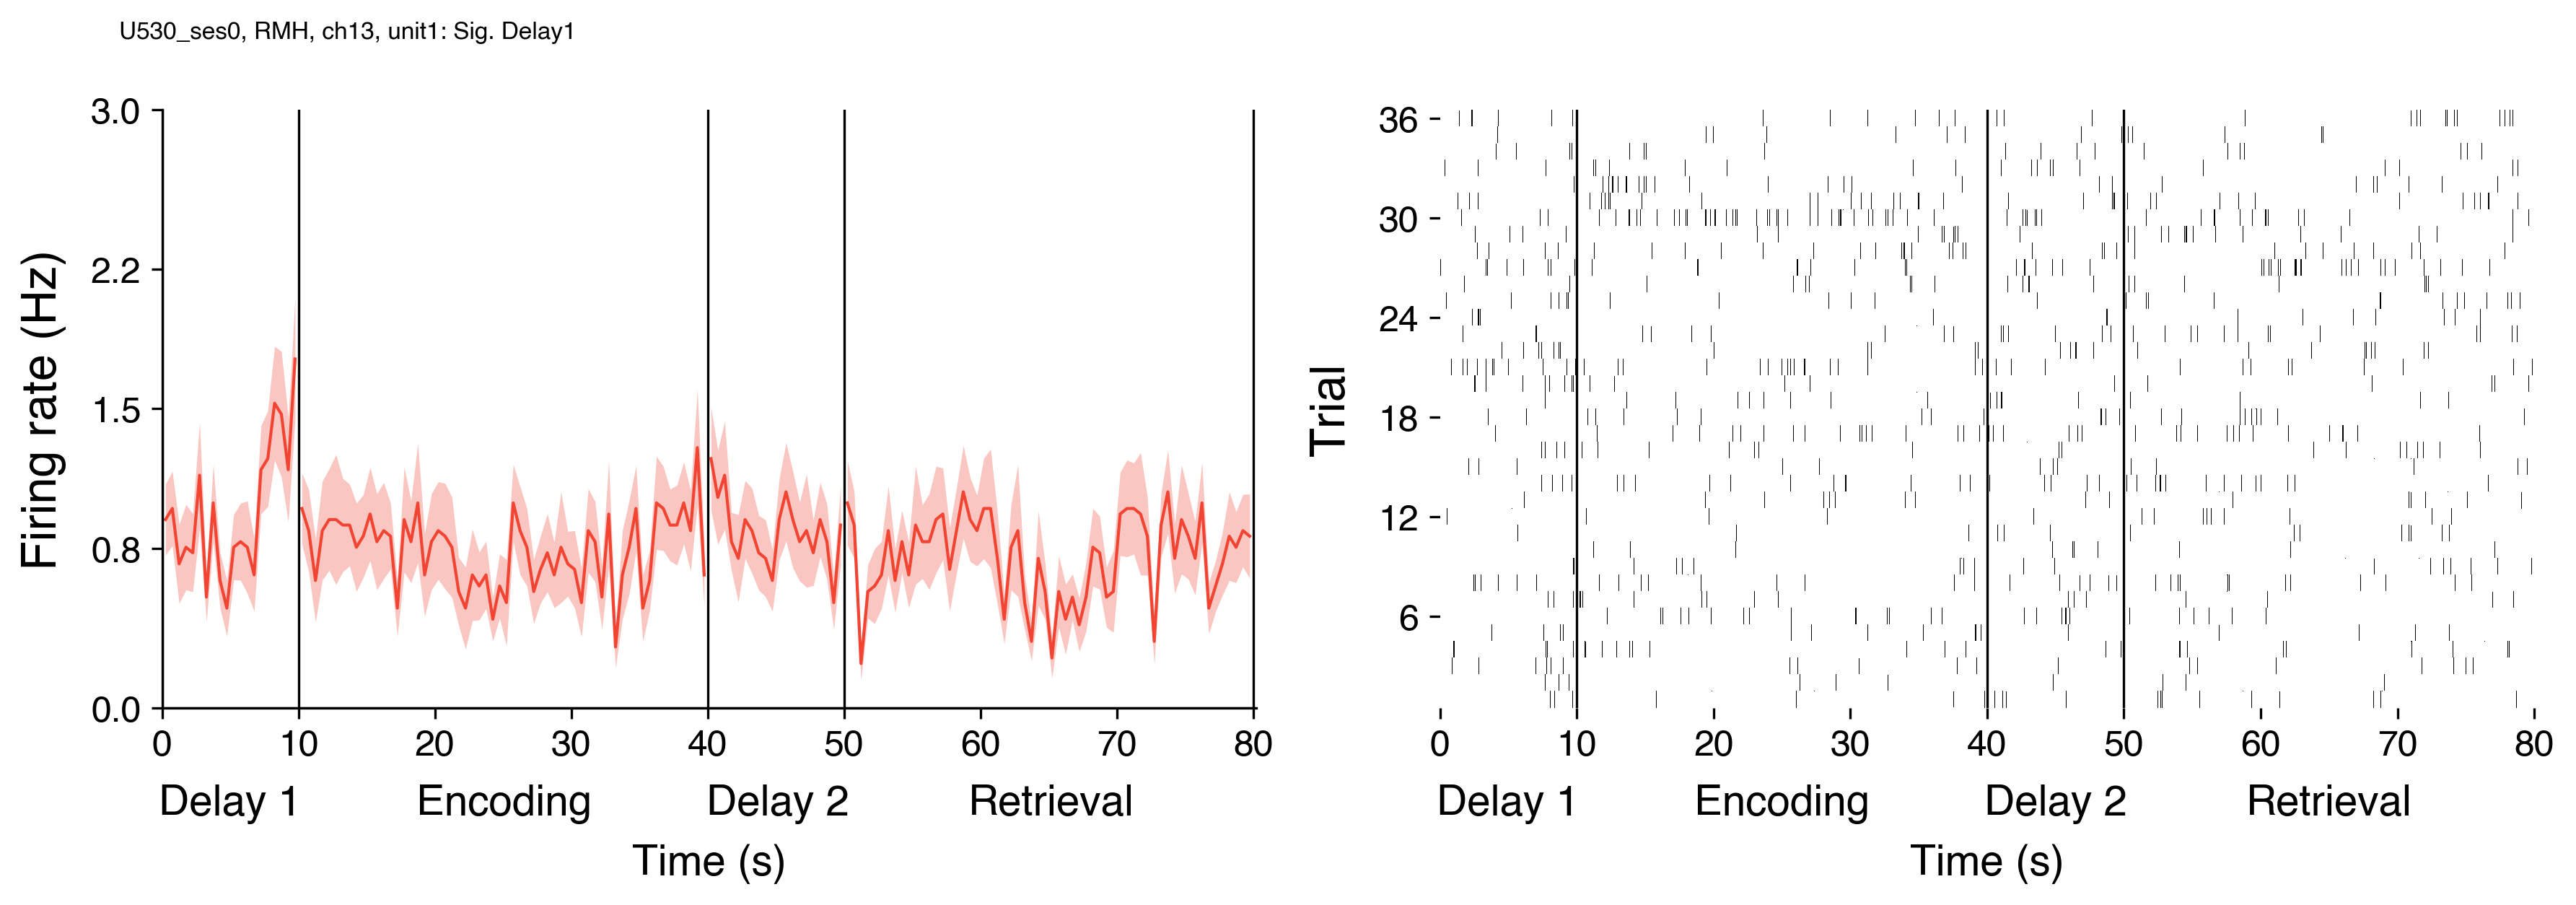

In [51]:
savefig = 0
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}

fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

neurons = list(ols_pairs['subj_sess_unit'].unique())
neuron = neurons[neurons.index('U530_ses0-13-1')]

i = 0
ax[i] = plot_fr_over_trial(neuron, ax=ax[i], plot_title=False)

i = 1
ax[i] = trial_raster(neuron, ax=ax[i], plot_title=False)

subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))
if neuron in neuron_sig_phases:
    fig_title = '{}, {}, ch{}, unit{}: Sig. {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 
                                                       ', '.join(neuron_sig_phases[neuron]))
else:
    fig_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 'Insig.')
fig.suptitle(fig_title, x=0.05, y=1.05, ha='left', fontsize=font['fig'])
fig.tight_layout(w_pad=1.2)

if savefig:
    fig.savefig(op.join(proj_dir, 'figs', 'firing_rate_and_raster-{}-CSC{}-unit{}.pdf'.format(subj_sess, chan, unit)),
                format='pdf', bbox_inches='tight')

In [29]:
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

# --------------------------
start_time = time()

# Make a list of significant neurons for each trial phase category.
sig_cells2 = od([])  # same as sig_cells, but different order
for game_state in game_states:
    sig_cells2[game_state] = np.array(mean_fr_by_time.query("(sig_fdr==True) & (gameState=='{}')".format(game_state))
                                                      .sort_values(['subj', 'z_fr_max_ind', 'hemroi'])['neuron'].tolist())

# Map each neuron to a string of all trial phases
# for which its firing rate is sigificantly time-modulated.
neurons = []
for game_state in ['Delay1', 'Delay2', 'Encoding', 'Retrieval']:
    neurons += [neuron for neuron in sig_cells2[game_state] 
                if neuron not in neurons]
neuron_sig_phases = {neuron: 'sig_' + '_'.join([game_state for game_state in game_states 
                                                if neuron in list(sig_cells2[game_state])])
                     for neuron in neurons}

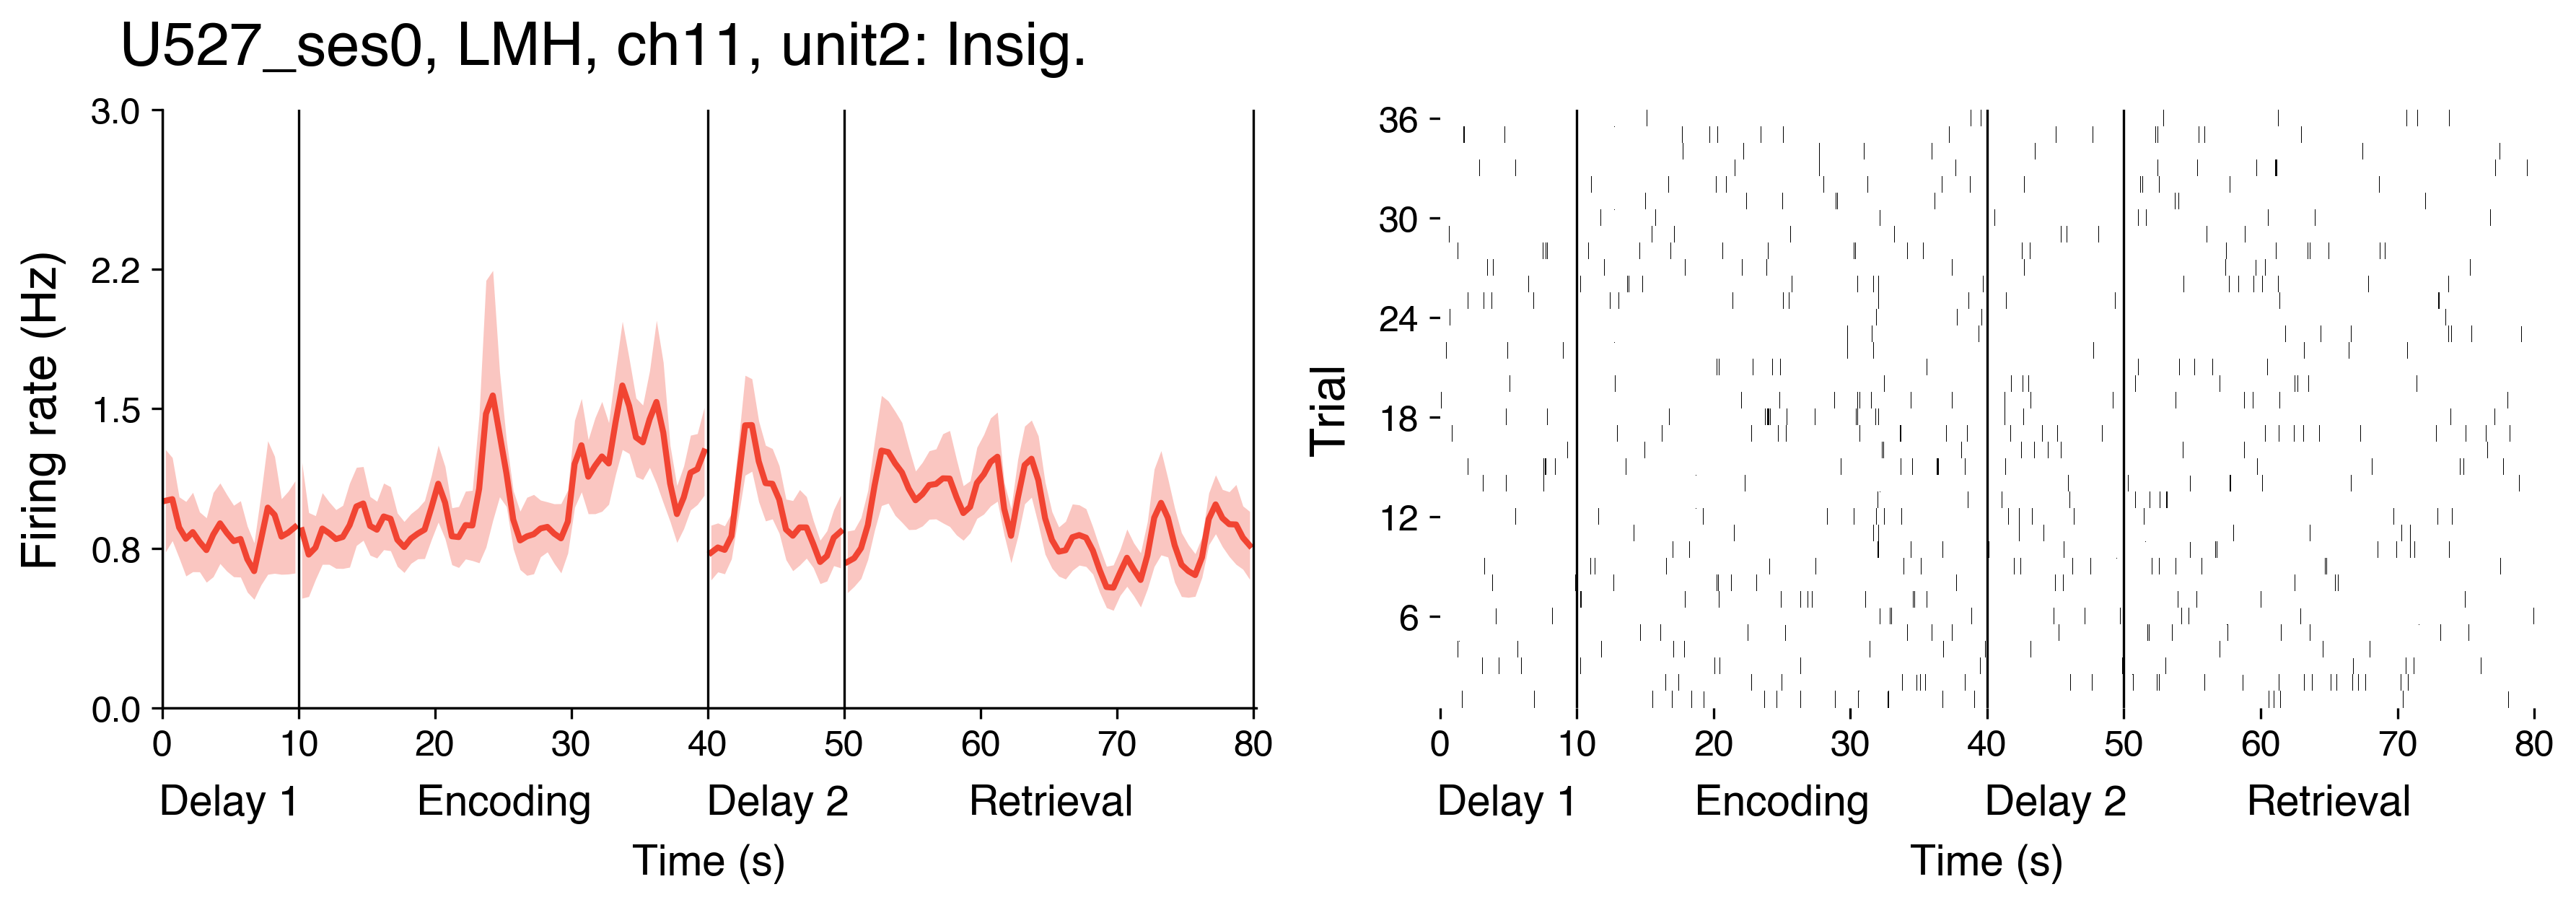

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

neurons = list(ols_pairs['subj_sess_unit'].unique())
neuron = neurons[neurons.index('U527_ses0-ch11-2')]

i = 0
ax[i] = plot_fr_over_trial(neuron, ax=ax[i], plot_title=False)

i = 1
ax[i] = trial_raster(neuron, ax=ax[i], plot_title=False)

subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))
if neuron in neuron_sig_phases:
    fig_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 
                                                  neuron_sig_phases[neuron].replace('_', ', ').replace('sig, ', 'Sig. '))
else:
    fig_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 'Insig.')
fig.suptitle(fig_title, x=0.05, y=1.05, ha='left', fontsize=fontsize['fig'])
fig.tight_layout(w_pad=1.2)

if False:
    fig.savefig(op.join(proj_dir, 'figs', 'firing_rate_and_raster-{}-CSC{}-unit{}.pdf'.format(subj_sess, chan, unit)),
                format='pdf', bbox_inches='tight')

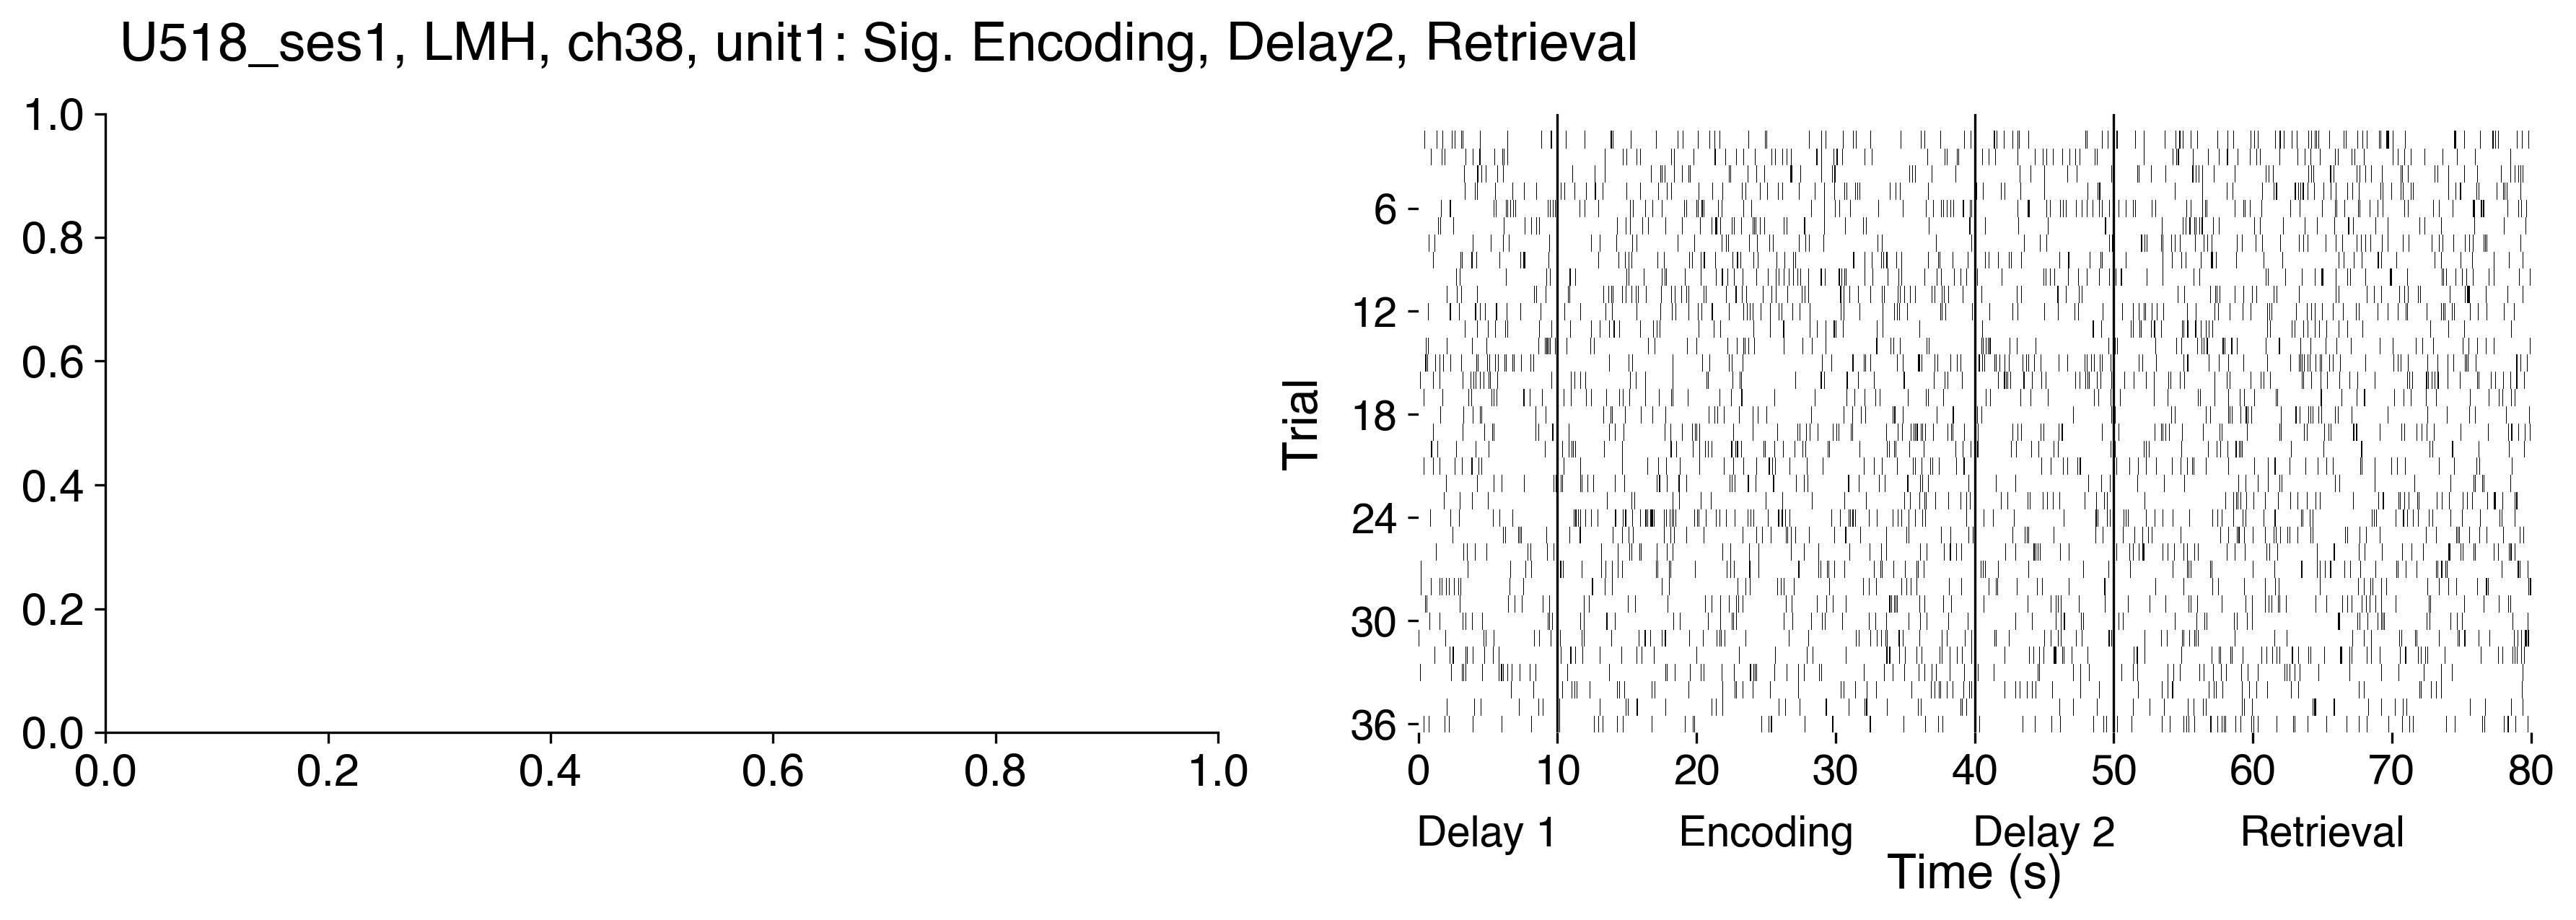

In [751]:
# Plot spike rasters for a neuron, across trials.
neuron = neurons[neurons.index('U518_ses1-ch38-1')]
trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
dsr = 100  # downsampling rate in Hz
sigma = 500

# -----------------------------
subj_sess, chan, unit = mean_fr_by_time.query("(neuron=='{}')".format(neuron)).iloc[0][['subj_sess', 'chan', 'unit']]

# Load the full FR by time bin results.
fr_by_time_f = op.join(proj_dir, 'analysis', 'fr_by_time_bin', '{}-CSC{}-unit{}-event_fr.pkl')
fr_by_time = dio.open_pickle(fr_by_time_f.format(subj_sess, chan, unit))['event_times']

# Load the neuron's original spike data.
spikes_f = op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))

dsr_ratio = np.int(1000 / dsr)  # spike and event times start out in ms
trial_phase_durs_ = {'Delay1': np.int(1e4 / dsr_ratio),
                     'Encoding': np.int(3e4 / dsr_ratio),
                     'Delay2': np.int(1e4 / dsr_ratio),
                     'Retrieval': np.int(3e4 / dsr_ratio)}

# For each trial, convert spike times to a downsampled spike train.
trial_phase_durs = od([])
spike_train = od([])
for trial_phase in trial_phases:
    spike_train[trial_phase] = []
    
    # Skip over partial trials.
    trial_counts = fr_by_time.query("(gameState=={})".format(trial_phases)).groupby('trial').size()
    include_trials = trial_counts[trial_counts==len(trial_phases)].index.tolist()
    
    trial_phase_times = np.array(fr_by_time.query("(gameState=='{}') & (trial=={})".format(trial_phase, include_trials))['time'].tolist())
    event_stops = []
    for iTrial in range(trial_phase_times.shape[0]):
        # Find spike times within each event window.
        event_start, event_stop = trial_phase_times[iTrial, :]
        spike_times = spikes['spike_times'][(spikes['spike_times'] >= event_start) & (spikes['spike_times'] < event_stop)]
        
        # Subtract the event start time.
        spike_times -= event_start
        event_stop -= event_start

        # Downsample times.
        spike_times = np.rint(spike_times / dsr_ratio).astype(np.int)
        event_stop = np.rint(event_stop / dsr_ratio).astype(np.int)
        if spike_times[-1] == event_stop:
            spike_times[-1] -= 1
            
        # Convert spike times to spike train.
        event_stops.append(event_stop)
        spike_train_ = np.zeros(event_stop, dtype=np.bool)
        spike_train_[spike_times] = 1
        spike_train[trial_phase].append(spike_train_)

    # Trim spike trains to equal lengths.
    trial_phase_durs[trial_phase] = np.min(event_stops + [trial_phase_durs_[trial_phase]])
    spike_train[trial_phase] = np.array([x[:trial_phase_durs[trial_phase]] 
                                         for x in spike_train[trial_phase]])

# Concentate spikes across trial phases.
spike_train = np.concatenate(list(spike_train.values()), axis=-1)

# Get the normalized firing rate.
# norm_fr = gaussian_filter1d(np.mean(spike_train, axis=0), sigma/dsr_ratio, mode='reflect', axis=-1) * (1e3/dsr_ratio)
# norm_fr = (norm_fr / np.max(norm_fr)) * 10

# Plot the spike rasters.
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)
ax = np.ravel(ax)

fontsize = od([('tick', 14),
               ('label', 16),
               ('annot', 14),
               ('fig', 18)])
ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
v_lines = np.cumsum([0] + list(trial_phase_durs.values()))

i = 1
shp = spike_train.shape
ax[i] = sns.heatmap(np.flip(spike_train, axis=0), cbar=False, cmap='binary', ax=ax[i])
# ax[i].plot(norm_fr, color=colors[1], alpha=0.8, linewidth=1)
for x in v_lines[1:-1]:
    ax[i].axvline(x=x, color='k', linewidth=0.8)

xticks = np.arange(0, shp[1] + 1, 10 * dsr)
ax[i].set_xlim([0, shp[1]])
ax[i].set_xticks(xticks)
ax[i].set_xticklabels(np.arange(0, (v_lines[-1]/dsr)+1, 10, dtype=np.int), 
                      fontsize=fontsize['tick'], rotation=0)
yticks = np.arange(0, shp[0], 6, dtype=np.int)
ax[i].set_ylim([ymin, ymax])
ax[i].set_yticks(yticks+0.5)
ax[i].set_yticklabels(yticks[::-1]+6, fontsize=fontsize['tick'], rotation=0)
if i == 1:
    ax[i].set_xlabel('Time (s)', fontsize=fontsize['label'], labelpad=20)
    ax[i].set_ylabel('Trial', fontsize=fontsize['label'], labelpad=8)

ax_title = '{}, {}, ch{}, unit{}: {}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'], 
                                             neuron_sig_phases[neuron].replace('_', ', ').replace('sig, ', 'Sig. '))
if i == 1:
    annot_y = ymin - 6
    annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
    for ii in range(len(annot_x)):
        ax[i].text(annot_x[ii], annot_y, ax_labels[game_states[ii]], 
                   ha='center', va='center', fontsize=fontsize['annot'])
        
fig.suptitle(ax_title, x=0.05, y=1.05, ha='left', fontsize=fontsize['fig'])
fig.tight_layout()

In [11]:
# start_time = time()

# # Load all time OLS result files.
# ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))
# print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

# warnings.filterwarnings('ignore')
# bad_files = []
# ols_pairs = pd.DataFrame([])
# for filename in ols_pairs_files:
#     try:
#         ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
#     except:
#         bad_files.append(filename)
# ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
# warnings.resetwarnings()

# # Restrict dataframe rows to delay periods.
# keep_cols = ['subj_sess', 'neuron', 'gameState', 'testvar', 'llf_full', 'lr', 'z_lr', 'emp_pval']
# ols_pairs = ols_pairs.query("(gameState==['Delay1', 'Delay2'])")[keep_cols].reset_index(drop=True)

# # Add new columns.
# roi_map = spike_preproc.roi_mapping(n=3)
# val_map = od([('hem', []),
#               ('roi', []),
#               ('roi_gen', []),
#               ('spike_mat'        , []),
#               ('mean_frs'         , []),
#               ('sem_frs'          , []),
#               ('fr_mean'          , []),
#               ('fr_max'           , []),
#               ('z_fr_max'         , []),
#               ('fr_max_ind'       , []),
#               ('inout_ratio'      , []),
#               ('sparsity'         , []),
#               ('z_mean_frs'       , []),
#               ('time_field_size'  , []),
#               ('time_field'       , []),
#               ('cutoff_fr'        , [])])

# for idx, row in ols_pairs.iterrows():
#     if 'event_spikes' not in dir():
#         event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
#     elif event_spikes.subj_sess != row['subj_sess']:
#         event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
#     hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
#     hem = hemroi[0]
#     roi = hemroi[1:]
#     roi_gen = roi_map.get(roi, np.nan)
#     spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
#     mean_frs = time_bin_analysis.get_mean_frs(spike_mat) * 2
#     sem_frs = time_bin_analysis.get_sem_frs(spike_mat) * 2
#     fr_mean = np.mean(mean_frs.values)
#     fr_max = np.max(mean_frs.values)
#     fr_max_ind = np.argmax(mean_frs.values)
#     sparsity = time_bin_analysis.get_sparsity(spike_mat)
#     cutoff_fr, z_mean_frs, time_field = time_bin_analysis.bootstrap_time_fields(spike_mat)
#     z_fr_max = np.max(z_mean_frs)
#     time_field_size = len(time_field)
#     time_field_vec = np.zeros(mean_frs.size)
#     time_field_vec[time_field] = 1
#     inout_ratio = np.mean(mean_frs[time_field_vec==1]) / np.mean(mean_frs[time_field_vec==0])
    
#     val_map['hem'].append(hem)
#     val_map['roi'].append(roi)
#     val_map['roi_gen'].append(roi_gen)
#     val_map['spike_mat'].append(spike_mat.values.tolist())
#     val_map['mean_frs'].append(mean_frs.tolist())
#     val_map['sem_frs'].append(sem_frs.tolist())
#     val_map['fr_mean'].append(fr_mean)
#     val_map['fr_max'].append(fr_max)
#     val_map['z_fr_max'].append(z_fr_max)
#     val_map['fr_max_ind'].append(fr_max_ind)
#     val_map['inout_ratio'].append(inout_ratio)
#     val_map['sparsity'].append(sparsity)
#     val_map['z_mean_frs'].append(z_mean_frs.tolist())
#     val_map['time_field_size'].append(time_field_size)
#     val_map['time_field'].append(time_field)
#     val_map['cutoff_fr'].append(cutoff_fr)

# ols_pairs.insert(0, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
# ols_pairs.insert(2, 'subj', ols_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
# ols_pairs.insert(4, 'hem', val_map['hem'])
# ols_pairs.insert(5, 'roi', val_map['roi'])
# ols_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
# for col_name in val_map:
#     if col_name not in ols_pairs:
#         ols_pairs[col_name] = val_map[col_name]
# roi_gen_cat = ['Hippocampus', 'MTL', 'Cortex']
# ols_pairs['roi_gen'] = ols_pairs['roi_gen'].astype(pd.CategoricalDtype(roi_gen_cat, ordered=True))


# # Test significance.
# alpha = 0.05
# ols_pairs['sig'] = False
# ols_pairs.loc[((ols_pairs['emp_pval']<alpha)), 'sig'] = True

# print('{} bad files'.format(len(bad_files)))
# print('ols_pairs:', ols_pairs.shape)

# print('Done in {:.1f}s'.format(time() - start_time))

Found OLS outputs for 420 neurons
Loading saved Events file
0 bad files
ols_pairs: (840, 27)
Done in 112.0s


In [4]:
table1 = (ols_pairs
          .groupby('roi_gen')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'subj_sess_unit': lambda x: len(np.unique(x))}))
table1.rename(columns={'subj': 'Subjects', 
                       'subj_sess': 'Sessions', 
                       'subj_sess_unit': 'Units'}, 
              inplace=True)
display(table1)
print('Subjects: {}'.format(len(ols_pairs['subj'].unique())),
      'Sessions: {}'.format(len(ols_pairs['subj_sess'].unique())),
      'Units: {}'.format(len(ols_pairs['subj_sess_unit'].unique())), sep='\n')

Subjects  Sessions  Units
roi_gen                               
Hippocampus         8        10     91
MTL                 8        10    192
Cortex              8        10    137

Subjects: 8
Sessions: 10
Units: 420


In [ ]:
table1 = (ols_pairs
          .groupby('roi_gen')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'subj_sess_unit': lambda x: len(np.unique(x))}))
table1.rename(columns={'subj': 'Subjects', 
                       'subj_sess': 'Sessions', 
                       'subj_sess_unit': 'Units'}, 
              inplace=True)
display(table1)
print('Subjects: {}'.format(len(ols_pairs['subj'].unique())),
      'Sessions: {}'.format(len(ols_pairs['subj_sess'].unique())),
      'Units: {}'.format(len(ols_pairs['subj_sess_unit'].unique())), sep='\n')

In [4]:
table1 = (ols_pairs
          .groupby('roi_gen')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'subj_sess_unit': lambda x: len(np.unique(x))}))
table1.rename(columns={'subj': 'Subjects', 
                       'subj_sess': 'Sessions', 
                       'subj_sess_unit': 'Units'}, 
              inplace=True)
display(table1)
print('Subjects: {}'.format(len(ols_pairs['subj'].unique())),
      'Sessions: {}'.format(len(ols_pairs['subj_sess'].unique())),
      'Units: {}'.format(len(ols_pairs['subj_sess_unit'].unique())), sep='\n')

Subjects  Sessions  Units
roi_gen                               
Hippocampus         8        10     91
MTL                 8        10    192
Cortex              8        10    137

Subjects: 8
Sessions: 10
Units: 420


In [5]:
# How many neurons in each region, for each subject?
df = ols_pairs.groupby(['roi_gen', 'subj']).agg({'subj_sess_unit': lambda x: len(np.unique(x))}).reset_index()
df['roi_gen'] = df['roi_gen'].astype(pd.CategoricalDtype(['Hippocampus', 'MTL', 'Cortex'], ordered=True))
df = pd.pivot(df, index='roi_gen', columns='subj', values='subj_sess_unit')
df

subj         U518  U521  U526  U527  U530  U532  U536  U537
roi_gen                                                    
Hippocampus    19     5    11     9    11    24     9     3
MTL            19    19     6    16    61    25    37     9
Cortex         41     6     8     8    30    16    27     1

In [6]:
def mean_sum(val):
    return '{}/{} ({:.1%})'.format(np.sum(val), len(val), np.mean(val))

ols_pairs.query("(gameState==['Delay1', 'Delay2'])").groupby('gameState').agg({'sig_holm': mean_sum})

sig_holm
gameState                
Delay1     74/420 (17.6%)
Delay2     63/420 (15.0%)

In [96]:
alpha = 0.05
for game_state in ['Delay1', 'Delay2']:
    print(game_state, '-' * 6, sep='\n')
    n_sig = ols_pairs.query("(gameState=='{}') & (sig_holm==True)".format(game_state))['subj_sess_unit'].unique().size
    n_units = ols_pairs.query("(gameState=='{}')".format(game_state))['subj_sess_unit'].unique().size
    pval = stats.binom_test(n_sig, n_units, alpha)
    sig = pval < alpha
    print('{}/{} ({:.1%}), p = {}, sig = {}'.format(n_sig, n_units, n_sig/n_units, pval, sig))
    
    n_sig2 = ols_pairs.query("(gameState=='{}') & (sig_holm==True) & (fr_max_ind5>0)".format(game_state))['subj_sess_unit'].unique().size
    n_units = int(ols_pairs.query("(gameState=='{}')".format(game_state))['subj_sess_unit'].unique().size * 0.8)
    pval = stats.binom_test(n_sig2, n_units, alpha)
    sig = pval < alpha
    print('{}/{} ({:.1%}) p = {}, sig = {} (peak firing >2s)'.format(n_sig2, n_units, n_sig2/n_units, pval, sig))
    print('{}/{} ({:.1%}) (peak firing <=2s)'.format(n_sig - n_sig2, n_sig, (n_sig - n_sig2) / n_sig))

Delay1
------
74/420 (17.6%), p = 5.8255849999221886e-21, sig = True
33/336 (9.8%) p = 0.00023827683322494693, sig = True (peak firing >2s)
41/74 (55.4%) (peak firing <=2s)
Delay2
------
63/420 (15.0%), p = 1.1794970748121758e-14, sig = True
27/336 (8.0%) p = 0.016487198171516837, sig = True (peak firing >2s)
36/63 (57.1%) (peak firing <=2s)


In [73]:
df = (ols_pairs
      .query("(gameState==['Delay1', 'Delay2'])".format(game_state))
      .groupby(['gameState', 'roi_gen', 'sig_holm'])['subj_sess_unit']
      .apply(lambda x: np.unique(x).size)
      .reset_index())

ctab = od([])
for game_state in ['Delay1', 'Delay2']:
    ctab[game_state] = df.query("(gameState=='{}')".format(game_state)).pivot(index=['sig_holm'], columns=['roi_gen'], values='subj_sess_unit')
    
df

gameState      roi_gen  sig_holm  subj_sess_unit
0     Delay1  Hippocampus     False              78
1     Delay1  Hippocampus      True              13
2     Delay1          MTL     False             164
3     Delay1          MTL      True              28
4     Delay1       Cortex     False             104
5     Delay1       Cortex      True              33
6     Delay2  Hippocampus     False              81
7     Delay2  Hippocampus      True              10
8     Delay2          MTL     False             171
9     Delay2          MTL      True              21
10    Delay2       Cortex     False             105
11    Delay2       Cortex      True              32

In [110]:
list(pvals.values())

[0.8486897586970099, 0.028895452978155052, 0.0041197981983480845]

In [111]:
sm.stats.multipletests(list(pvals.values()), alpha=alpha, method='holm')

(array([False, False,  True]),
 array([0.84868976, 0.05779091, 0.01235939]),
 0.016952427508441503,
 0.016666666666666666)

In [5]:
ols_pairs.columns

Index(['subj', 'subj_sess', 'subj_sess_unit', 'neuron', 'hem', 'roi',
       'roi_gen2', 'roi_gen3', 'roi_gen4', 'roi_gen5', 'gameState', 'testvar',
       'full', 'llf_full', 'lr', 'z_lr', 'emp_pval', 'spike_mat', 'mean_frs',
       'sem_frs', 'fr_mean', 'fr_max', 'fr_max_ind', 'fr_max_ind4',
       'fr_max_ind5', 'fr_max_ind10', 'sparsity', 'sig', 'sig_holm',
       'beta_argmin', 'beta_min', 'beta_argmax', 'beta_max', 'beta_abs_argmax',
       'beta_abs_max'],
      dtype='object')

In [41]:
alpha = 0.05
df = (ols_pairs
      .query("(gameState==['Delay1', 'Delay2'])")
      .reset_index(drop=True)
      .copy())
df.loc[(df['beta_abs_max']<=0) | (df['beta_abs_argmax']<=-1), 'sig'] = False
df = (df
      .groupby(['gameState', 'roi_gen5', 'sig'])['subj_sess_unit']
      .apply(lambda x: np.unique(x).size)
      .reset_index())

ctab = od([])
for game_state in ['Delay1', 'Delay2']:
    ctab[game_state] = df.query("(gameState=='{}')".format(game_state)).pivot(index=['sig'], columns=['roi_gen5'], values='subj_sess_unit')
    chi2, pval, dof, _ = stats.chi2_contingency(ctab[game_state])
    print(game_state, '-' * 6, sep='\n')
    print(np.round(100 * ctab[game_state].loc[True] / ctab[game_state].sum(), 1), end='\n\n')
    print('omnibus: chi^2({}) = {:.1f}, p = {}'.format(dof, chi2, pval))
    
    if False: #pval < alpha:
        roi_pairs = [['Hippocampus', 'MTL'],
                     ['Hippocampus', 'Cortex'],
                     ['MTL', 'Cortex']]
        _ctab = od([])
        pvals = od([])
        for roi_pair in roi_pairs:
            k = '-'.join(roi_pair)
            _ctab[k] = (df.query("(gameState=='{}') & (roi_gen5=={})".format(game_state, roi_pair))
                                 .pivot(index=['sig_holm'], columns=['roi_gen5'], values='subj_sess_unit'))
            chi2, pval, dof, _ = stats.chi2_contingency(_ctab[k])
            pvals[k] = pval
            print('{}: chi^2({}) = {:.1f}, p = {}'.format(k, dof, chi2, pval))
    print('')

Delay1
------
roi_gen5
Hippocampus    11.9
MTL            10.8
Frontal        14.5
Temporal       17.3
dtype: float64

omnibus: chi^2(3) = 2.4, p = 0.4959428002642611

Delay2
------
roi_gen5
Hippocampus     8.3
MTL             7.8
Frontal        11.6
Temporal       17.3
dtype: float64

omnibus: chi^2(3) = 6.1, p = 0.10866758089092574



In [42]:
display(ctab['Delay1'])
display(ctab['Delay2'])

roi_gen5  Hippocampus    MTL  Frontal  Temporal
sig                                            
False            96.0  182.0     59.0      62.0
True             13.0   22.0     10.0      13.0

roi_gen5  Hippocampus    MTL  Frontal  Temporal
sig                                            
False           100.0  188.0     61.0      62.0
True              9.0   16.0      8.0      13.0

In [15]:
ols_pairs.groupby('roi_gen5')['subj_sess_unit'].apply(lambda x: np.unique(x).size)

roi_gen5
Hippocampus    109
MTL            204
Frontal         69
Temporal        75
Name: subj_sess_unit, dtype: int64

In [43]:
for game_state in ['Delay1', 'Delay2']:
    _df = ols_pairs.query("(gameState=='{}') & (sig_holm==True)".format(game_state))

    model = ols('fr_max_ind10 ~ C(roi_gen)', _df).fit()
    print(game_state, '-' * 6, sep='\n')
    print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
    print(sm.stats.anova_lm(model, typ=2), end='\n\n')

Delay1
------
Overall model F(2,71) = 2.00, p = 0.1428

                sum_sq    df        F   PR(>F)
C(roi_gen)   34.687713   2.0  2.00036  0.14284
Residual    615.596071  71.0      NaN      NaN

Delay2
------
Overall model F(2,60) = 1.99, p = 0.1462

                sum_sq    df         F    PR(>F)
C(roi_gen)   44.709127   2.0  1.985563  0.146224
Residual    675.513095  60.0       NaN       NaN



In [40]:
def mean_sum(val):
    return '{:>3}/{:<3} ({:>5.1%})'.format(np.sum(val), len(val), np.mean(val))


ols_pairs.groupby(['gameState', 'roi_gen5'], observed=True).agg({'sig': mean_sum})

sig
gameState roi_gen5                     
Delay1    Hippocampus    13/109 (11.9%)
          MTL            31/204 (15.2%)
          Frontal        12/69  (17.4%)
          Temporal       17/75  (22.7%)
Encoding  Hippocampus    69/545 (12.7%)
          MTL          137/1020 (13.4%)
          Frontal        59/345 (17.1%)
          Temporal       75/375 (20.0%)
Delay2    Hippocampus    13/109 (11.9%)
          MTL            23/204 (11.3%)
          Frontal         9/69  (13.0%)
          Temporal       18/75  (24.0%)
Retrieval Hippocampus    51/436 (11.7%)
          MTL           107/816 (13.1%)
          Frontal        39/276 (14.1%)
          Temporal       63/300 (21.0%)

In [246]:
keep_cols = ['z_lr', 'z_fr_max', 'fr_max_ind', 'inout_ratio', 'sparsity', 'time_field_size', 'fr_mean', 'z_fr_max2', 'inout_ratio2', 'time_field_size2',]
ols_pairs.query("(sig==True)")[keep_cols].corr()

z_lr  z_fr_max  fr_max_ind  inout_ratio  sparsity  \
z_lr              1.000000  0.671085   -0.189231     0.042920  0.007447   
z_fr_max          0.671085  1.000000   -0.396965     0.368874 -0.227044   
fr_max_ind       -0.189231 -0.396965    1.000000    -0.214952  0.178311   
inout_ratio       0.042920  0.368874   -0.214952     1.000000 -0.935568   
sparsity          0.007447 -0.227044    0.178311    -0.935568  1.000000   
time_field_size   0.195907  0.002008   -0.063877    -0.101602 -0.084079   
fr_mean           0.222852  0.013690    0.153216    -0.416199  0.496943   
z_fr_max2         0.671301  0.997937   -0.405952     0.370565 -0.229847   
inout_ratio2      0.200439  0.546021   -0.210973     0.991598 -0.943136   
time_field_size2  0.448178  0.570310   -0.377330     0.053783  0.015396   

                  time_field_size   fr_mean  z_fr_max2  inout_ratio2  \
z_lr                     0.195907  0.222852   0.671301      0.200439   
z_fr_max                 0.002008  0.013690   0.997937      0.546021   
fr_max_ind              -0.063877  0.153216  -0.405952     -0.210973   
inout_ratio             -0.101602 -0.416199   0.370565      0.991598   
sparsity                -0.084079  0.496943  -0.229847     -0.943136   
time_field_size          1.000000 -0.005767  -0.005332     -0.206288   
fr_mean                 -0.005767  1.000000   0.009839     -0.478976   
z_fr_max2               -0.005332  0.009839   1.000000      0.561222   
inout_ratio2            -0.206288 -0.478976   0.561222      1.000000   
time_field_size2         0.170692  0.138171   0.571479     -0.246438   

                  time_field_size2  
z_lr                      0.448178  
z_fr_max                  0.570310  
fr_max_ind               -0.377330  
inout_ratio               0.053783  
sparsity                  0.015396  
time_field_size           0.170692  
fr_mean                   0.138171  
z_fr_max2                 0.571479  
inout_ratio2             -0.246438  
time_field_size2          1.000000

In [11]:
def _f(val):
    return '{}/{} ({:.1%})'.format(np.sum(val>0), len(val), np.mean(val>0))

ols_pairs.groupby(['gameState', 'sig']).agg({'z_fr_max': lambda x: np.round(np.mean(x), 1), 
                                             'inout_ratio': lambda x: np.round(np.mean(x), 1),
                                             'time_field_size': _f})

z_fr_max  inout_ratio  time_field_size
gameState sig                                          
Delay1    False       2.0          1.9  152/334 (45.5%)
          True        3.4          2.0    66/73 (90.4%)
Delay2    False       2.0          1.9  158/348 (45.4%)
          True        3.4          1.7    54/59 (91.5%)

In [54]:
sig_pct = (ols_pairs.groupby(['gameState'])
                    .agg({'sig': [np.sum, 
                                  lambda x: 100 * np.mean(x)]}).reset_index())
sig_pct.columns = ['gameState', 'sum', 'pct']
sig_pct

gameState  sum        pct
0    Delay1   73  17.936118
1    Delay2   59  14.496314

In [55]:
sig_pct = (ols_pairs.groupby(['gameState', 'roi_gen'])
                    .agg({'sig': [np.sum, 
                                  lambda x: 100 * np.mean(x)]}).reset_index())
sig_pct.columns = ['gameState', 'roi', 'sum', 'pct']
sig_pct

gameState          roi  sum        pct
0    Delay1       Cortex   33  24.264706
1    Delay1  Hippocampus   12  13.636364
2    Delay1          MTL   28  15.300546
3    Delay2       Cortex   32  23.529412
4    Delay2  Hippocampus    9  10.227273
5    Delay2          MTL   18   9.836066

In [5]:
def _combine_time_bins(spike_mat, bins=10):
    """Return sum of spikes across trials within each time bin."""
    spike_mat = np.array(spike_mat)
    if len(spike_mat.shape) == 2:
        return np.array([v.sum() for v in np.split(np.sum(spike_mat, axis=0), bins)])
    else:
        return None

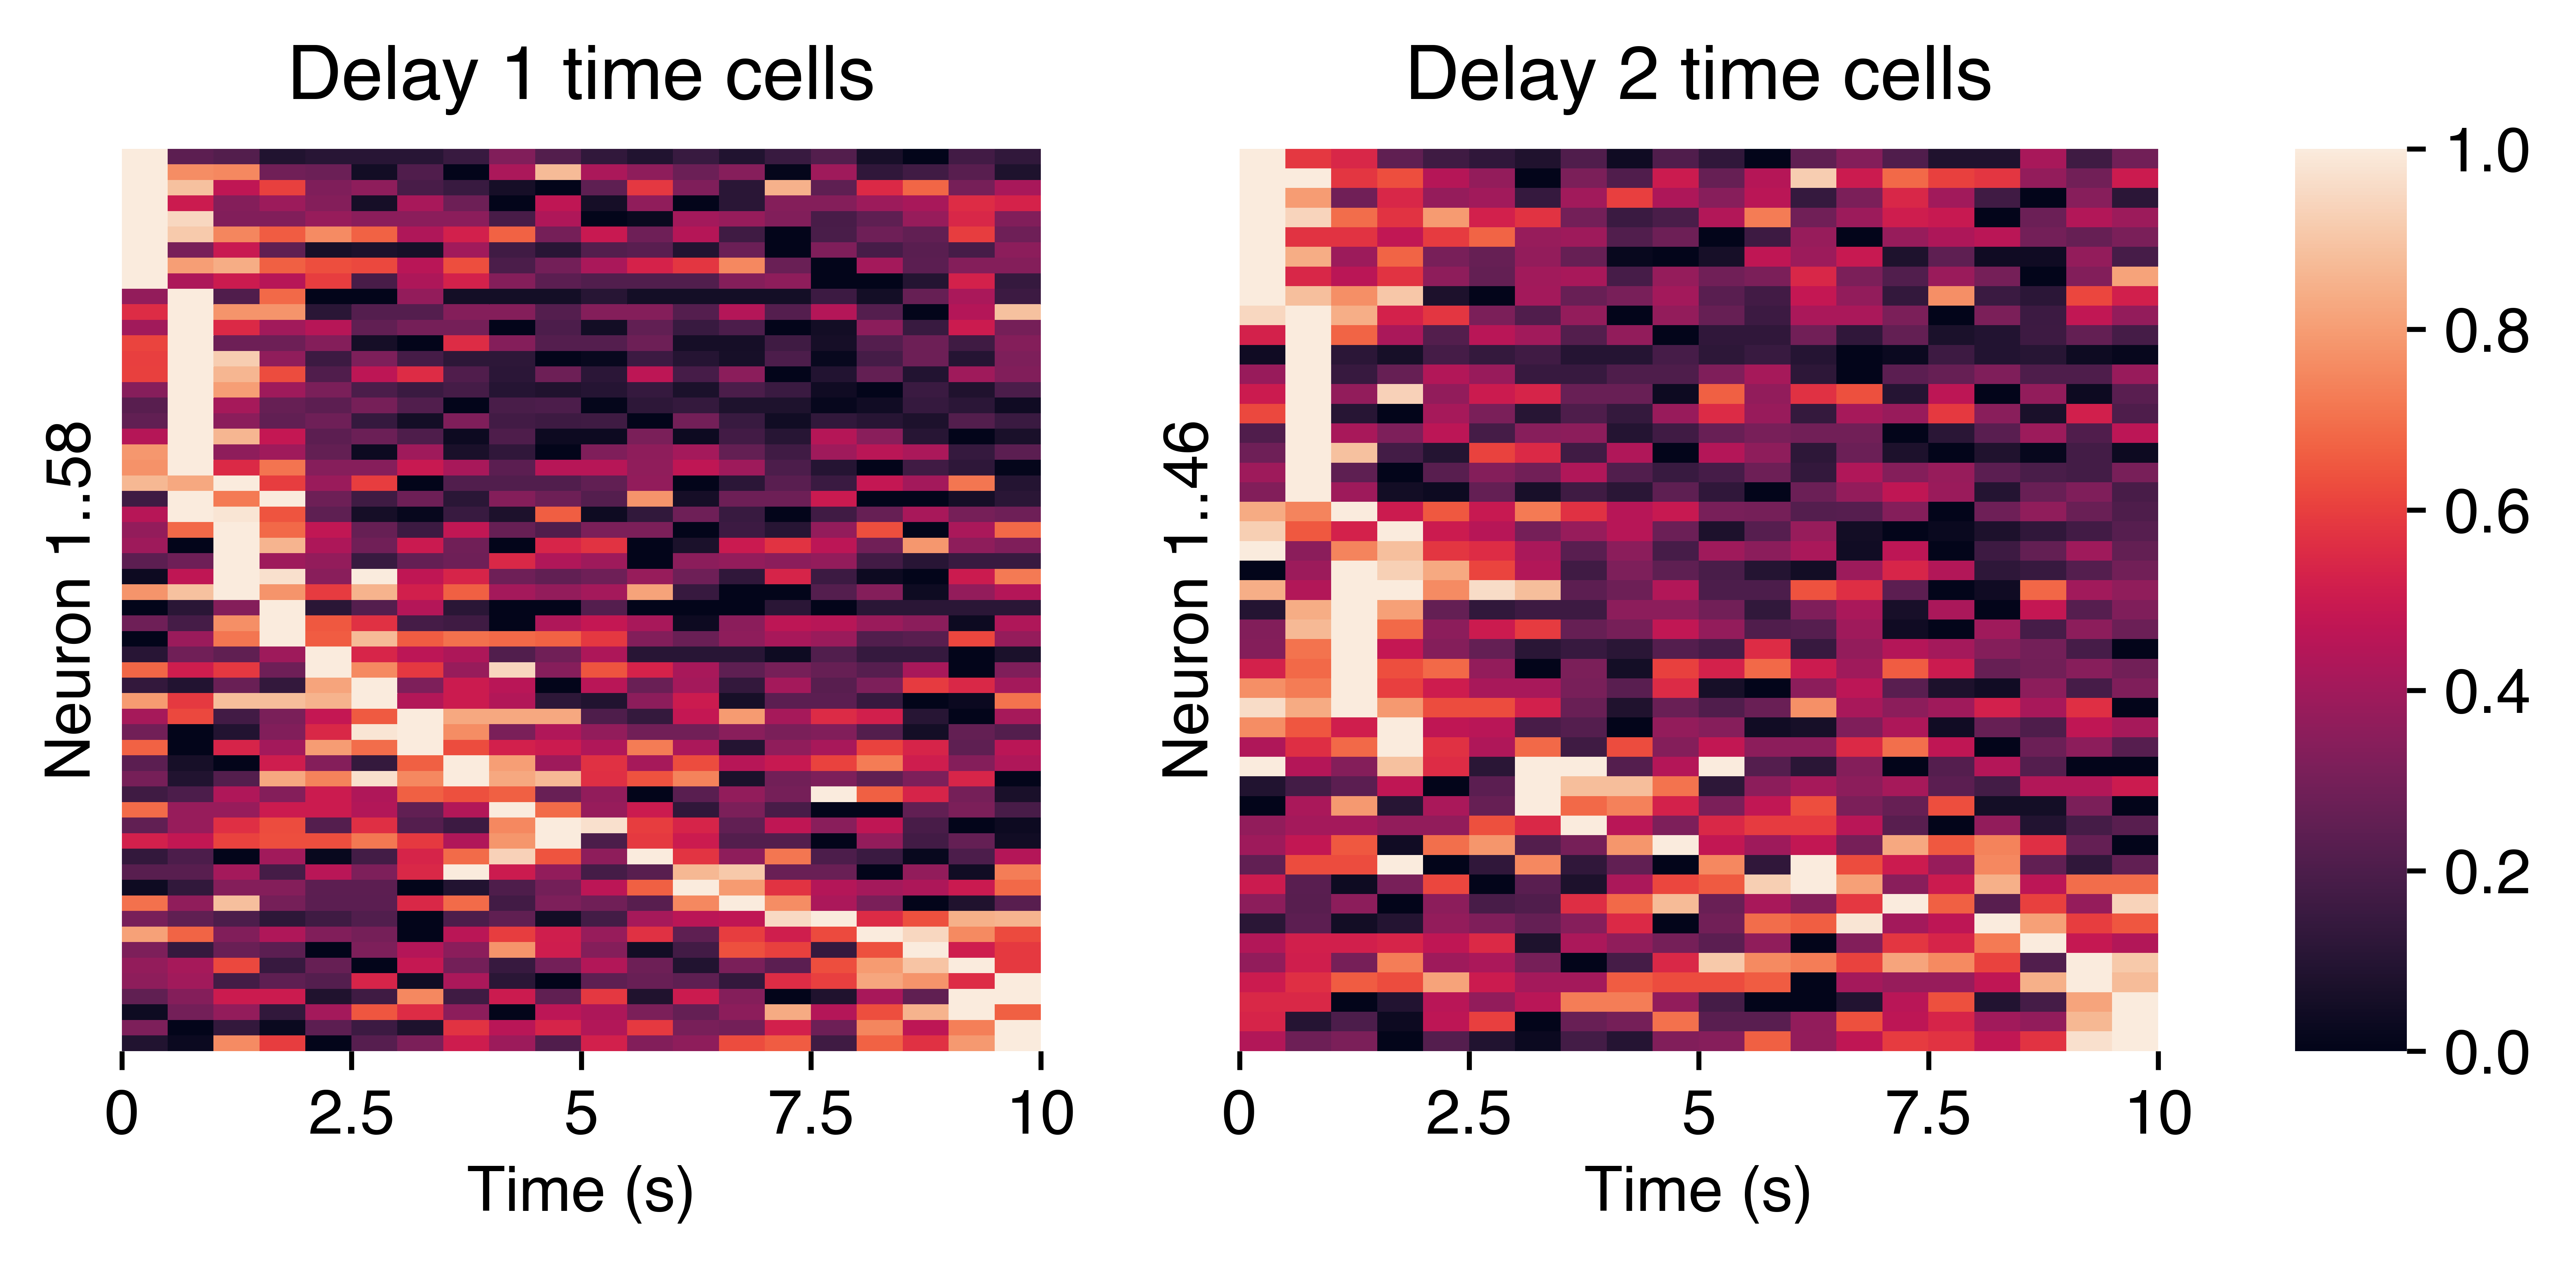

In [9]:
# Plot the mean timecourse for all Delay1 and Delay2 neurons.
savefig = 1
overwrite = 1
bins = 20
grid_shp = (15, 37) # (12, 37)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}

spikes_by_time = od([('Delay1', []), ('Delay2', [])])
for game_state in ['Delay1', 'Delay2']:
    mean_spikes = []
    qry = "(sig==True) & (beta_abs_max>0) & (gameState=='{}')".format(game_state)
    for idx, row in ols_pairs.query(qry).sort_values(['beta_abs_argmax', 'fr_max_ind', 'sparsity']).iterrows():
        subj_sess = row['subj_sess']
        chan, unit = row['neuron'].split('-')
        spikes_by_time[game_state].append(_combine_time_bins(row['spike_mat'], bins)) # time_bin; mean over trials
    spikes_by_time[game_state] = np.array(spikes_by_time[game_state]) # neuron x time_bin

plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=grid_shp[0], colspan=15),
      plt.subplot2grid(grid_shp, (0, 18), rowspan=grid_shp[0], colspan=15),
      plt.subplot2grid(grid_shp, (0, 35), rowspan=grid_shp[0], colspan=2)]
ax = np.ravel(ax)

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}
ax_titles = {'Delay1': 'Delay 1 time cells',
             'Delay2': 'Delay 2 time cells'}

game_states = ['Delay1', 'Delay2']
n_neurons = []
for i, game_state in enumerate(game_states):
    # Concat firing rates across trial phases, for each neuron.
    ii = i
    
    #xsort = np.argsort(np.argmax(spikes_by_time[game_state], axis=1))
    fr_mat = minmax_scale(spikes_by_time[game_state], axis=1)#[xsort, :]
    n_neurons.append(fr_mat.shape[0])
    
    # Plot the firing rate heatmap.
    xticks = [0, 5, 10, 15, 20]
    xticklabels = [0, 2.5, 5, 7.5, 10]
#     xticks = [0, 2, 4, 6, 8, 10]
#     xticklabels = [0, 2, 4, 6, 8, 10]
    vmin = 0
    vmax = 1
    add_cbar = False
    if ii == len(ax) - 2:
        add_cbar = True
    ax[ii] = sns.heatmap(fr_mat, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket',
                         square=False, cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[i].tick_params(axis='x', which='both', length=3, pad=3)
    ax[ii].tick_params(axis='y', which='both', length=0, pad=3)
    ax[ii].set_xticks(xticks)
    ax[ii].set_xticklabels(xticklabels, fontsize=font['tick'], rotation=0)
    ax[ii].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
    ax[ii].set_yticks([])
    ax[ii].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
    ax[ii].set_title(ax_titles[game_state], pad=8, fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=3)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay',
                       'delay_time_cells-{}delay1-{}delay2-{}units.pdf'
                       .format(spikes_by_time['Delay1'].shape[0], spikes_by_time['Delay2'].shape[0], ols_pairs['subj_sess_unit'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

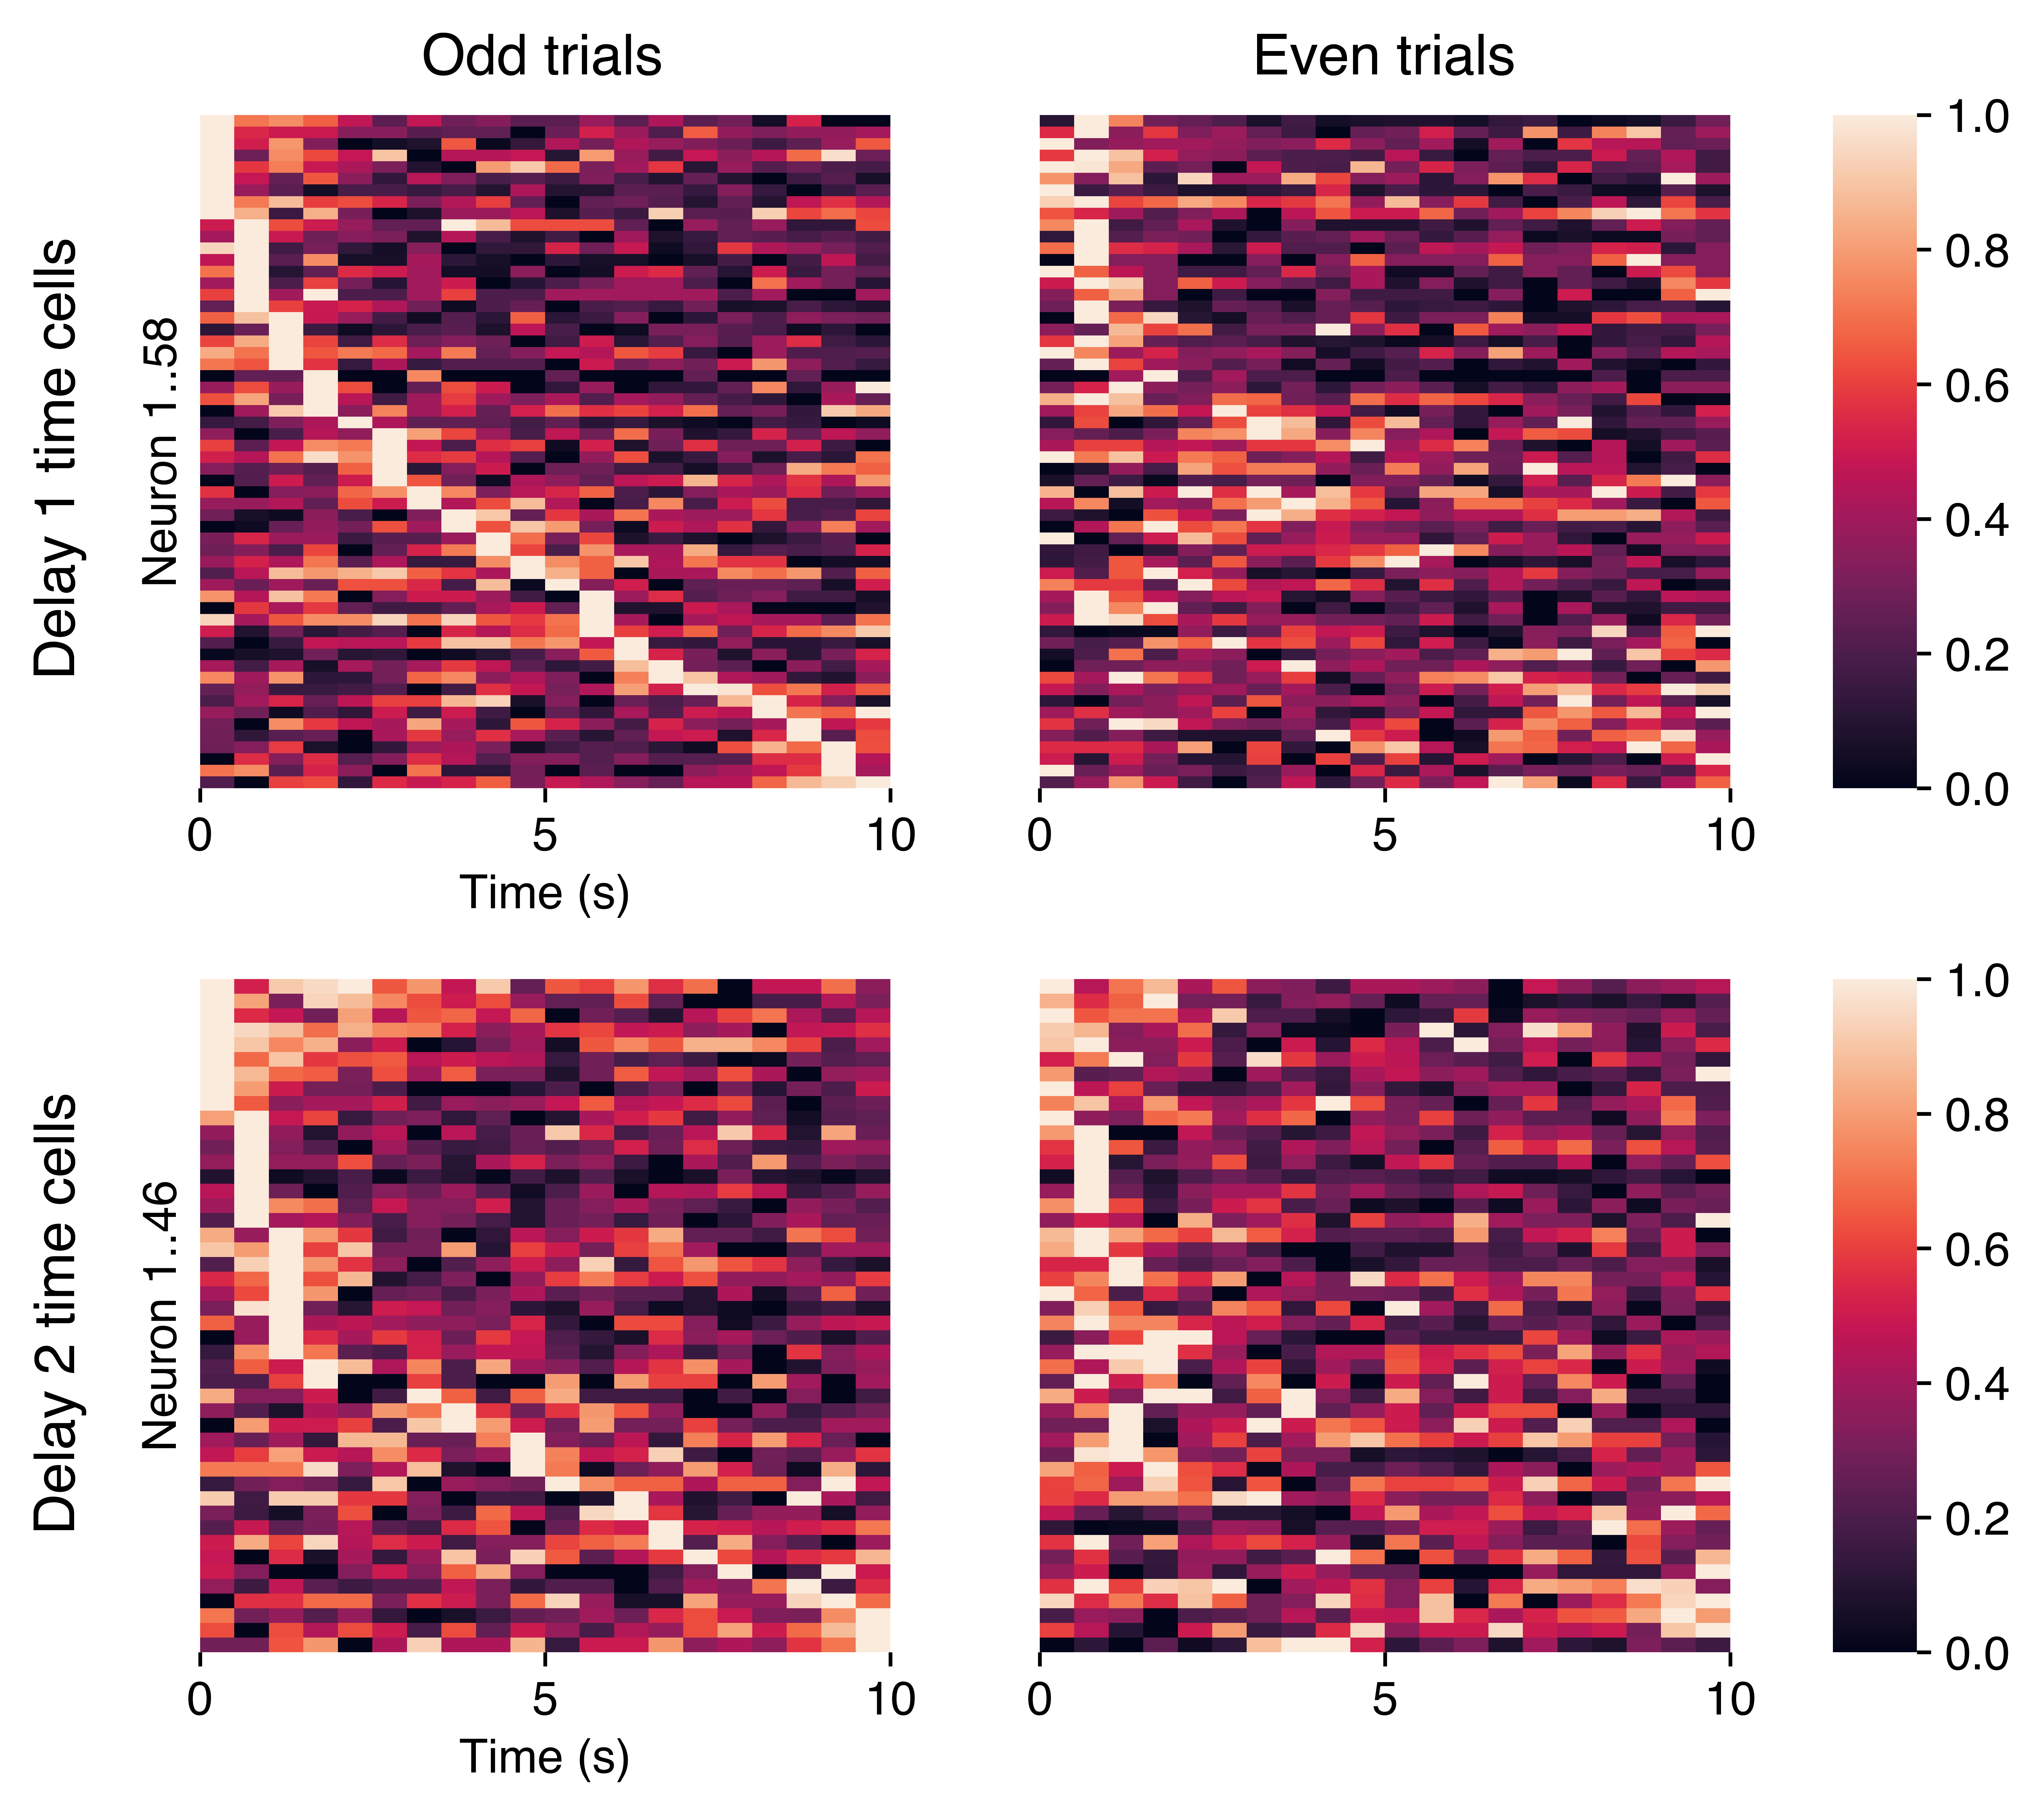

In [46]:
savefig = 0
overwrite = 0
grid_shp = (34, 37)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}

spikes_by_time_odd = od([('Delay1', []), ('Delay2', [])])
spikes_by_time_even = od([('Delay1', []), ('Delay2', [])])
for game_state in ['Delay1', 'Delay2']:
    mean_spikes = []
    qry = "(sig==True) & (beta_abs_max>0) & (gameState=='{}')".format(game_state)
    for idx, row in ols_pairs.query(qry).iterrows():
        subj_sess = row['subj_sess']
        chan, unit = row['neuron'].split('-')
        if 'event_spikes' not in dir():
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        elif event_spikes.subj_sess != row['subj_sess']:
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
        is_odd = spike_mat.index % 2 == 1
        is_even = spike_mat.index % 2 == 0
        odd_means = np.mean(spike_mat.loc[is_odd, :].values, axis=0)
        even_means = np.mean(spike_mat.loc[is_even, :].values, axis=0)
        spikes_by_time_odd[game_state].append(odd_means)
        spikes_by_time_even[game_state].append(even_means) # time_bin; mean over trials
    spikes_by_time_odd[game_state] = np.array(spikes_by_time_odd[game_state])
    spikes_by_time_even[game_state] = np.array(spikes_by_time_even[game_state]) # neuron x time_bin
    
plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 18), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 35), rowspan=15, colspan=2),
      plt.subplot2grid(grid_shp, (19, 0), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (19, 18), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (19, 35), rowspan=15, colspan=2)]
ax = np.ravel(ax)

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}
ax_titles = {'Delay1': 'Delay 1 time cells',
             'Delay2': 'Delay 2 time cells'}

# The trial phases we want to examine significant time cells for.
game_states = ['Delay1', 'Delay2']
xsort = {}
n_neurons = []
for i, game_state in enumerate(game_states):
    # Concat firing rates across trial phases, for each neuron.
    ii = i * 3
    
    # Sort units in order of firing peak.
    xsort[game_state] = np.argsort(np.argmax(spikes_by_time_odd[game_state], axis=1))
    fr_mat_odd = spikes_by_time_odd[game_state][xsort[game_state], :]
    fr_mat_even = spikes_by_time_even[game_state][xsort[game_state], :]
    
#     # Apply min_max scaling across combined even and odd values for each unit.
#     _min = np.expand_dims(np.min((np.min(fr_mat_odd, axis=1), np.min(fr_mat_even, axis=1)), axis=0), 1)
#     _max = np.expand_dims(np.max((np.max(fr_mat_odd, axis=1), np.max(fr_mat_even, axis=1)), axis=0), 1)
#     fr_mat_odd = (fr_mat_odd - _min) / (_max - _min)
#     fr_mat_even = (fr_mat_even - _min) / (_max - _min)
    
    # Apply min_max scaling for even and odd values for each unit, respectively.
    fr_mat_odd = minmax_scale(fr_mat_odd, axis=1)
    fr_mat_even = minmax_scale(fr_mat_even, axis=1)

    n_neurons.append(fr_mat_odd.shape[0])
    
    # Plot the firing rate heatmaps.
    vmin = 0
    vmax = 1
    add_cbar = False
    ax[ii] = sns.heatmap(fr_mat_odd, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket',
                         square=False, cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[ii].tick_params(axis='x', which='both', length=3, pad=3)
    ax[ii].tick_params(axis='y', which='both', length=0, pad=3)
    ax[ii].set_xticks(np.arange(0, fr_mat.shape[1]+1, 10))
    ax[ii].set_xticklabels(np.arange(0, (fr_mat.shape[1]+1)/2, 5, dtype=np.int), 
                           fontsize=font['tick'], rotation=0)
    ax[ii].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
    ax[ii].set_yticks([])
    ax[ii].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
    
    ii += 1
    add_cbar = True
    ax[ii] = sns.heatmap(fr_mat_even, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket',
                         square=False, cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[ii].tick_params(axis='x', which='both', length=3, pad=3)
    ax[ii].tick_params(axis='y', which='both', length=0, pad=3)
    ax[ii].set_xticks(np.arange(0, fr_mat.shape[1]+1, 10))
    ax[ii].set_xticklabels(np.arange(0, (fr_mat.shape[1]+1)/2, 5, dtype=np.int), 
                           fontsize=font['tick'], rotation=0)
    ax[ii].set_yticks([])
    ax[ii].set_xlabel('', fontsize=font['label'], labelpad=3)
    ax[ii].set_ylabel('', fontsize=font['label'], labelpad=3)
    
    if add_cbar:
        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=3)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)
    
    fig.text(0.225, 0.9, 'Odd trials', fontsize=font['fig'])
    fig.text(0.6, 0.9, 'Even trials', fontsize=font['fig'])
    fig.text(0.05, 0.8, 'Delay 1 time cells', rotation=90, fontsize=font['fig'])
    fig.text(0.05, 0.38, 'Delay 2 time cells', rotation=90, fontsize=font['fig'])
    
if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay',
                       'delay_time_cells-{}delay1-{}delay2-{}units_even-odd-split.pdf'
                       .format(spikes_by_time_odd['Delay1'].shape[0], spikes_by_time_odd['Delay2'].shape[0], ols_pairs['subj_sess_unit'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        
fig.show()

# Single-unit rasters over time

U537_ses0-33-2, Delay2, Z = 3.2, sig = True
Done in 4.8s


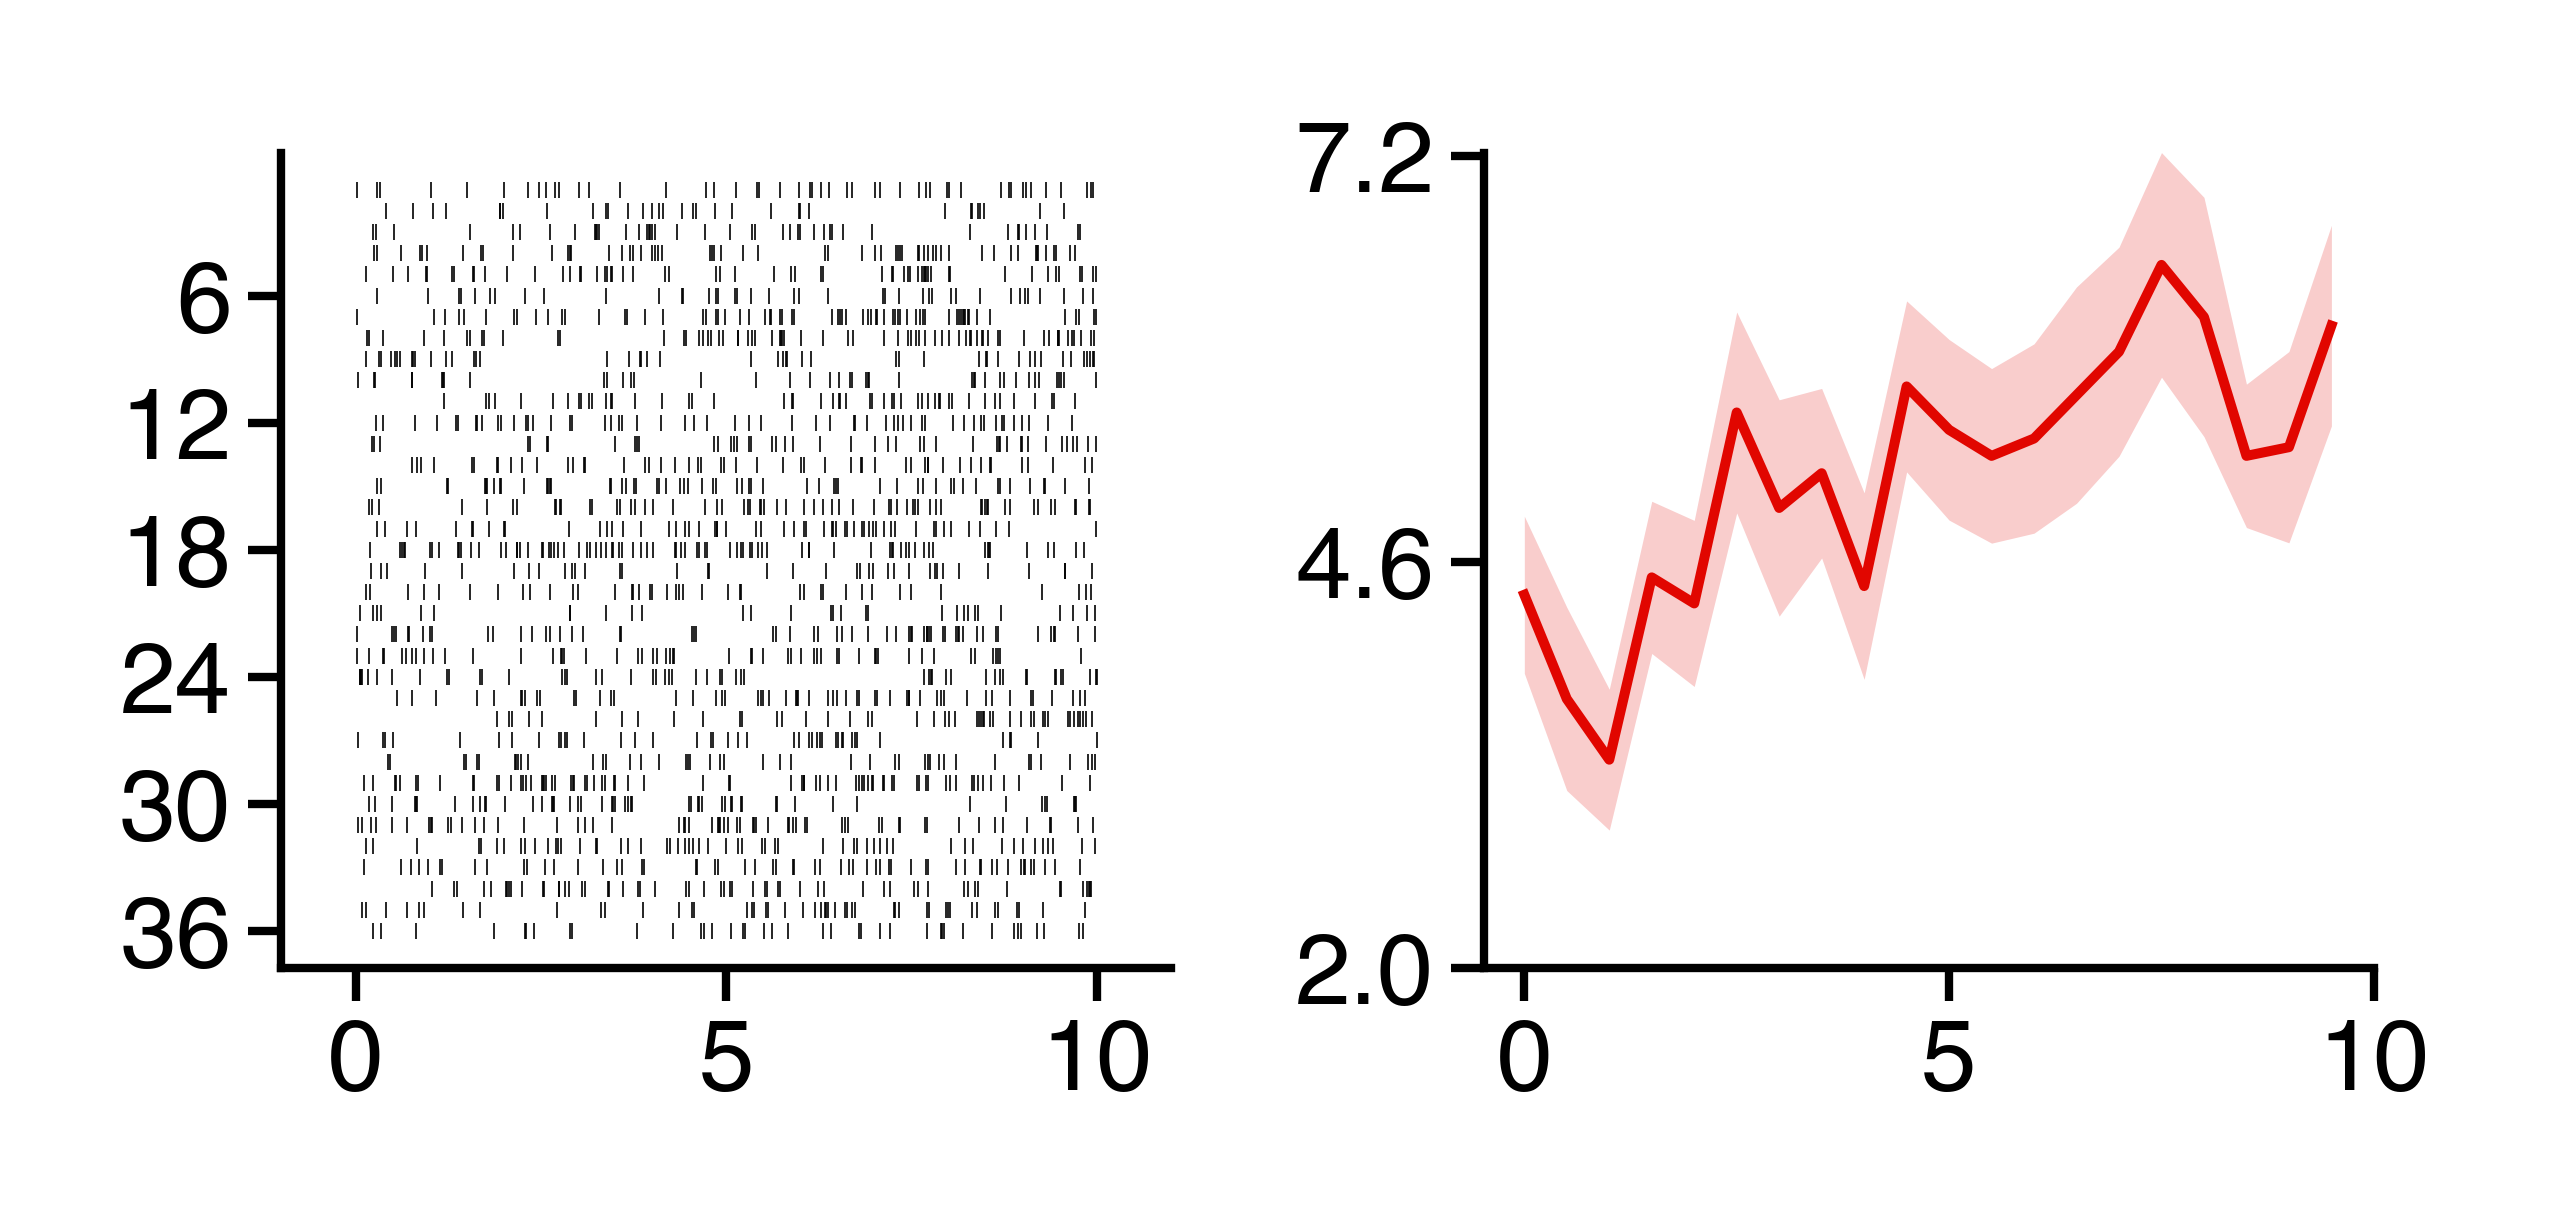

In [12]:
# Plot a neuron's spike raster and firing rate over time.
savefig = 1
overwrite = 1
plot_labels = False
plot_game_states = False
plot_title = False
font = {'tick': 6, 'label': 7, 'annot': 7, 'fig': 9}
labelpad = 2 # 1
xtick_inc = 5
line_color = '#e10600'
fill_alpha = 0.2
game_states = ['Delay1', 'Delay2']

start_time = time()

_df = ols_pairs.query("(sig==True) & (subj_sess=='U537_ses0')")
for idx, row in _df.iterrows():
    subj_sess = row['subj_sess']
    neuron = row['neuron']
    game_state = row['gameState']
    
    # -------------------------------------------
    # PLOTTING
    plt.close()
    fig = plt.figure(figsize=(2.25, 2.25*(14/35)), dpi=1200)
    if plot_labels:
        n_rows = 14
        n_cols = 37
        ax = [plt.subplot2grid((n_rows, n_cols), (0, 0), rowspan=14, colspan=15),
              plt.subplot2grid((n_rows, n_cols), (0, 22), rowspan=14, colspan=15)]
        ax = np.ravel(ax)
    else:
        n_rows = 14
        n_cols = 35
        ax = [plt.subplot2grid((n_rows, n_cols), (0, 0), rowspan=14, colspan=15),
              plt.subplot2grid((n_rows, n_cols), (0, 20), rowspan=14, colspan=15)]
        ax = np.ravel(ax)

    # Spike raster plot.
    iax = 0
    ax[iax] = time_cell_plots.time_raster(subj_sess,
                                          neuron, 
                                          game_states=game_state,
                                          plot_vlines=False, 
                                          plot_labels=plot_labels,
                                          plot_game_states=plot_game_states,
                                          plot_trial_phases=False, 
                                          plot_title=plot_title,
                                          ax=ax[iax],
                                          font=font,
                                          labelpad=labelpad,
                                          xtick_inc=xtick_inc)
        
    # Firing rate over time plot.
    iax = 1
    mean_frs = np.array(row['mean_frs'])
    sem_frs = np.array(row['sem_frs'])
    ymin = np.max((0, np.floor(np.min(mean_frs - sem_frs))))
    ymax = np.max(mean_frs + sem_frs)
    ax[iax].fill_between(np.arange(len(mean_frs)), mean_frs + sem_frs, mean_frs - sem_frs,
                         color=line_color, linewidth=0, alpha=fill_alpha)
    ax[iax].plot(mean_frs, color=line_color, linewidth=0.6)
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(0.5)
    ax[iax].tick_params(axis='both', which='both', length=2, width=0.5, pad=1)
    ax[iax].set_xticks(np.linspace(0, 20, 3))
    ax[iax].set_xticklabels(np.linspace(0, 10, 3, dtype=np.int), fontsize=font['tick'])
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].set_yticks(np.round(np.linspace(ymin, ymax, 3), 1))
    ax[iax].set_yticklabels(np.round(np.linspace(ymin, ymax, 3), 1), fontsize=font['tick'])
    if plot_labels:
        ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=labelpad)
    
    if savefig:
        chan, unit = neuron.split('-')
        hemroi = spike_preproc.roi_lookup(subj_sess, chan)
        filename = op.join(proj_dir, 'figs', 'plot_delay',
                           '{}-CSC{}-unit{}-{}-{}-time_firing.pdf'.format(subj_sess, chan, unit, hemroi, game_state))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight')

print('{}-{}, {}, Z = {:.1f}, sig = {}'.format(subj_sess, neuron, game_state, row['z_lr'], row['sig']))
print('Done in {:.1f}s'.format(time() - start_time))
fig.show()

In [13]:
# How strong are the significant units?
(ols_pairs.query("(sig==True)")
          .groupby(['gameState', 'testvar', 'roi_gen'])
          .agg({'neuron': len, 
                'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), np.std(x))}))

neuron       z_lr
gameState testvar roi_gen                       
Delay1    time    Hippocampus      13  3.5 ± 2.1
                  MTL              28  3.4 ± 1.6
                  Cortex           33  4.0 ± 2.6
Delay2    time    Hippocampus      10  4.0 ± 2.1
                  MTL              21  3.6 ± 1.3
                  Cortex           32  3.9 ± 2.1

In [19]:
game_states = ['Delay1', 'Delay2']
alpha = 0.05

ols_pairs['sig_fdr'] = False
for game_state in game_states:
    pvals = ols_pairs.loc[ols_pairs['gameState']==game_state, 'emp_pval']
    ols_pairs.loc[ols_pairs['gameState']==game_state, 'sig_fdr'] = sm.stats.multipletests(pvals, alpha=alpha, method='fdr_tsbky')[0]

In [98]:
fr_max_col = 'fr_max_ind10'

game_states = ['Delay1', 'Delay2']
units_per_region = ols_pairs[['subj_sess_unit', 'roi_gen']].drop_duplicates().groupby('roi_gen').size()
_ols_pairs = ols_pairs.query("(sig_holm==True) & (gameState=={})".format(game_states)).copy()

_ols_pairs['peak_fr_ind'] = _ols_pairs[fr_max_col]
peak_fr_counts = _ols_pairs.groupby(['gameState', 'roi_gen', 'peak_fr_ind']).size().reset_index().rename(columns={'peak_fr_ind': 'time', 0: 'count'})

_counts = peak_fr_counts.groupby(['gameState', 'roi_gen'])['count'].apply(np.sum).to_dict()
peak_fr_counts['prop_sig'] = peak_fr_counts.apply(lambda x: 100 * (x['count'] / _counts[(x['gameState'], x['roi_gen'])]), axis=1)
peak_fr_counts['prop_all'] = peak_fr_counts.apply(lambda x: 100 * (x['count'] / units_per_region[x['roi_gen']]), axis=1)

roi_cats = ['Hippocampus', 'MTL', 'Cortex']
peak_fr_counts['roi_gen'] = peak_fr_counts['roi_gen'].astype(pd.CategoricalDtype(roi_cats, ordered=True))
peak_fr_counts = peak_fr_counts.sort_values(['gameState', 'roi_gen', 'time']).reset_index(drop=True)

In [99]:
(_ols_pairs.groupby(['gameState', 'peak_fr_ind'])
           .agg({'neuron': len, 
                 'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), np.std(x))}))

neuron       z_lr
gameState peak_fr_ind                   
Delay1    0                29  4.8 ± 3.0
          1                14  2.9 ± 0.6
          2                 4  2.7 ± 0.5
          3                 6  2.6 ± 0.6
          4                 3  2.5 ± 0.2
          5                 3  3.2 ± 0.6
          6                 4  2.4 ± 0.2
          7                 2  5.2 ± 0.3
          8                 5  3.0 ± 1.5
          9                 4  2.7 ± 0.6
Delay2    0                25  4.6 ± 2.4
          1                12  3.2 ± 1.0
          3                 4  2.3 ± 0.1
          4                 2  3.3 ± 0.1
          5                 3  2.8 ± 0.9
          6                 2  3.4 ± 1.0
          7                 4  4.5 ± 1.9
          8                 4  3.7 ± 0.8
          9                 7  3.3 ± 1.4

In [100]:
peak_fr_counts['prop_all'].max()

11.678832116788321

In [94]:
peak_fr_counts.groupby(['gameState', 'roi_gen']).agg({'count': np.sum, 'prop_sig': np.sum, 'prop_all': np.sum})

count  prop_sig   prop_all
gameState roi_gen                                
Delay1    Hippocampus     13     100.0  14.285714
          MTL             28     100.0  14.583333
          Cortex          33     100.0  24.087591
Delay2    Hippocampus     10     100.0  10.989011
          MTL             21     100.0  10.937500
          Cortex          32     100.0  23.357664

In [40]:
# Unique delay time cells.
stats.binom_test(113, 407, (1 - 0.95**2))

7.205290039020616e-25

In [38]:
# Time field peaks between 0-2s.
stats.binom_test(60, 407, (1 - 0.95**2) * (1/5))

1.4248584600325794e-33

In [36]:
# Time field peaks between 2-10s.
stats.binom_test(53, 407, (1 - 0.95**2) * (4/5))

0.0002771162121263082

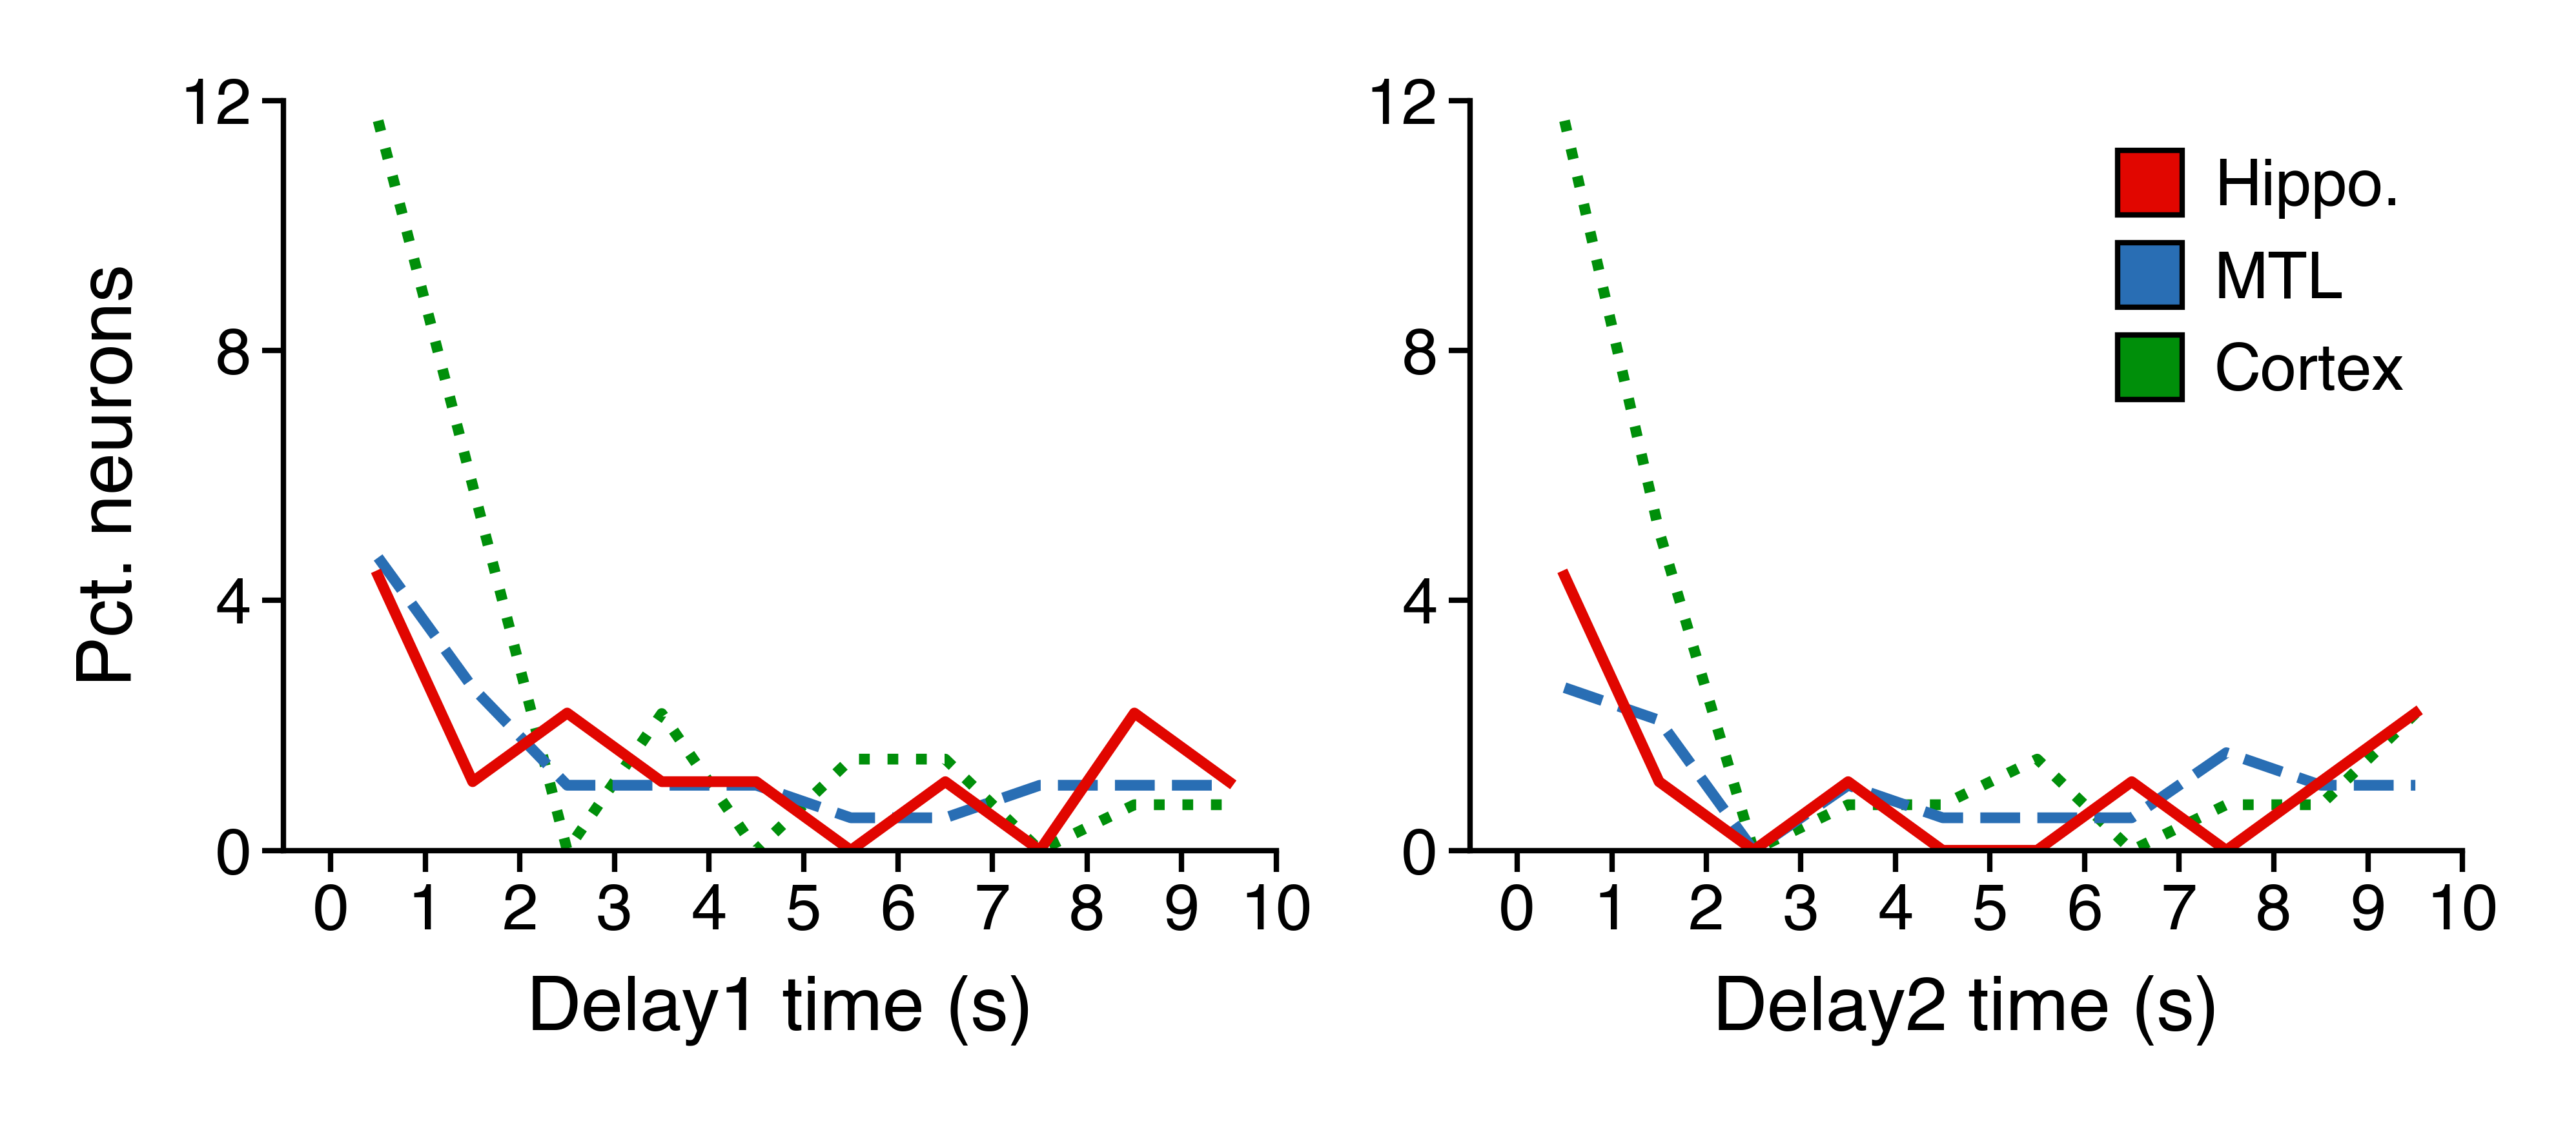

In [136]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
lw = 1
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

rois = ['Cortex', 'MTL', 'Hippocampus']
linestyles = ['dotted', '--', '-']

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

# cmap = {0: (190, 190, 190), # gray
#         1: (225, 6, 0), # red
#         2: (41, 110, 180), # blue
#         3: (243, 165, 191)} # pink
# for k in cmap:
#     cmap[k] = list(np.array(cmap[k])/255)
# _cmap = [cmap[1], cmap[3], cmap[2]]

_cmap = ['#008f0a', '#296eb4', '#e10600']
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
#     ax[iax] = sns.barplot(x='time', y='prop_all', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
#                         palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    for iRoi, roi in enumerate(rois):
        xvals = np.arange(10)
        yvals = []
        for xval in xvals:
            yvals.append(peak_fr_counts.query("(gameState=='{}') & (roi_gen=='{}')".format(game_state, roi)).set_index('time')['prop_all'].get(xval, 0))
        xvals = np.array(xvals) + 0.5
        ax[iax].plot(xvals, yvals, color=_cmap[iRoi], lw=lw, linestyle=linestyles[iRoi])
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    if fr_max_col == 'fr_max_ind10':
        ax[iax].set_xlim([-0.5, 9.5])
        ax[iax].set_xticks(np.arange(11))
        ax[iax].set_xticklabels(np.arange(11), fontsize=font['tick'])
    elif fr_max_col == 'fr_max_ind5':
        ax[iax].set_xticks(np.arange(5))
        ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 12])
    yticks = [0, 4, 8, 12]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Pct. neurons', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
#     ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_percents_by_region_all.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

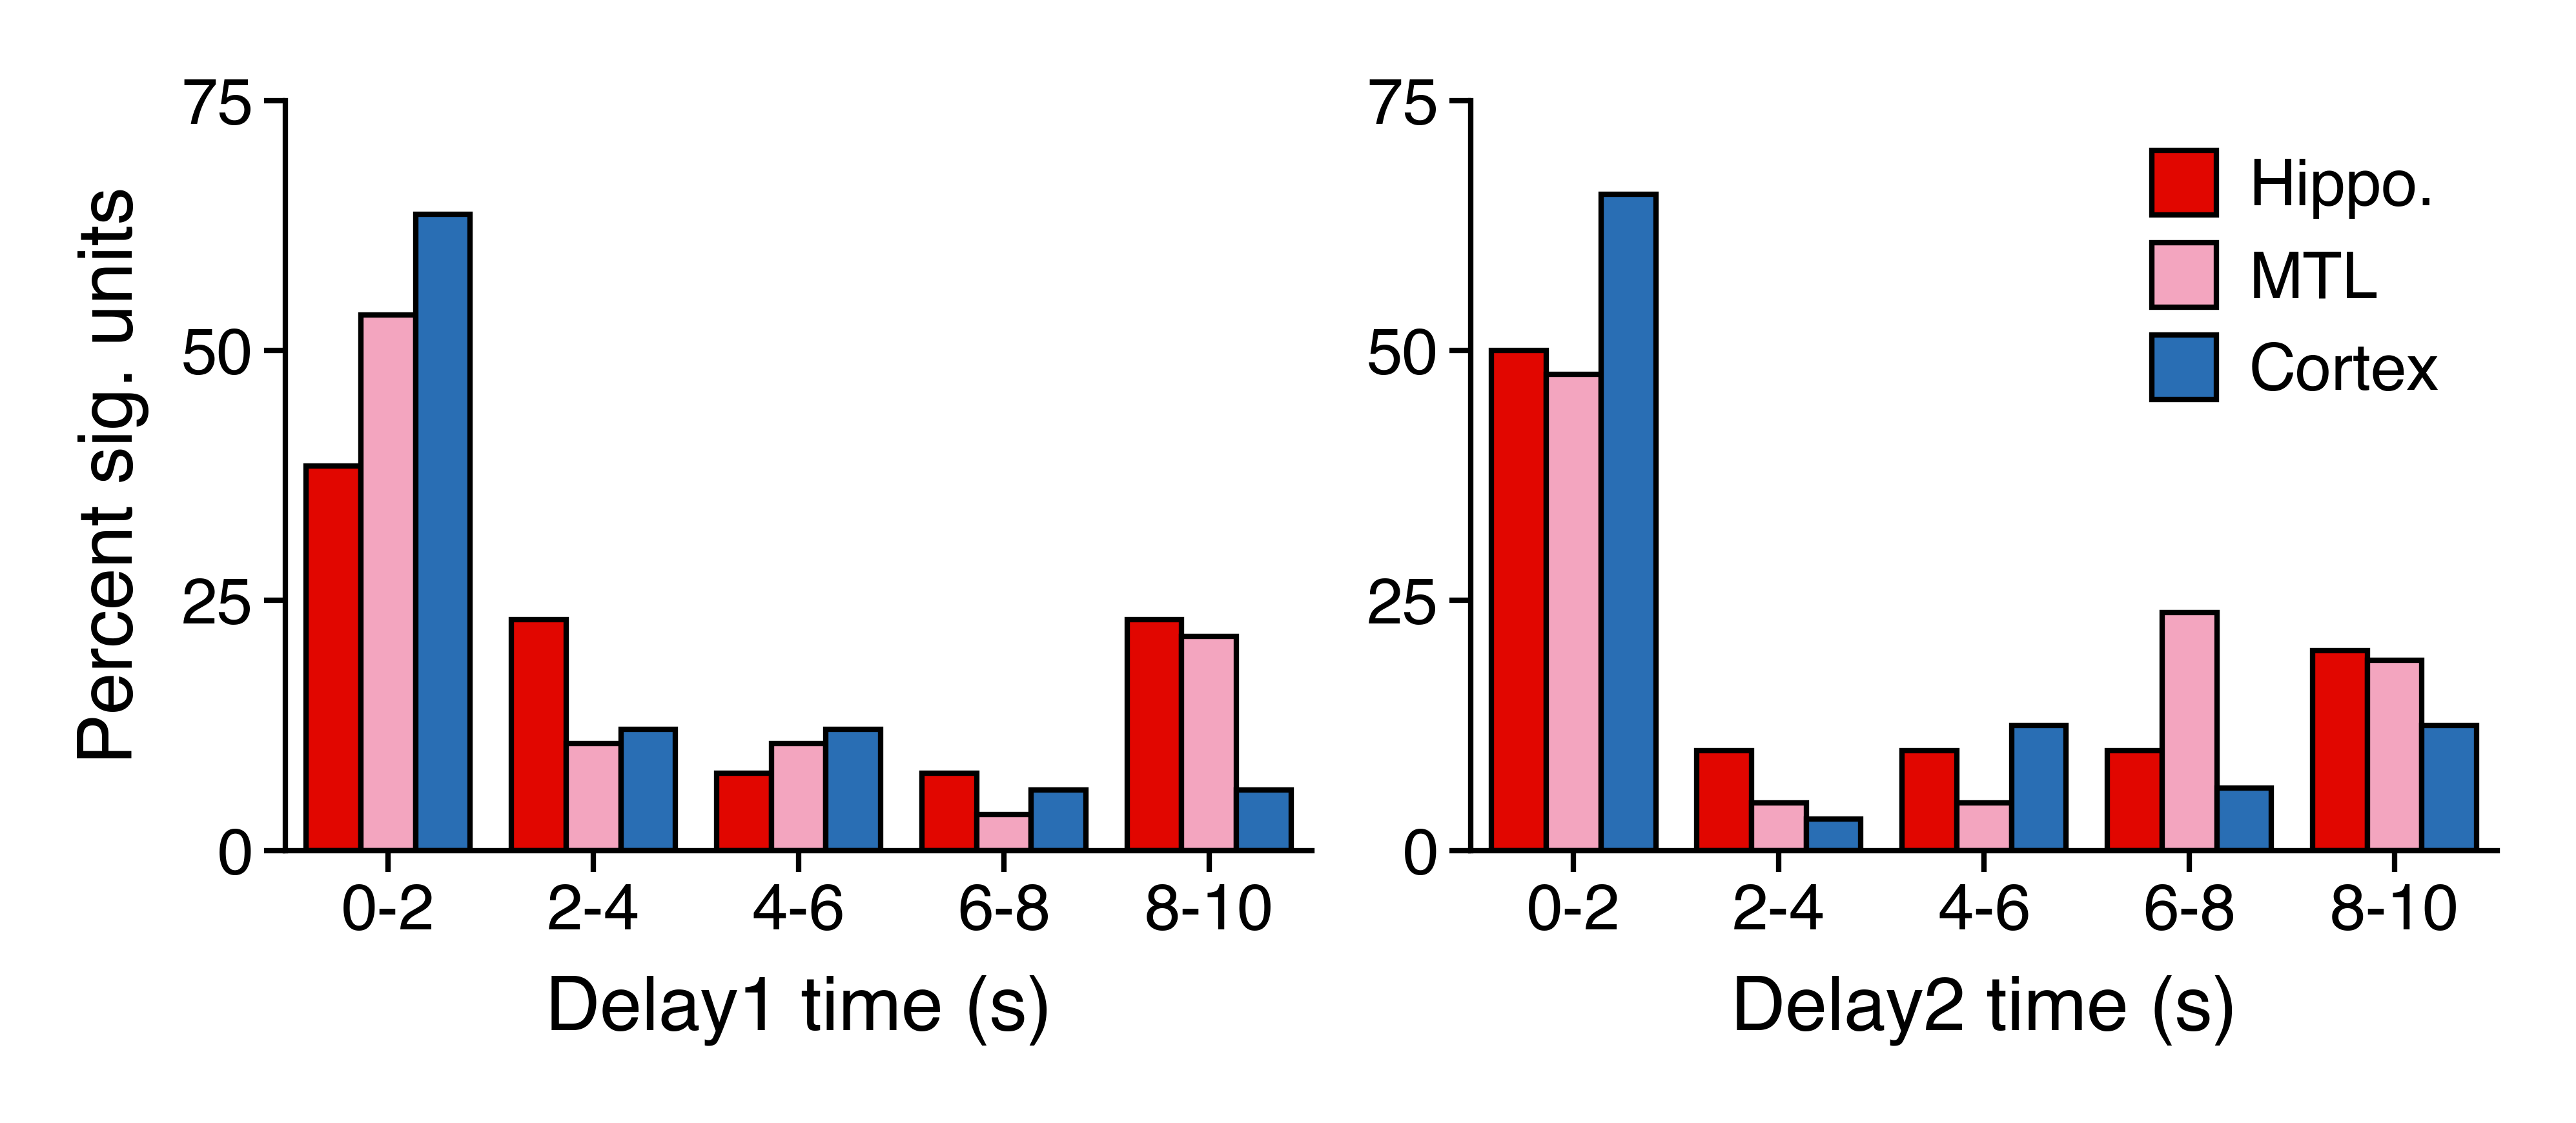

In [97]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[3], cmap[2]]
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='prop_sig', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 75])
    yticks = [0, 25, 50, 75]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Percent sig. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_percents_by_region.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

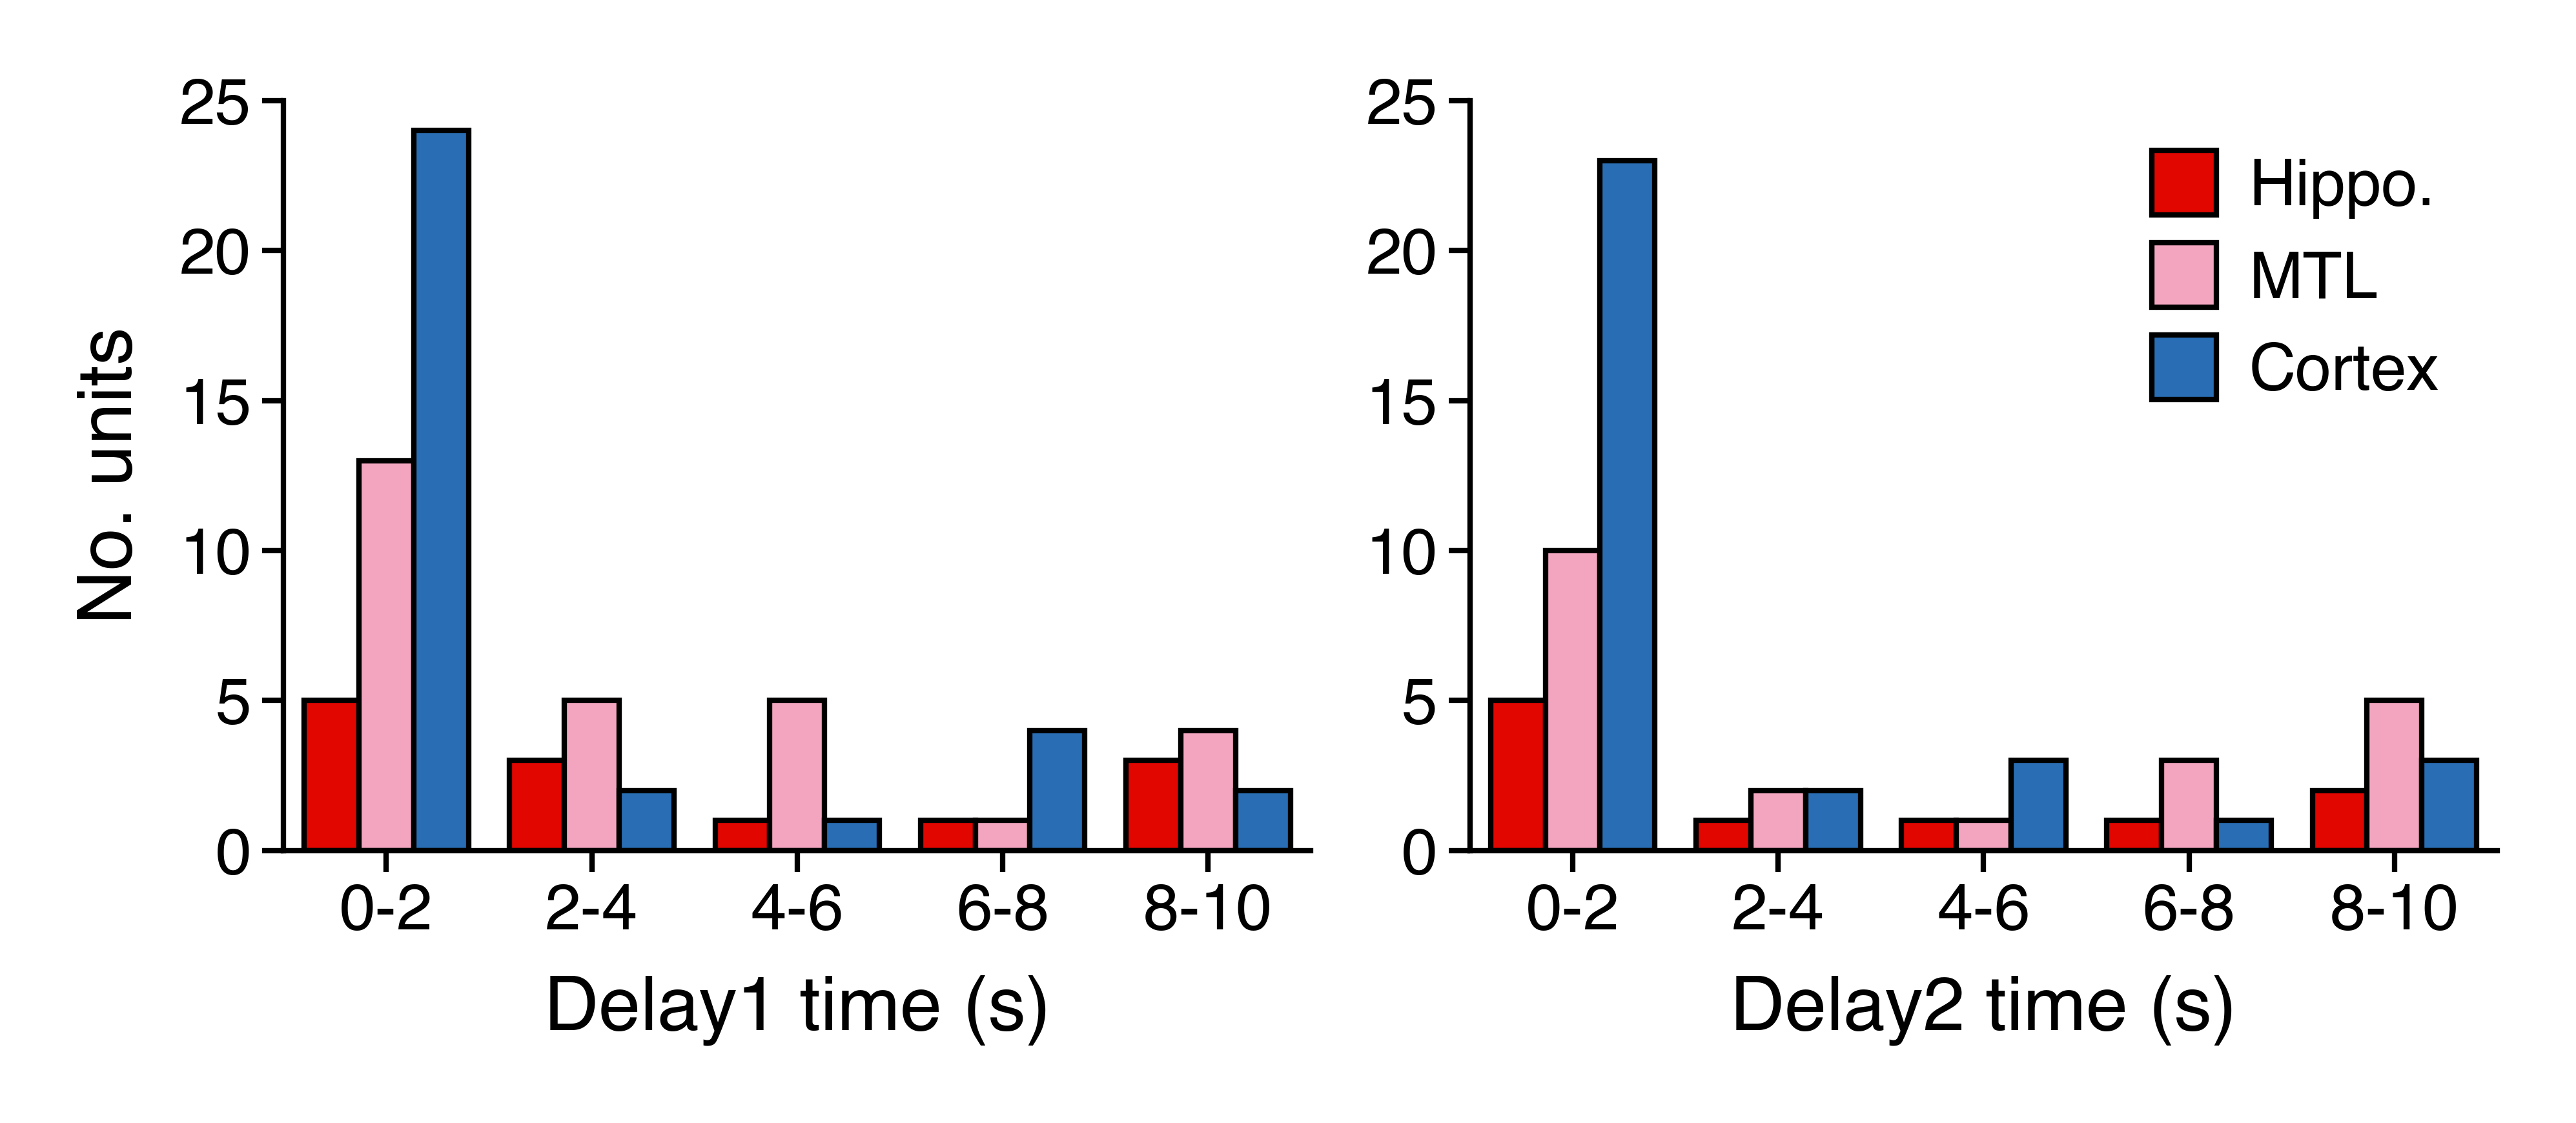

In [20]:
savefig = 1
overwrite = 1
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[3], cmap[2]]
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='count', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 25])
    yticks = [0, 5, 10, 15, 20, 25]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_counts_by_region.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [29]:
n_bins_per_step = 4
game_states = ['Delay1', 'Delay2']
_ols_pairs = ols_pairs.query("(sig==True) & (gameState=={})".format(game_states)).copy()
_ols_pairs['peak_fr_ind'] = _ols_pairs['fr_max_ind'].apply(lambda x: int(x/n_bins_per_step))
peak_fr_counts = _ols_pairs.groupby(['gameState', 'roi_gen', 'peak_fr_ind']).size().reset_index().rename(columns={'peak_fr_ind': 'time', 0: 'count'})

roi_cats = ['MTL', 'Cortex']
peak_fr_counts.loc[peak_fr_counts['roi_gen']=='Hippocampus', 'roi_gen'] = 'MTL'
peak_fr_counts['roi_gen'] = peak_fr_counts['roi_gen'].astype(pd.CategoricalDtype(roi_cats, ordered=True))
peak_fr_counts = peak_fr_counts.sort_values(['gameState', 'roi_gen', 'time']).reset_index(drop=True)

_counts = peak_fr_counts.groupby(['gameState', 'roi_gen'])['count'].apply(np.sum).to_dict()
peak_fr_counts['prop'] = peak_fr_counts.apply(lambda x: 100 * (x['count'] / _counts[(x['gameState'], x['roi_gen'])]), axis=1)

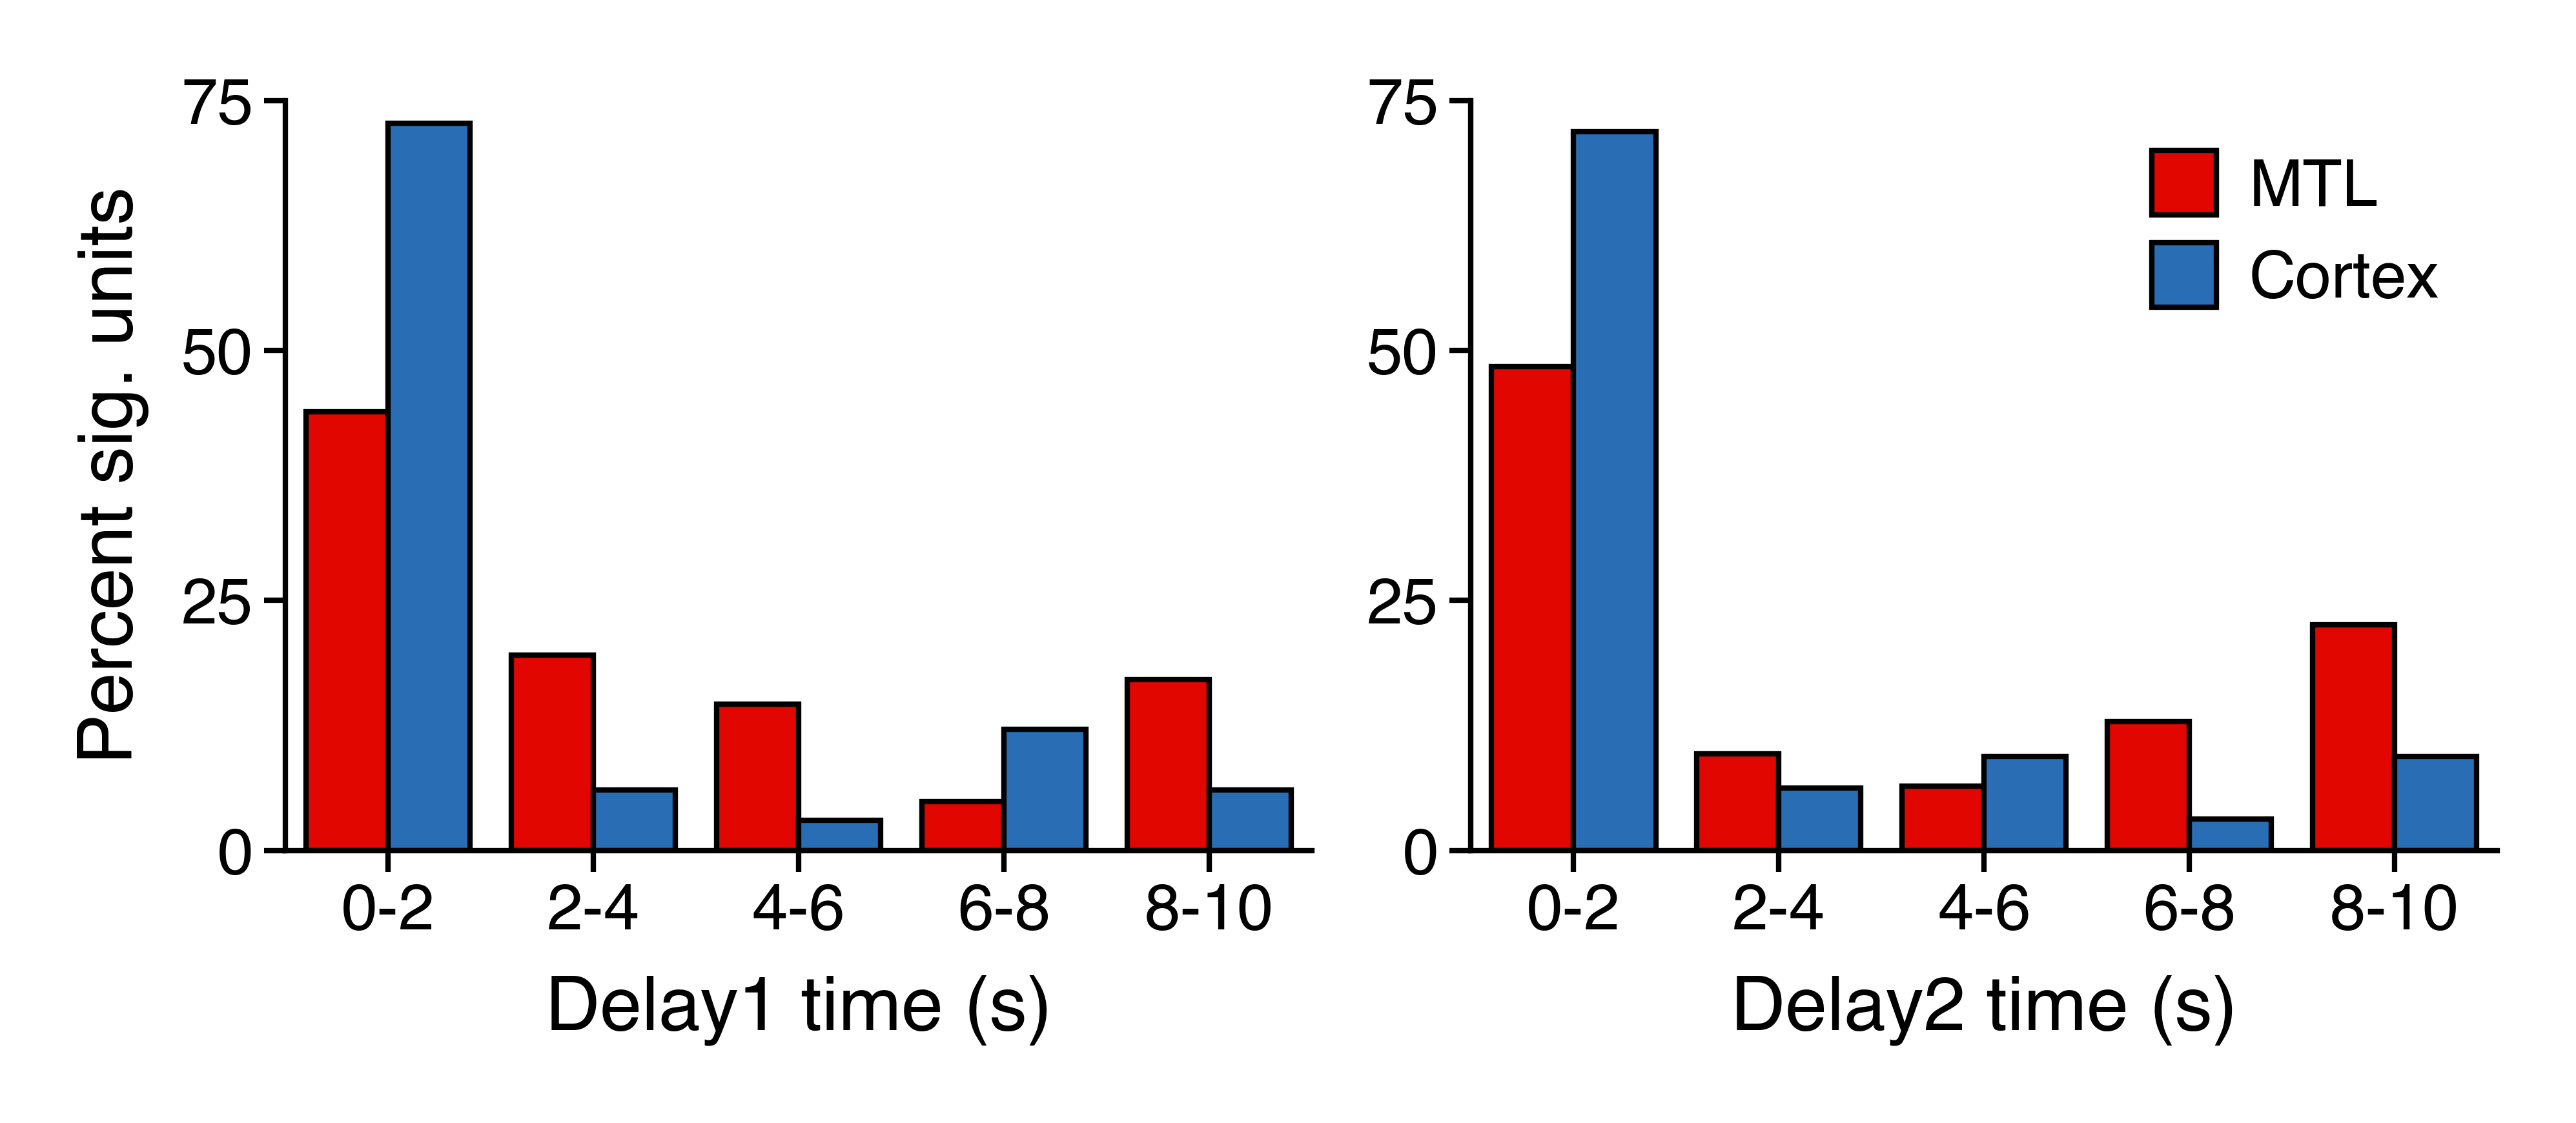

In [33]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[2]]
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='prop', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 75])
    yticks = [0, 25, 50, 75]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Percent sig. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_percents_by_region2.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

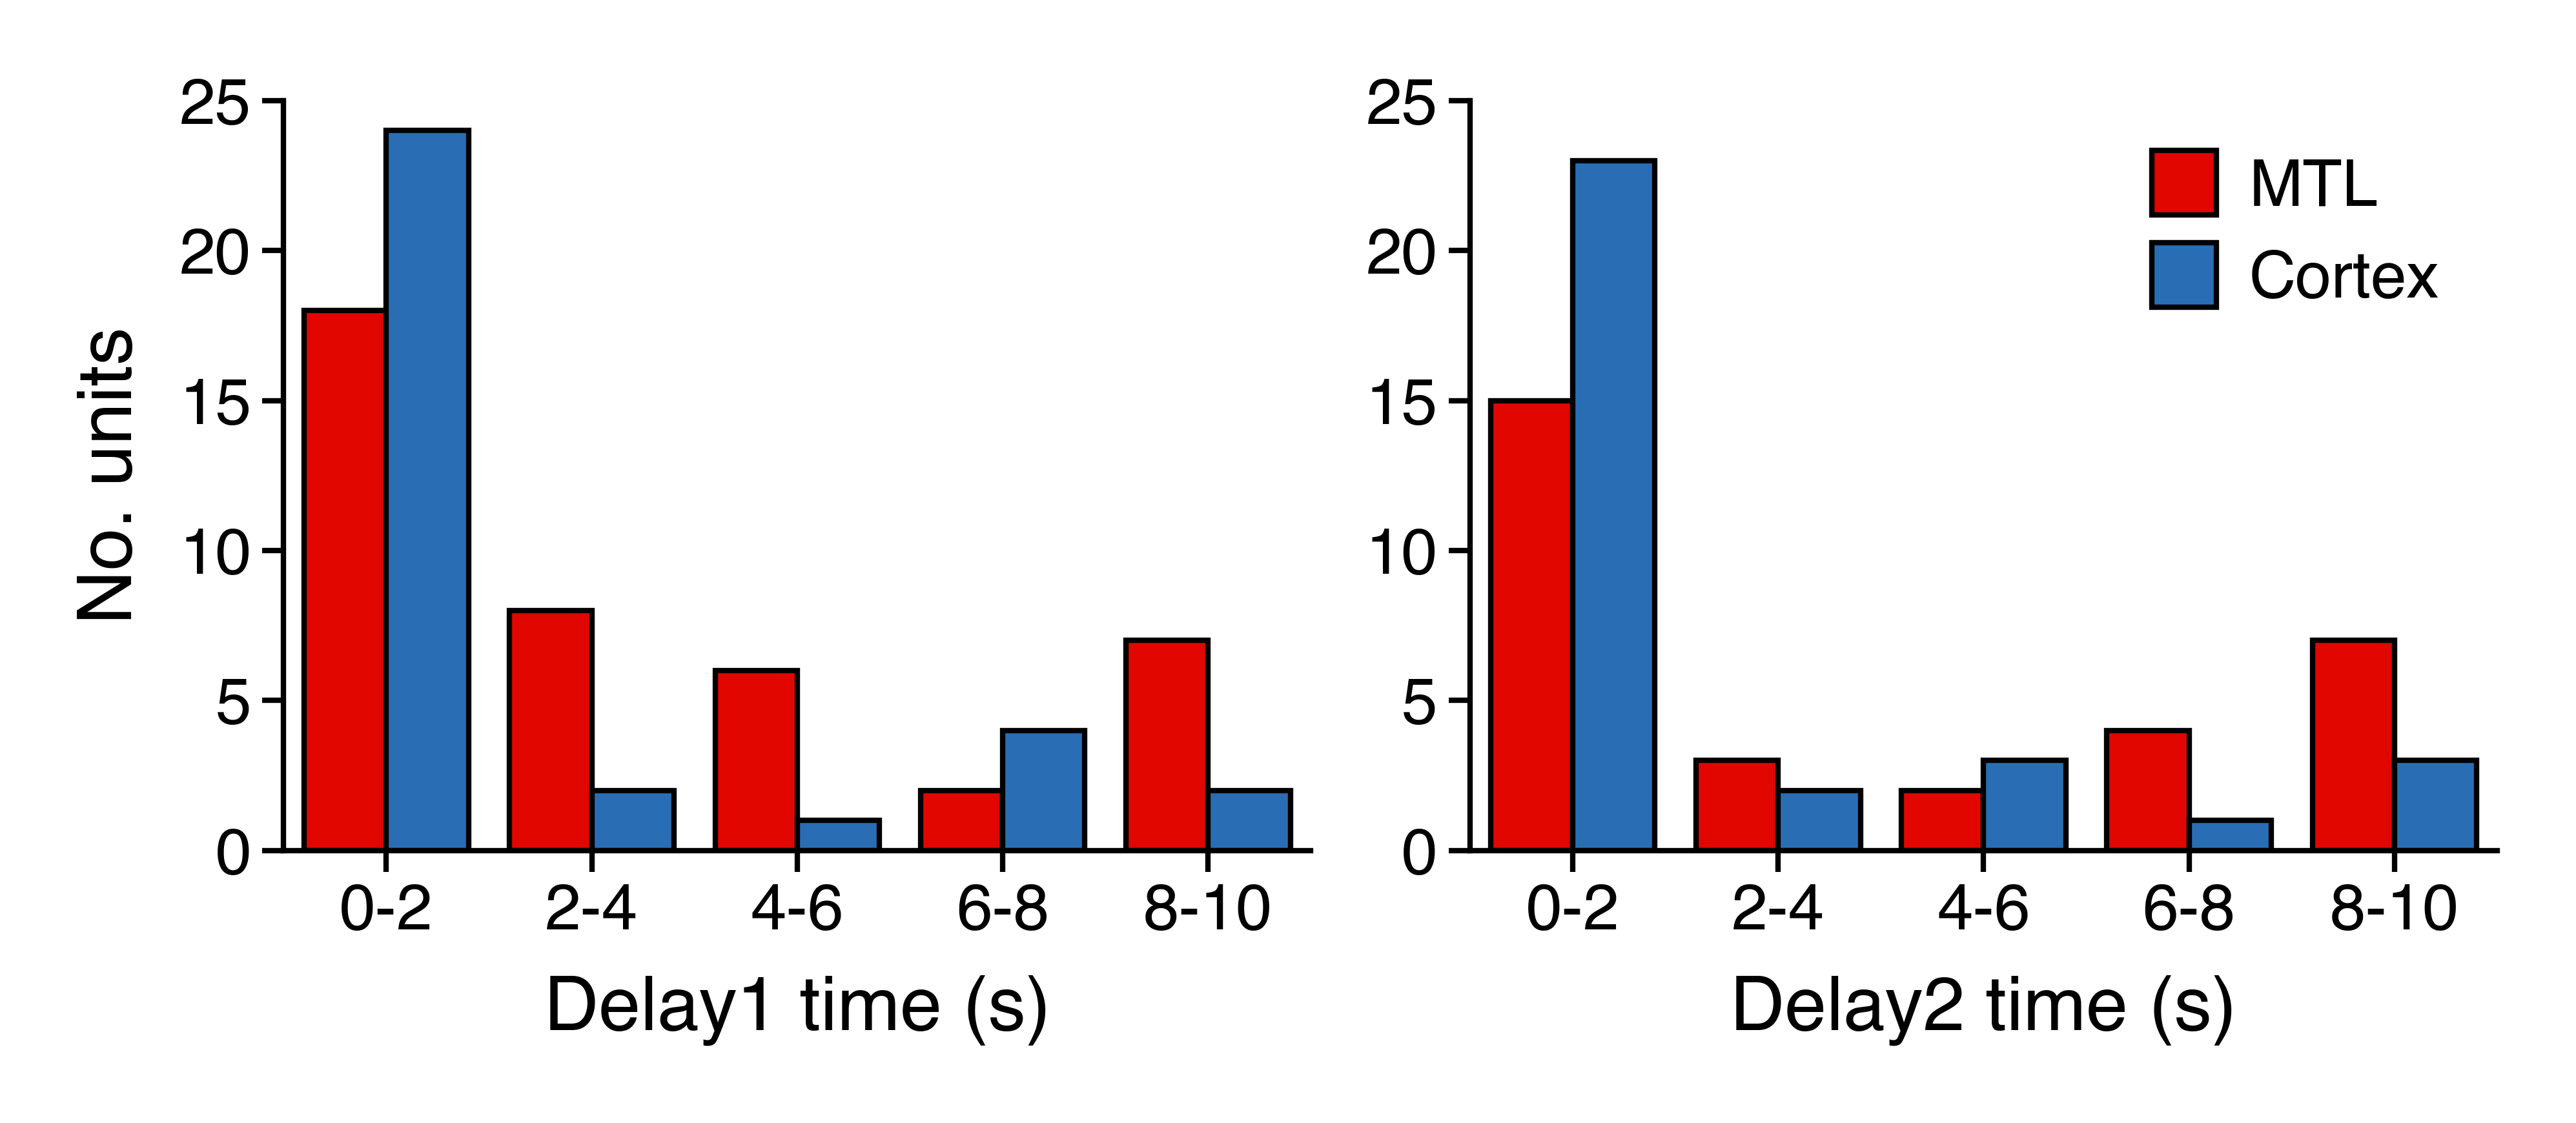

In [34]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[2]]
    
for iax, game_state in enumerate(['Delay1', 'Delay2']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='count', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                          palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-2', '2-4', '4-6', '6-8', '8-10'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 25])
    yticks = [0, 5, 10, 15, 20, 25]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_delay', 'delay_time_cell_peak_firing_time_counts_by_region2.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

0.29932379851665913 0.0010438859420889447


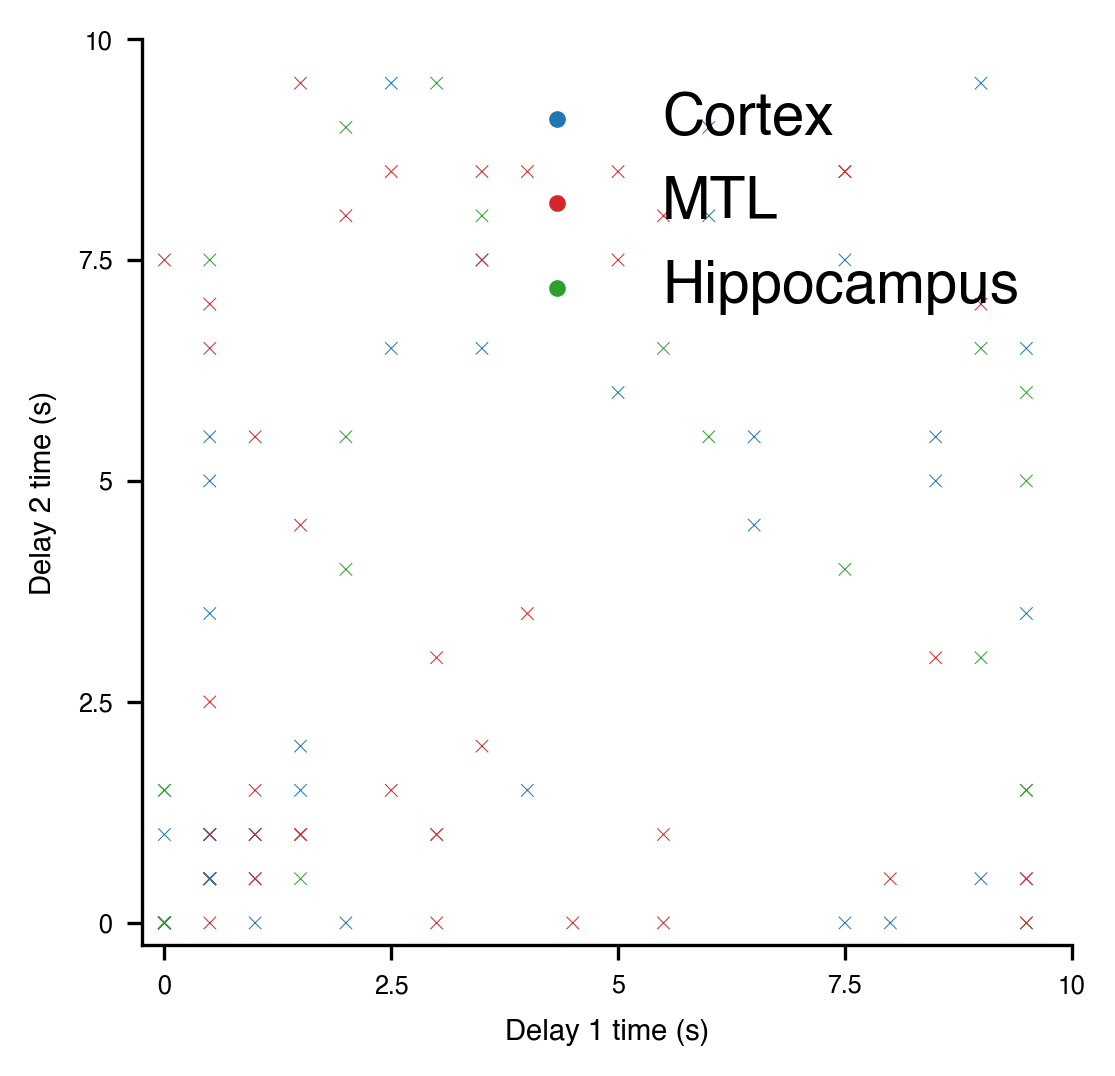

In [35]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

delay_time_cells = list(ols_pairs.query("(sig==True)")['subj_sess_unit'].unique())

r, p = stats.pearsonr([ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
                      [ols_pairs.query("(gameState=='Delay2') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells])
print(r, p)

sns.scatterplot(x=[ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
                y=[ols_pairs.query("(gameState=='Delay2') & (subj_sess_unit=='{}')".format(x)).iloc[0]['fr_max_ind'] for x in delay_time_cells],
                hue=[ols_pairs.query("(gameState=='Delay1') & (subj_sess_unit=='{}')".format(x)).iloc[0]['roi_gen'] for x in delay_time_cells],
                ax=ax, marker='x', color='k')
ax.set_xlim([-0.5, 20])
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xticklabels([0, 2.5, 5, 7.5, 10], fontsize=font['tick'])
ax.set_xlabel('Delay 1 time (s)', fontsize=font['label'], labelpad=5)
ax.set_ylim([-0.5, 20])
ax.set_yticks([0, 5, 10, 15, 20])
ax.set_yticklabels([0, 2.5, 5, 7.5, 10], fontsize=font['tick'])
ax.set_ylabel('Delay 2 time (s)', fontsize=font['label'], labelpad=5)
# ax.annotate('$r = {:.2f}$'.format(r), (0.1, 0.9), xycoords='axes fraction')
fig.show()

In [44]:
reload(time_cell_plots)

<module 'time_cells.time_cell_plots' from '/home1/dscho/code/projects/time_cells/time_cell_plots.py'>

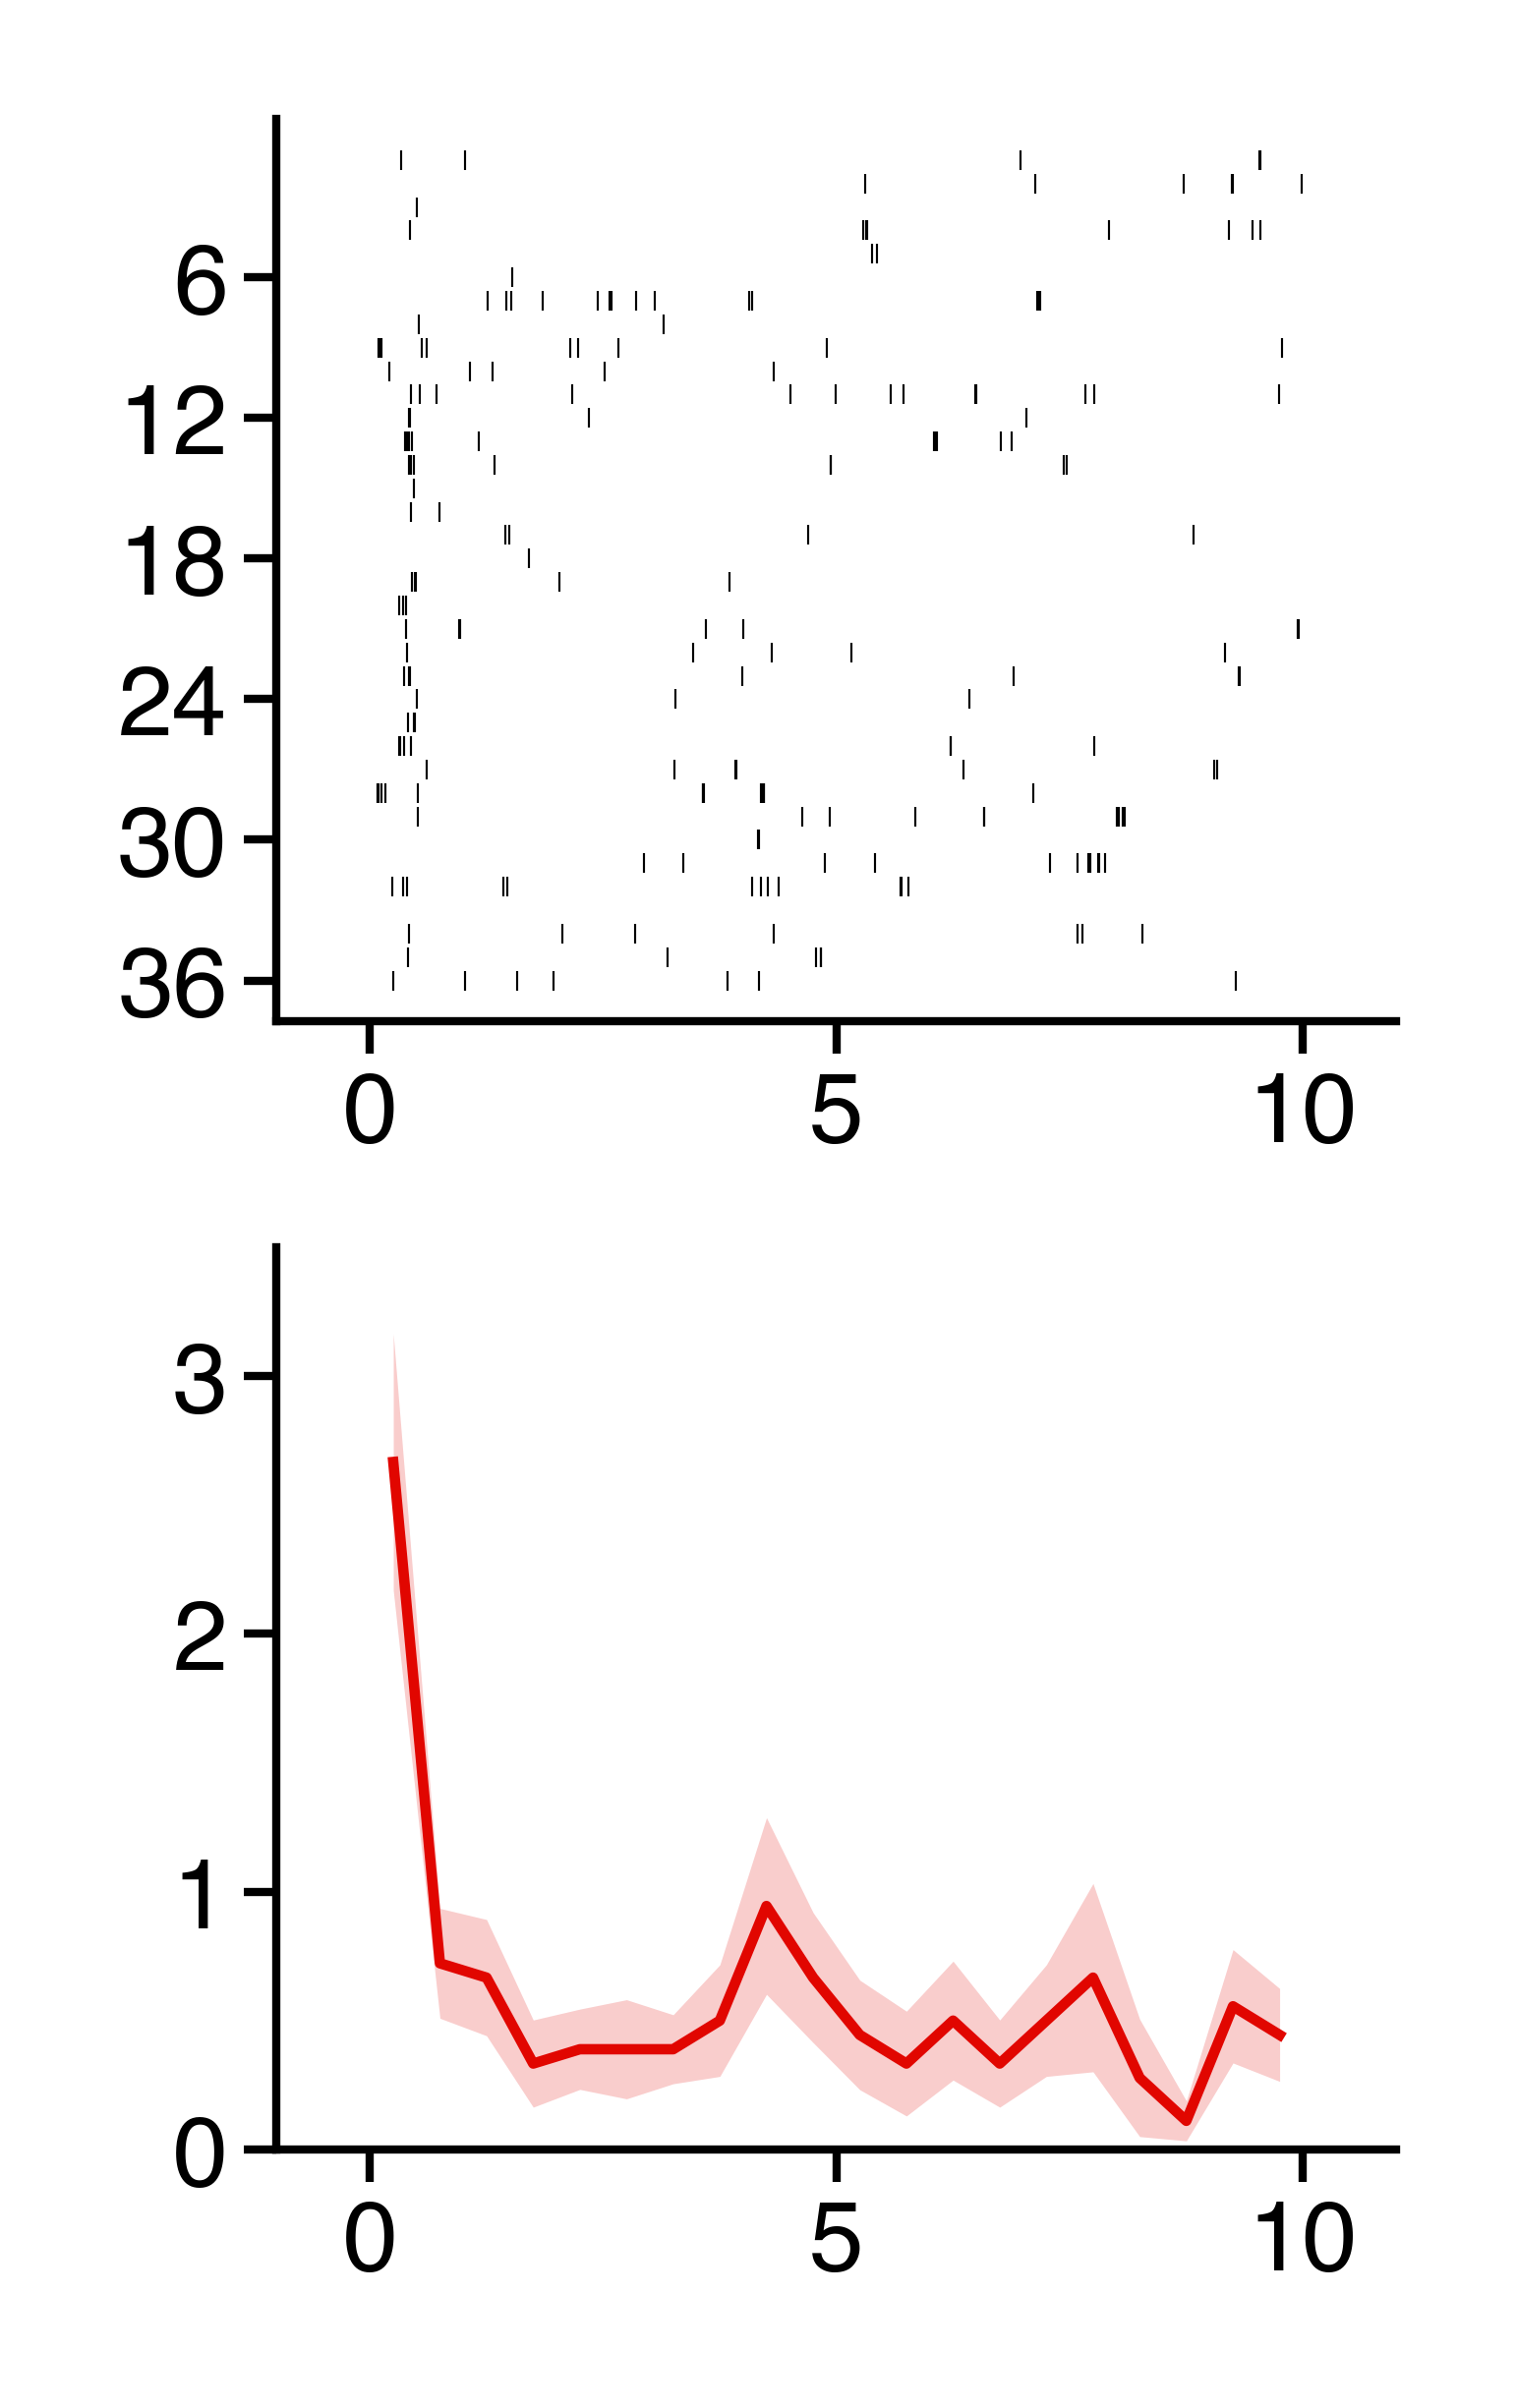

In [50]:
# Save raster and firing rate plots for chosen neuron.
subj_sess_unit = 'U537_ses0-24-1'
game_states = ['Delay1']
savefig = 1
overwrite = 1
figsize = np.array((1.1*1.07408, 2.2)) * 1.03644
dpi = 1200
font = {'tick': 6, 'label': 8, 'annot': 8, 'fig': 9}
ax_linewidth = 0.5
labelpad = 2
xtick_inc = 5
plot_vlines = 1
plot_labels = 0
plot_game_states = 0
plot_title = 0
rastersize = 1.25 / 1.08721
rasterwidth = 0.1 * 1.28571
linewidth = 0.6354
alpha = 0.2

plt.close()
fig, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])
ax[iax] = time_cell_plots.time_raster(subj_sess,
                                      neuron,
                                      game_states=game_states,
                                      plot_vlines=plot_vlines,
                                      plot_labels=plot_labels,
                                      plot_game_states=plot_game_states,
                                      plot_title=plot_title,
                                      ax=ax[iax],
                                      font=font,
                                      labelpad=labelpad,
                                      xtick_inc=xtick_inc,
                                      ax_linewidth=ax_linewidth,
                                      rastersize=rastersize,
                                      rasterwidth=rasterwidth)

iax += 1
ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                neuron,
                                                game_states=game_states,
                                                plot_vlines=plot_vlines,
                                                plot_labels=plot_labels,
                                                plot_game_states=plot_game_states,
                                                plot_title=plot_title,
                                                ax=ax[iax],
                                                linewidth=linewidth,
                                                font=font,
                                                alpha=alpha,
                                                labelpad=labelpad,
                                                xtick_inc=xtick_inc,
                                                ymin=0,
                                                ymax=3.5,
                                                yticks=[0, 1, 2, 3],
                                                ax_linewidth=ax_linewidth)

if savefig:
    chan, unit = neuron.split('-')
    hemroi = spike_preproc.roi_lookup(subj_sess, chan)
    filename = op.join(proj_dir, 'figs', 'plot_rasters',
                       '{}-CSC{}-unit{}-{}-{}-raster.pdf'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states)))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
            
fig.show()

In [5]:
ols_pairs.iloc[0]

subj                                                            U518
subj_sess                                                  U518_ses0
subj_sess_unit                                        U518_ses0-11-1
neuron                                                          11-1
hem                                                                R
roi                                                               TO
roi_gen2                                                      Cortex
roi_gen3                                                      Cortex
roi_gen4                                                      Cortex
roi_gen5                                                    Temporal
gameState                                                     Delay1
testvar                                                         time
full                                                            full
llf_full                                                    -1042.49
lr                                

In [4]:
game_states = ['Delay1', 'Delay2']
keep_cols = ['subj_sess_unit', 'roi', 'gameState', 'testvar', 'z_lr', 'fr_mean', 'sparsity',
             'fr_max_ind', 'fr_max_ind10', 'fr_max_ind5', 'fr_max_ind4', 'emp_pval', 'sig',
             'beta_argmin', 'beta_min', 'beta_argmax', 'beta_max', 'beta_abs_argmax', 'beta_abs_max']
(ols_pairs.query("(testvar=='time') & (gameState=={}) & (sig==True)".format(game_states))
          .sort_values('z_lr', ascending=False)[keep_cols]
          .drop_duplicates('subj_sess_unit').head(50))

subj_sess_unit  roi gameState testvar       z_lr    fr_mean  sparsity  \
264   U518_ses0-73-1  TPO    Delay1    time  14.359388   5.477778  0.874796   
4301  U537_ses0-24-1   AH    Delay1    time  10.096879   0.591667  0.574437   
209    U518_ses0-4-1   EC    Delay1    time   9.282328   6.202778  0.909452   
2751  U532_ses0-10-1    A    Delay2    time   7.751487   8.051515  0.973806   
3982  U536_ses0-60-1   OF    Delay1    time   7.487863   1.502778  0.799719   
506    U518_ses1-4-1   EC    Delay1    time   7.112284   9.582353  0.972147   
4169  U536_ses0-76-1   AC    Delay1    time   6.964470   2.394444  0.897396   
232   U518_ses0-40-1   MH    Delay2    time   6.509801   5.633333  0.944495   
1519  U527_ses0-57-1   OF    Delay2    time   6.168643  17.547222  0.981127   
1     U518_ses0-11-1   TO    Delay2    time   5.811098   7.938889  0.949681   
56    U518_ses0-16-2   TO    Delay2    time   5.761699   1.733333  0.881500   
2971  U532_ses0-22-1  FSG    Delay2    time   5.727320   4.115152  0.964319   
1628  U530_ses0-13-1   MH    Delay1    time   5.430661   1.963889  0.898266   
121   U518_ses0-32-1    A    Delay1    time   5.145765   2.155556  0.952027   
2234  U530_ses0-75-1  HGa    Delay2    time   5.119880  17.197222  0.976337   
3774  U536_ses0-31-2   AC    Delay2    time   4.842288   0.480556  0.744132   
1958  U530_ses0-48-3   EC    Delay1    time   4.756730   7.858333  0.968463   
4269  U537_ses0-10-1    A    Delay2    time   4.707333   0.788889  0.871392   
485   U518_ses1-38-1   MH    Delay2    time   4.610372   5.279412  0.973674   
3234  U532_ses0-47-1    A    Delay1    time   4.546175   9.245455  0.972436   
3620  U536_ses0-20-4    A    Delay2    time   4.522326   0.291667  0.726285   
1078  U526_ses0-21-1  FOp    Delay1    time   4.519395  12.541667  0.990494   
4280  U537_ses0-15-1    A    Delay2    time   4.490799   2.038889  0.945983   
3433   U532_ses0-8-1   AH    Delay2    time   4.421901   5.609091  0.964665   
276   U518_ses0-78-1  TPO    Delay2    time   4.407230   6.238889  0.963871   
4533  U539_ses0-55-1   EC    Delay2    time   4.305727   1.494118  0.801341   
1342  U527_ses0-17-1    A    Delay1    time   4.156149   8.869444  0.982377   
2937  U532_ses0-20-1  FSG    Delay1    time   3.942173   5.439394  0.971643   
4257   U536_ses0-9-1   MH    Delay1    time   3.936476   2.538889  0.874760   
1574  U527_ses0-61-1   OF    Delay2    time   3.862158   7.883333  0.967839   
44    U518_ses0-16-1   TO    Delay1    time   3.824779   3.633333  0.937480   
3444   U532_ses0-8-2   AH    Delay2    time   3.774087   1.721212  0.898774   
4609  U540_ses0-19-1  FSG    Delay1    time   3.736928   3.688889  0.958095   
705   U518_ses1-79-1  TPO    Delay2    time   3.735855   3.726471  0.972019   
3267   U532_ses0-5-1   AH    Delay1    time   3.707456   5.909091  0.960829   
3213  U532_ses0-46-1    A    Delay2    time   3.699635   1.375758  0.893980   
3201  U532_ses0-45-3    A    Delay1    time   3.697157   3.375758  0.953732   
2728  U530_ses1-80-3  HGa    Delay1    time   3.695599   2.569444  0.946802   
3597  U536_ses0-20-2    A    Delay1    time   3.667461   0.436111  0.752871   
2685  U530_ses1-79-1  HGa    Delay2    time   3.623067   3.825000  0.962102   
2773  U532_ses0-11-1    A    Delay2    time   3.584402   6.051515  0.969351   
1155  U526_ses0-41-2   AH    Delay1    time   3.581586   7.330556  0.990564   
2992  U532_ses0-23-1  FSG    Delay1    time   3.479836   8.272727  0.983108   
1496  U527_ses0-45-2   EC    Delay1    time   3.416502   0.938889  0.864175   
1486  U527_ses0-45-1   EC    Delay2    time   3.391990   3.008333  0.948464   
2948  U532_ses0-21-1  FSG    Delay1    time   3.333160   6.557576  0.973454   
33    U518_ses0-15-1   TO    Delay1    time   3.215189  10.533333  0.987478   
2201  U530_ses0-73-1  HGa    Delay2    time   3.203221  17.044444  0.995549   
331   U518_ses1-11-1   TO    Delay2    time   3.177219   1.564706  0.915343   
4346  U537_ses0-33-2    A    Delay2    time   3.118949  

In [35]:
subj_sess_unit = 'U532_ses0-8-2'
ols_pairs.query("(subj_sess_unit=='{}')".format(subj_sess_unit)).sort_values('z_lr', ascending=False)[keep_cols] # & (testvar=='time')

subj_sess_unit roi  gameState       testvar      z_lr   fr_mean  \
3451  U532_ses0-8-2  AH  Retrieval         place  4.135557  1.562626   
3444  U532_ses0-8-2  AH     Delay2          time  3.774087  1.721212   
3450  U532_ses0-8-2  AH  Retrieval          time  3.334434  1.562626   
3446  U532_ses0-8-2  AH   Encoding         place  1.800119  1.362626   
3453  U532_ses0-8-2  AH  Retrieval  base_in_view  1.418489  1.562626   
3449  U532_ses0-8-2  AH   Encoding  gold_in_view  1.271193  1.362626   
3447  U532_ses0-8-2  AH   Encoding    head_direc  0.796266  1.362626   
3443  U532_ses0-8-2  AH     Delay1          time  0.625512  2.481818   
3448  U532_ses0-8-2  AH   Encoding  base_in_view  0.439102  1.362626   
3452  U532_ses0-8-2  AH  Retrieval    head_direc  0.027570  1.562626   
3445  U532_ses0-8-2  AH   Encoding          time -0.833736  1.362626   

      sparsity  fr_max_ind  fr_max_ind10  fr_max_ind5  fr_max_ind4  emp_pval  \
3451  0.809145          55             9            4            3  0.000999   
3444  0.898774           0             0            0            0  0.003996   
3450  0.809145          55             9            4            3  0.005994   
3446  0.866151           0             9            4            3  0.045954   
3453  0.809145          55             9            4            3  0.081918   
3449  0.866151           0             9            4            3  0.100899   
3447  0.866151           0             9            4            3  0.189810   
3443  0.939310           0             0            0            0  0.227772   
3448  0.866151           0             9            4            3  0.206793   
3452  0.809145          55             9            4            3  0.414585   
3445  0.866151           0             9            4            3  0.790210   

        sig  beta_argmin  beta_min  beta_argmax  beta_max  beta_abs_argmax  \
3451   True            3 -0.341989            0  0.581287                0   
3444   True            3 -0.812121            0  1.127273                0   
3450   True            0 -0.616966            9  0.338821                0   
3446   True            8 -0.218819            0  0.380333                0   
3453  False            0 -0.299502            0 -0.299502                0   
3449  False            0 -0.093353            0 -0.093353                0   
3447  False            6 -0.202191            0  0.225926                0   
3443  False            6 -1.027273            0  0.730303                6   
3448  False            0  0.084801            0  0.084801                0   
3452  False            6 -0.169859            2  0.186140                2   
3445  False            0 -0.218917            2  0.161466                0   

      beta_abs_max  
3451      0.581287  
3444      1.127273  
3450     -0.616966  
3446      0.380333  
3453     -0.299502  
3449     -0.093353  
3447      0.225926  
3443     -1.027273  
3448      0.084801  
3452      0.186140  
3445     -0.218917

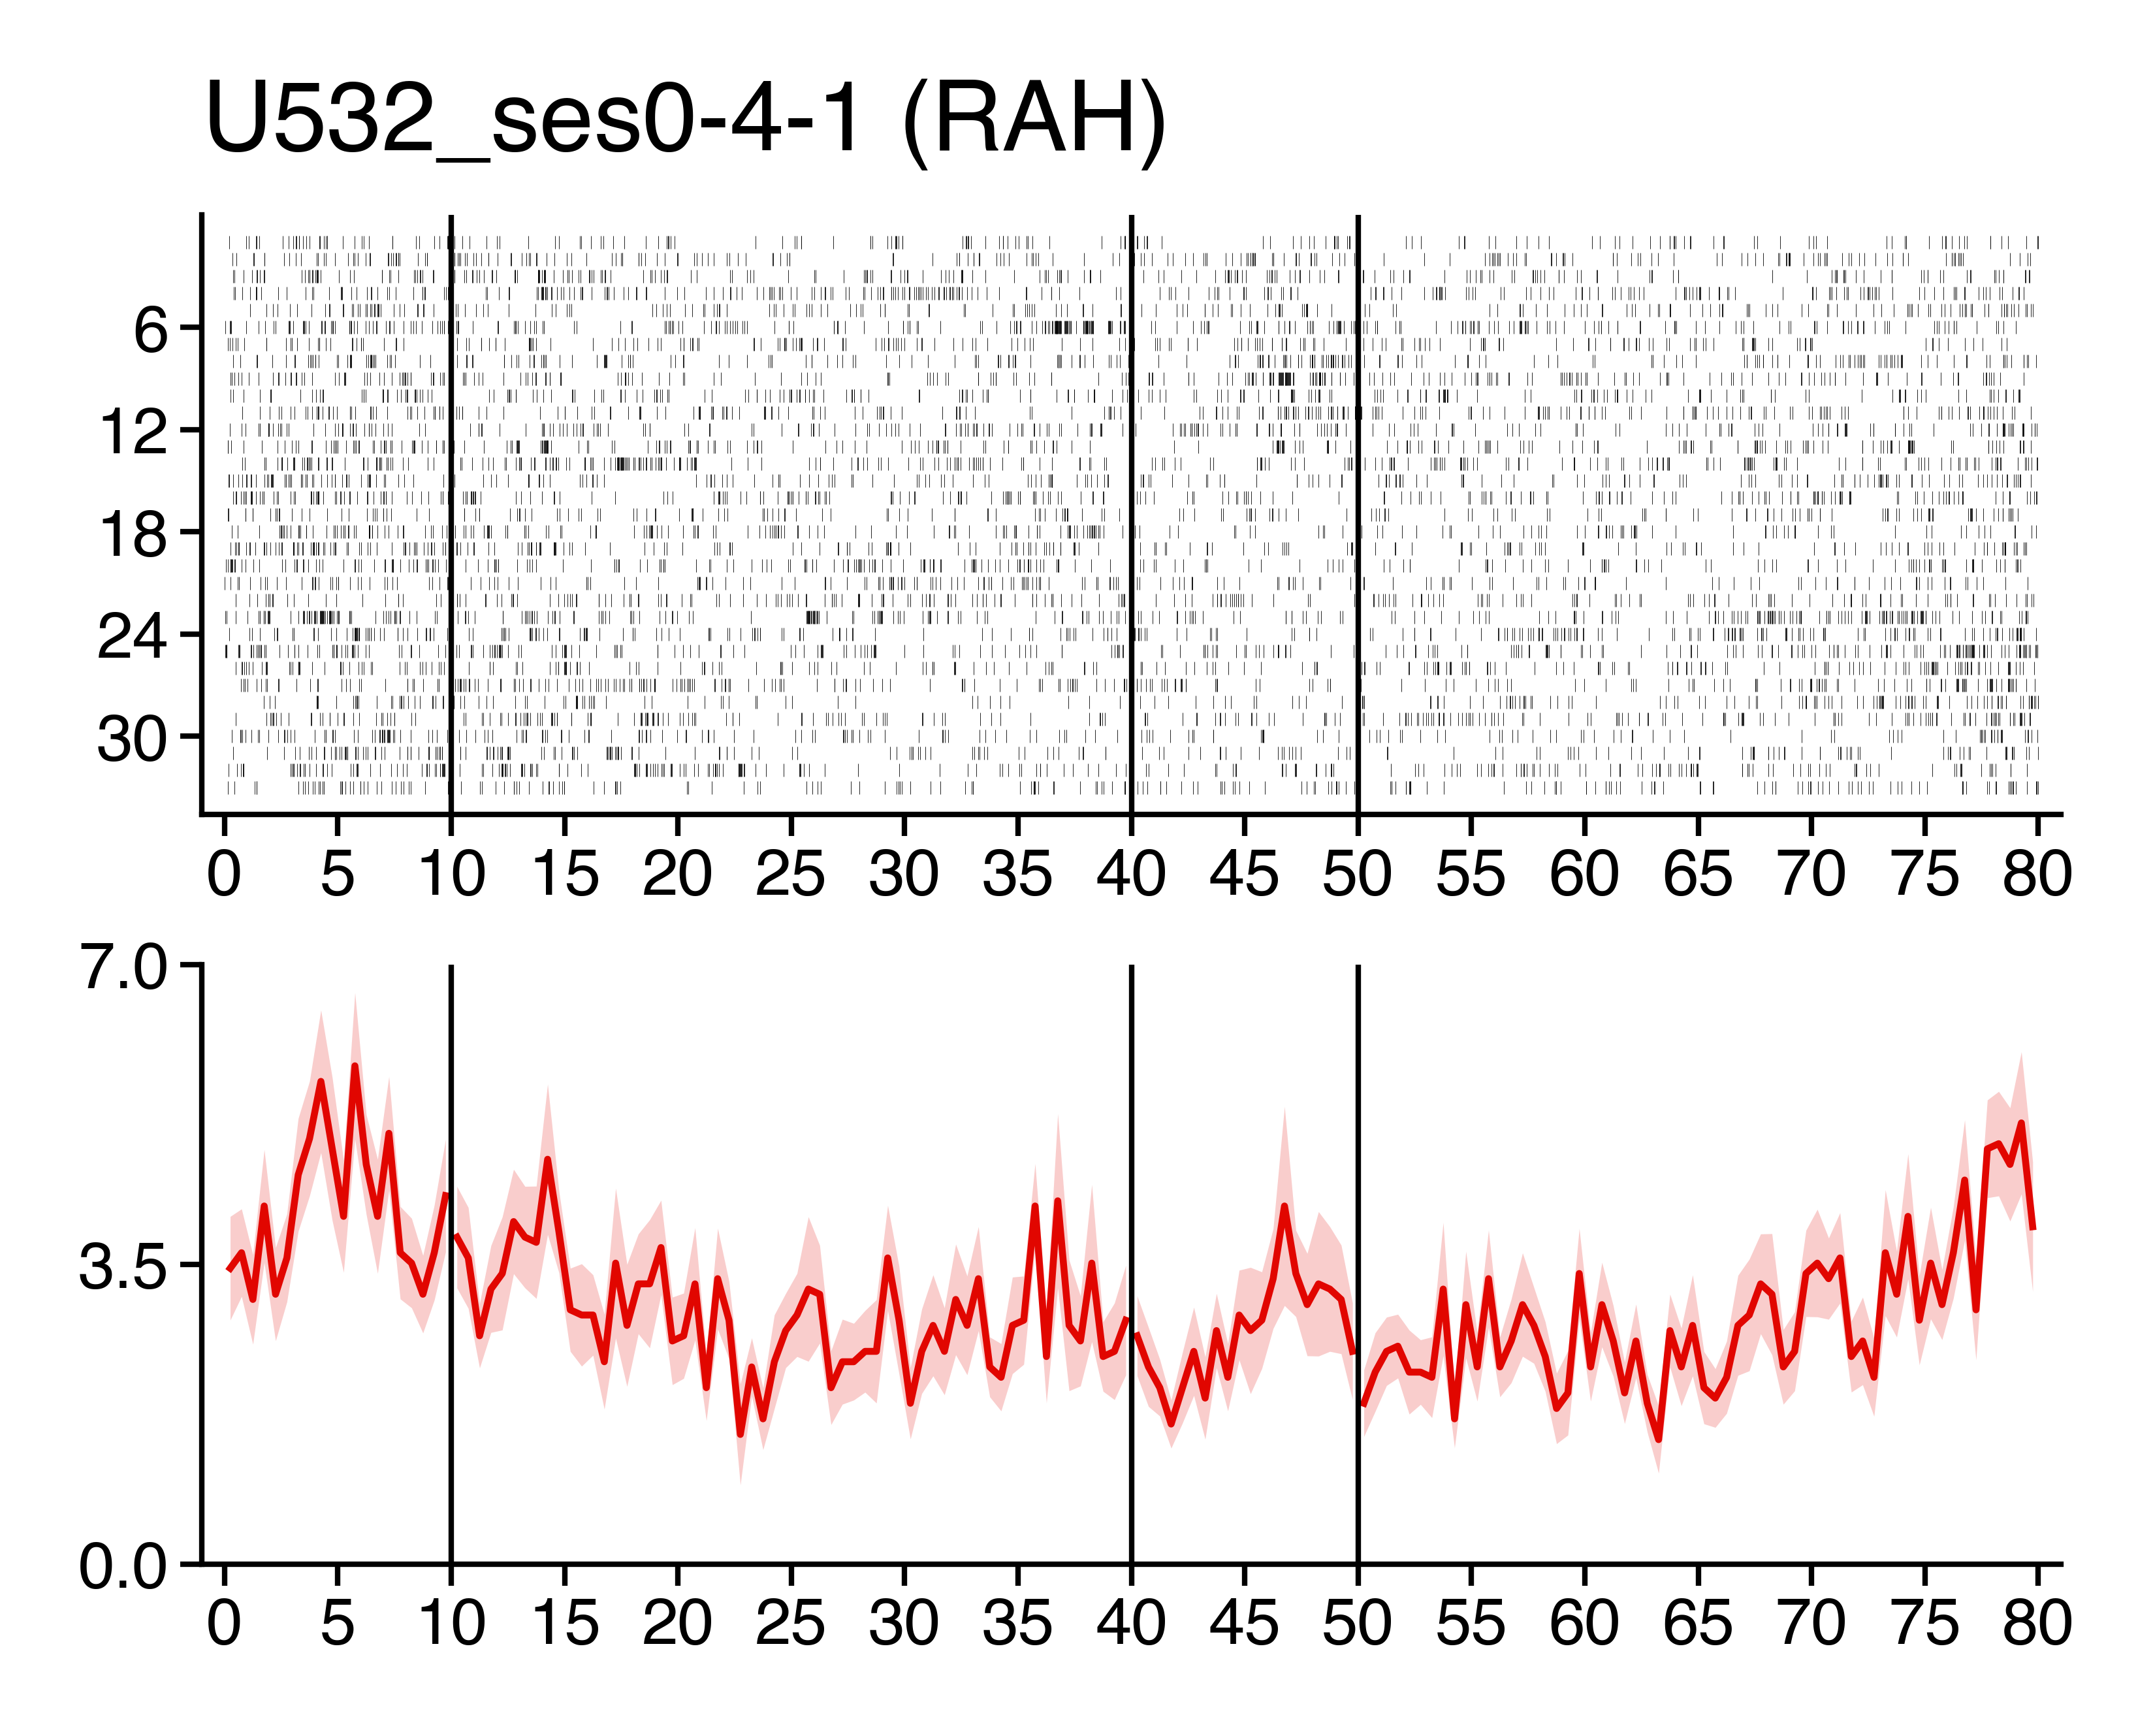

In [202]:
# Save raster and firing rate plots for chosen neuron.
# subj_sess_unit = 'U536_ses0-12-2'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
savefig = 0
overwrite_pdf = 1
overwrite_png = 1
figsize = np.array((1.1*1.07408*2.5, 2.2)) * 1.03644
dpi = 1200
font = {'tick': 6, 'label': 8, 'annot': 8, 'fig': 9}
ax_linewidth = 0.5
labelpad = 2
xtick_inc = 5
plot_vlines = 1
plot_labels = 0
plot_game_states = 0
plot_title = 1
rastersize = 1.25 / 1.08721
rasterwidth = 0.05 # 0.1 * 1.28571
linewidth = 0.6354
alpha = 0.2

plt.close()
fig, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])
ax[iax] = time_cell_plots.time_raster(subj_sess,
                                      neuron,
                                      game_states=game_states,
                                      plot_vlines=plot_vlines,
                                      plot_labels=plot_labels,
                                      plot_game_states=plot_game_states,
                                      plot_title=plot_title,
                                      ax=ax[iax],
                                      font=font,
                                      labelpad=labelpad,
                                      xtick_inc=xtick_inc,
                                      ax_linewidth=ax_linewidth,
                                      rastersize=rastersize,
                                      rasterwidth=rasterwidth)

iax += 1
ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                neuron,
                                                game_states=game_states,
                                                plot_vlines=plot_vlines,
                                                plot_labels=plot_labels,
                                                plot_game_states=plot_game_states,
                                                plot_title=0,
                                                ax=ax[iax],
                                                linewidth=linewidth,
                                                font=font,
                                                alpha=alpha,
                                                labelpad=labelpad,
                                                xtick_inc=xtick_inc,
#                                                 ymin=2,
#                                                 ymax=12,
#                                                 yticks=[2, 7, 12],
                                                ax_linewidth=ax_linewidth)

if savefig:
    chan, unit = neuron.split('-')
    hemroi = spike_preproc.roi_lookup(subj_sess, chan)
    filename = op.join(proj_dir, 'figs', 'plot_rasters',
                       '{}-CSC{}-unit{}-{}-{}-raster.pdf'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states)))
    if overwrite_pdf or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
    filename = filename.replace('.pdf', '.png')
    if overwrite_png or not op.exists(filename):
        fig.savefig(filename, format='png', dpi=1200, bbox_inches='tight', pad_inches=0)
            
fig.show()

# Single-neuron results.

U532_ses0-10-1, RA


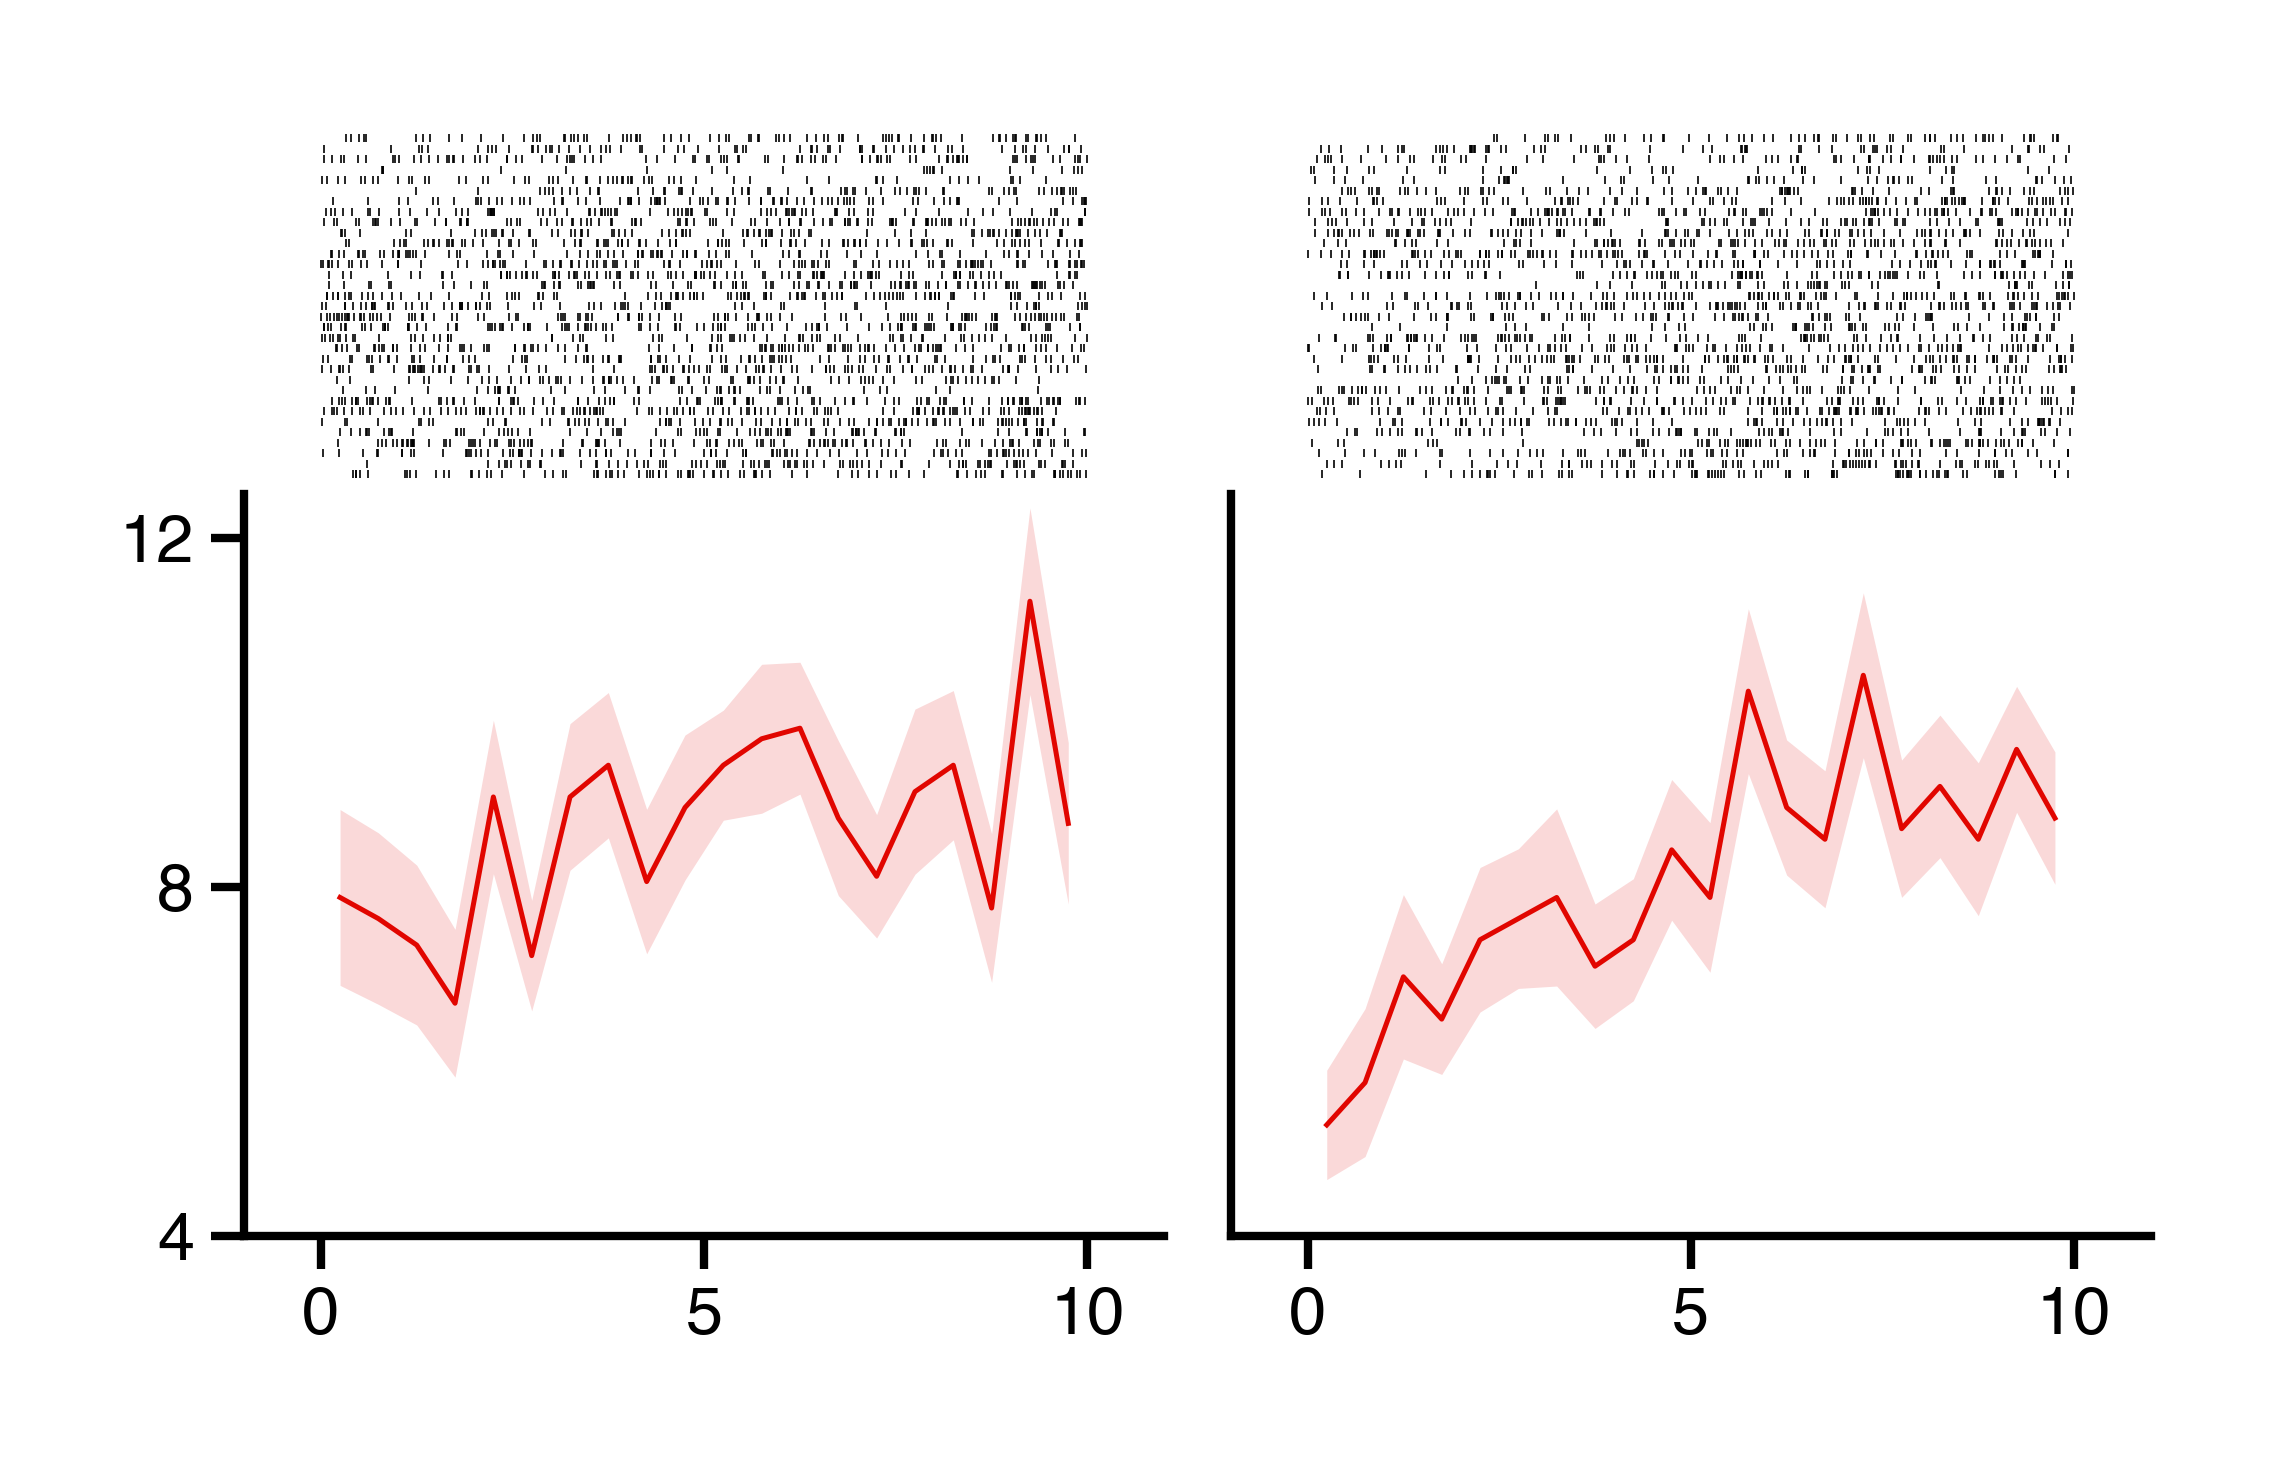

In [47]:
# gameState - 'U527_ses0-58-2'
# time      - 'U518_ses0-4-1', 'U518_ses1-38-1', 'U532_ses0-10-1'
subj_sess_unit = 'U532_ses0-10-1'
savefig = 1
overwrite = 1
game_states = ['Delay1', 'Delay2']
y_scale = {'U527_ses0-58-2': {'ymin': 0,   'ymax': 3.2,   'yticks': [0, 1.5, 3]},
           'U518_ses0-4-1': {'ymin': 3,   'ymax': 15.5,   'yticks': [3, 9, 15]},
           'U518_ses1-38-1': {'ymin': 3, 'ymax': 8, 'yticks': [3, 5.5, 8]},
           'U532_ses0-10-1': {'ymin': 4, 'ymax': 12.5, 'yticks': [4, 8, 12]}}
grid_shp = (72, 120)
figsize = (colws[1], colws[1] * (grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 7}
rastersize = 0.5
rasterwidth = 0.1
xtick_inc = 5
lw = 0.3

subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])

plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=24, colspan=58),
      plt.subplot2grid(grid_shp, (0, 62), rowspan=24, colspan=58),
      plt.subplot2grid(grid_shp, (24, 0), rowspan=48, colspan=58),
      plt.subplot2grid(grid_shp, (24, 62), rowspan=48, colspan=58)]

iax = 0
ax[iax] = time_cell_plots.time_raster(subj_sess,
                                      neuron, 
                                      game_states[0],
                                      ax=ax[iax],
                                      plot_game_states=False,
                                      plot_labels=False,
                                      plot_title=False,
                                      font=font,
                                      rastersize=rastersize,
                                      rasterwidth=rasterwidth,
                                      ax_linewidth=0)
ax[iax].set_xticks([])
ax[iax].set_yticks([])

iax = 1
ax[iax] = time_cell_plots.time_raster(subj_sess,
                                      neuron, 
                                      game_states[1],
                                      ax=ax[iax],
                                      plot_game_states=False,
                                      plot_labels=False,
                                      plot_title=False,
                                      font=font,
                                      rastersize=rastersize,
                                      rasterwidth=rasterwidth,
                                      ax_linewidth=0)
ax[iax].set_xticks([])
ax[iax].set_yticks([])

iax = 2
ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                neuron, 
                                                game_states[0],
                                                ax=ax[iax],
                                                overlap=False,
                                                plot_game_states=False,
                                                plot_labels=False,
                                                plot_title=False,
                                                linewidth=lw,
                                                xtick_inc=xtick_inc,
                                                ymin=y_scale[subj_sess_unit]['ymin'],
                                                ymax=y_scale[subj_sess_unit]['ymax'],
                                                yticks=y_scale[subj_sess_unit]['yticks'],
                                                font=font)

iax = 3
ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                neuron, 
                                                game_states[1],
                                                ax=ax[iax],
                                                overlap=False,
                                                plot_game_states=False,
                                                plot_labels=False,
                                                plot_title=False,
                                                linewidth=lw,
                                                xtick_inc=xtick_inc,
                                                ymin=y_scale[subj_sess_unit]['ymin'],
                                                ymax=y_scale[subj_sess_unit]['ymax'],
                                                yticks=y_scale[subj_sess_unit]['yticks'],
                                                font=font)
ax[iax].set_yticks([])

chan, unit = neuron.split('-')
hemroi = spike_preproc.roi_lookup(subj_sess, chan)
if savefig:    
    filename = op.join(proj_dir, 'figs', 'plot_delay2', 
                       '{}-CSC{}-unit{}-{}-{}-time_firing.png'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states)))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
    filename = filename.replace('.png', '.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        
print('{}-{}, {}'.format(subj_sess, neuron, hemroi, '_'.join(game_states)))
fig.show()